In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(390464, 828)
(390464, 8)
validation
(50536, 828)
(50536, 8)
test
(48320, 828)
(48320, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/40 [..............................] - ETA: 53s - loss: 2.0834 - STD: 0.0810 - MAE: 0.2166

 4/40 [==>...........................] - ETA: 1s - loss: 1.6128 - STD: 0.1199 - MAE: 0.1814 

 5/40 [==>...........................] - ETA: 2s - loss: 1.5583 - STD: 0.1398 - MAE: 0.1719

 6/40 [===>..........................] - ETA: 2s - loss: 1.5198 - STD: 0.1557 - MAE: 0.1645

 7/40 [====>.........................] - ETA: 2s - loss: 1.4924 - STD: 0.1679 - MAE: 0.1588

 8/40 [=====>........................] - ETA: 2s - loss: 1.4711 - STD: 0.1769 - MAE: 0.1546

 9/40 [=====>........................] - ETA: 2s - loss: 1.4542 - STD: 0.1833 - MAE: 0.1516

10/40 [======>.......................] - ETA: 2s - loss: 1.4402 - STD: 0.1874 - MAE: 0.1496

11/40 [=======>......................] - ETA: 2s - loss: 1.4282 - STD: 0.1898 - MAE: 0.1484

12/40 [========>.....................] - ETA: 2s - loss: 1.4167 - STD: 0.1908 - MAE: 0.1477

13/40 [========>.....................] - ETA: 2s - loss: 1.4094 - STD: 0.1910 - MAE: 0.1475

14/40 [=========>....................] - ETA: 2s - loss: 1.4001 - STD: 0.1906 - MAE: 0.1474

15/40 [==========>...................] - ETA: 2s - loss: 1.3947 - STD: 0.1900 - MAE: 0.1475

16/40 [===========>..................] - ETA: 2s - loss: 1.3891 - STD: 0.1894 - MAE: 0.1476

17/40 [===========>..................] - ETA: 2s - loss: 1.3845 - STD: 0.1888 - MAE: 0.1477

18/40 [============>.................] - ETA: 2s - loss: 1.3787 - STD: 0.1885 - MAE: 0.1476

19/40 [=============>................] - ETA: 2s - loss: 1.3743 - STD: 0.1884 - MAE: 0.1476

20/40 [==============>...............] - ETA: 1s - loss: 1.3702 - STD: 0.1885 - MAE: 0.1474

21/40 [==============>...............] - ETA: 1s - loss: 1.3661 - STD: 0.1889 - MAE: 0.1471

22/40 [===============>..............] - ETA: 1s - loss: 1.3632 - STD: 0.1894 - MAE: 0.1468

23/40 [================>.............] - ETA: 1s - loss: 1.3607 - STD: 0.1901 - MAE: 0.1465

24/40 [=================>............] - ETA: 1s - loss: 1.3573 - STD: 0.1908 - MAE: 0.1461

25/40 [=================>............] - ETA: 1s - loss: 1.3559 - STD: 0.1915 - MAE: 0.1458

26/40 [==================>...........] - ETA: 1s - loss: 1.3536 - STD: 0.1922 - MAE: 0.1454

27/40 [===================>..........] - ETA: 1s - loss: 1.3515 - STD: 0.1928 - MAE: 0.1451

28/40 [====================>.........] - ETA: 1s - loss: 1.3496 - STD: 0.1934 - MAE: 0.1449

29/40 [====================>.........] - ETA: 1s - loss: 1.3494 - STD: 0.1938 - MAE: 0.1445

33/40 [=======================>......] - ETA: 0s - loss: 1.3418 - STD: 0.1944 - MAE: 0.1441

34/40 [========================>.....] - ETA: 0s - loss: 1.3400 - STD: 0.1944 - MAE: 0.1440

35/40 [=========================>....] - ETA: 0s - loss: 1.3380 - STD: 0.1944 - MAE: 0.1440

36/40 [==========================>...] - ETA: 0s - loss: 1.3369 - STD: 0.1944 - MAE: 0.1440

37/40 [==========================>...] - ETA: 0s - loss: 1.3361 - STD: 0.1944 - MAE: 0.1440

38/40 [===========================>..] - ETA: 0s - loss: 1.3350 - STD: 0.1944 - MAE: 0.1440

39/40 [============================>.] - ETA: 0s - loss: 1.3337 - STD: 0.1944 - MAE: 0.1439

40/40 [==============================] - ETA: 0s - loss: 1.3322 - STD: 0.1945 - MAE: 0.1439

40/40 [==============================] - 6s 126ms/step - loss: 1.3322 - STD: 0.1945 - MAE: 0.1439 - val_loss: 1.2227 - val_STD: 0.1968 - val_MAE: 0.1435


Epoch 2/10000


 1/40 [..............................] - ETA: 5s - loss: 1.2753 - STD: 0.1968 - MAE: 0.1416

 2/40 [>.............................] - ETA: 4s - loss: 1.2794 - STD: 0.1971 - MAE: 0.1416

 3/40 [=>............................] - ETA: 4s - loss: 1.2780 - STD: 0.1973 - MAE: 0.1413

 4/40 [==>...........................] - ETA: 3s - loss: 1.2804 - STD: 0.1976 - MAE: 0.1414

 5/40 [==>...........................] - ETA: 3s - loss: 1.2793 - STD: 0.1977 - MAE: 0.1414

 6/40 [===>..........................] - ETA: 3s - loss: 1.2804 - STD: 0.1976 - MAE: 0.1414

 7/40 [====>.........................] - ETA: 3s - loss: 1.2794 - STD: 0.1975 - MAE: 0.1414

 8/40 [=====>........................] - ETA: 3s - loss: 1.2790 - STD: 0.1974 - MAE: 0.1414

 9/40 [=====>........................] - ETA: 3s - loss: 1.2792 - STD: 0.1972 - MAE: 0.1415

10/40 [======>.......................] - ETA: 3s - loss: 1.2770 - STD: 0.1970 - MAE: 0.1414

11/40 [=======>......................] - ETA: 3s - loss: 1.2787 - STD: 0.1968 - MAE: 0.1416

12/40 [========>.....................] - ETA: 3s - loss: 1.2768 - STD: 0.1967 - MAE: 0.1416

13/40 [========>.....................] - ETA: 2s - loss: 1.2784 - STD: 0.1965 - MAE: 0.1417

14/40 [=========>....................] - ETA: 2s - loss: 1.2788 - STD: 0.1964 - MAE: 0.1418

15/40 [==========>...................] - ETA: 2s - loss: 1.2783 - STD: 0.1963 - MAE: 0.1418

16/40 [===========>..................] - ETA: 2s - loss: 1.2795 - STD: 0.1962 - MAE: 0.1419

17/40 [===========>..................] - ETA: 2s - loss: 1.2798 - STD: 0.1961 - MAE: 0.1420

18/40 [============>.................] - ETA: 2s - loss: 1.2787 - STD: 0.1960 - MAE: 0.1420

19/40 [=============>................] - ETA: 2s - loss: 1.2784 - STD: 0.1959 - MAE: 0.1420

20/40 [==============>...............] - ETA: 2s - loss: 1.2785 - STD: 0.1959 - MAE: 0.1420

21/40 [==============>...............] - ETA: 2s - loss: 1.2791 - STD: 0.1958 - MAE: 0.1421

22/40 [===============>..............] - ETA: 1s - loss: 1.2792 - STD: 0.1958 - MAE: 0.1421

23/40 [================>.............] - ETA: 1s - loss: 1.2801 - STD: 0.1958 - MAE: 0.1421

24/40 [=================>............] - ETA: 1s - loss: 1.2804 - STD: 0.1958 - MAE: 0.1422

25/40 [=================>............] - ETA: 1s - loss: 1.2810 - STD: 0.1958 - MAE: 0.1422

26/40 [==================>...........] - ETA: 1s - loss: 1.2809 - STD: 0.1957 - MAE: 0.1422

27/40 [===================>..........] - ETA: 1s - loss: 1.2810 - STD: 0.1956 - MAE: 0.1423

28/40 [====================>.........] - ETA: 1s - loss: 1.2803 - STD: 0.1955 - MAE: 0.1423

29/40 [====================>.........] - ETA: 1s - loss: 1.2814 - STD: 0.1954 - MAE: 0.1424

30/40 [=====================>........] - ETA: 1s - loss: 1.2807 - STD: 0.1953 - MAE: 0.1424

31/40 [======================>.......] - ETA: 0s - loss: 1.2802 - STD: 0.1952 - MAE: 0.1424

32/40 [=======================>......] - ETA: 0s - loss: 1.2804 - STD: 0.1952 - MAE: 0.1424

33/40 [=======================>......] - ETA: 0s - loss: 1.2803 - STD: 0.1952 - MAE: 0.1424

34/40 [========================>.....] - ETA: 0s - loss: 1.2803 - STD: 0.1952 - MAE: 0.1424

35/40 [=========================>....] - ETA: 0s - loss: 1.2800 - STD: 0.1953 - MAE: 0.1423

36/40 [==========================>...] - ETA: 0s - loss: 1.2802 - STD: 0.1953 - MAE: 0.1424

37/40 [==========================>...] - ETA: 0s - loss: 1.2804 - STD: 0.1954 - MAE: 0.1423

39/40 [============================>.] - ETA: 0s - loss: 1.2805 - STD: 0.1953 - MAE: 0.1424

40/40 [==============================] - ETA: 0s - loss: 1.2807 - STD: 0.1952 - MAE: 0.1425

40/40 [==============================] - 4s 109ms/step - loss: 1.2807 - STD: 0.1952 - MAE: 0.1425 - val_loss: 1.2143 - val_STD: 0.1909 - val_MAE: 0.1452


Epoch 3/10000


 1/40 [..............................] - ETA: 5s - loss: 1.2809 - STD: 0.1914 - MAE: 0.1439

 2/40 [>.............................] - ETA: 4s - loss: 1.2723 - STD: 0.1913 - MAE: 0.1436

 3/40 [=>............................] - ETA: 4s - loss: 1.2792 - STD: 0.1915 - MAE: 0.1438

 4/40 [==>...........................] - ETA: 3s - loss: 1.2760 - STD: 0.1919 - MAE: 0.1436

 5/40 [==>...........................] - ETA: 3s - loss: 1.2732 - STD: 0.1923 - MAE: 0.1433

 6/40 [===>..........................] - ETA: 3s - loss: 1.2707 - STD: 0.1927 - MAE: 0.1430

 7/40 [====>.........................] - ETA: 3s - loss: 1.2695 - STD: 0.1931 - MAE: 0.1427

 8/40 [=====>........................] - ETA: 3s - loss: 1.2680 - STD: 0.1934 - MAE: 0.1425

 9/40 [=====>........................] - ETA: 3s - loss: 1.2666 - STD: 0.1937 - MAE: 0.1424

10/40 [======>.......................] - ETA: 3s - loss: 1.2653 - STD: 0.1940 - MAE: 0.1421

11/40 [=======>......................] - ETA: 3s - loss: 1.2667 - STD: 0.1943 - MAE: 0.1421

12/40 [========>.....................] - ETA: 3s - loss: 1.2661 - STD: 0.1946 - MAE: 0.1420

13/40 [========>.....................] - ETA: 2s - loss: 1.2669 - STD: 0.1948 - MAE: 0.1419

14/40 [=========>....................] - ETA: 2s - loss: 1.2662 - STD: 0.1950 - MAE: 0.1418

15/40 [==========>...................] - ETA: 2s - loss: 1.2643 - STD: 0.1950 - MAE: 0.1417

16/40 [===========>..................] - ETA: 2s - loss: 1.2635 - STD: 0.1950 - MAE: 0.1417

17/40 [===========>..................] - ETA: 2s - loss: 1.2631 - STD: 0.1950 - MAE: 0.1417

18/40 [============>.................] - ETA: 2s - loss: 1.2624 - STD: 0.1949 - MAE: 0.1417

19/40 [=============>................] - ETA: 2s - loss: 1.2606 - STD: 0.1948 - MAE: 0.1416

20/40 [==============>...............] - ETA: 2s - loss: 1.2594 - STD: 0.1949 - MAE: 0.1416

21/40 [==============>...............] - ETA: 2s - loss: 1.2585 - STD: 0.1950 - MAE: 0.1415

22/40 [===============>..............] - ETA: 1s - loss: 1.2574 - STD: 0.1951 - MAE: 0.1414

23/40 [================>.............] - ETA: 1s - loss: 1.2566 - STD: 0.1951 - MAE: 0.1414

24/40 [=================>............] - ETA: 1s - loss: 1.2548 - STD: 0.1951 - MAE: 0.1413

25/40 [=================>............] - ETA: 1s - loss: 1.2537 - STD: 0.1952 - MAE: 0.1412

26/40 [==================>...........] - ETA: 1s - loss: 1.2525 - STD: 0.1953 - MAE: 0.1411

27/40 [===================>..........] - ETA: 1s - loss: 1.2510 - STD: 0.1954 - MAE: 0.1410

28/40 [====================>.........] - ETA: 1s - loss: 1.2498 - STD: 0.1954 - MAE: 0.1410

29/40 [====================>.........] - ETA: 1s - loss: 1.2488 - STD: 0.1955 - MAE: 0.1409

30/40 [=====================>........] - ETA: 1s - loss: 1.2477 - STD: 0.1957 - MAE: 0.1408

31/40 [======================>.......] - ETA: 0s - loss: 1.2458 - STD: 0.1959 - MAE: 0.1406

32/40 [=======================>......] - ETA: 0s - loss: 1.2444 - STD: 0.1961 - MAE: 0.1405

33/40 [=======================>......] - ETA: 0s - loss: 1.2426 - STD: 0.1962 - MAE: 0.1404

34/40 [========================>.....] - ETA: 0s - loss: 1.2414 - STD: 0.1964 - MAE: 0.1403

36/40 [==========================>...] - ETA: 0s - loss: 1.2403 - STD: 0.1968 - MAE: 0.1401

37/40 [==========================>...] - ETA: 0s - loss: 1.2388 - STD: 0.1968 - MAE: 0.1401

38/40 [===========================>..] - ETA: 0s - loss: 1.2377 - STD: 0.1969 - MAE: 0.1400

39/40 [============================>.] - ETA: 0s - loss: 1.2364 - STD: 0.1971 - MAE: 0.1399

40/40 [==============================] - ETA: 0s - loss: 1.2355 - STD: 0.1972 - MAE: 0.1398

40/40 [==============================] - 4s 109ms/step - loss: 1.2355 - STD: 0.1972 - MAE: 0.1398 - val_loss: 1.1119 - val_STD: 0.1952 - val_MAE: 0.1397


Epoch 4/10000


 1/40 [..............................] - ETA: 5s - loss: 1.1827 - STD: 0.1990 - MAE: 0.1373

 2/40 [>.............................] - ETA: 4s - loss: 1.1772 - STD: 0.1991 - MAE: 0.1369

 3/40 [=>............................] - ETA: 4s - loss: 1.1884 - STD: 0.2013 - MAE: 0.1367

 4/40 [==>...........................] - ETA: 3s - loss: 1.1876 - STD: 0.2021 - MAE: 0.1364

 5/40 [==>...........................] - ETA: 3s - loss: 1.1884 - STD: 0.2018 - MAE: 0.1366

 6/40 [===>..........................] - ETA: 3s - loss: 1.1874 - STD: 0.2016 - MAE: 0.1367

 8/40 [=====>........................] - ETA: 2s - loss: 1.1867 - STD: 0.2013 - MAE: 0.1374

 9/40 [=====>........................] - ETA: 2s - loss: 1.1862 - STD: 0.2009 - MAE: 0.1376

10/40 [======>.......................] - ETA: 2s - loss: 1.1844 - STD: 0.2013 - MAE: 0.1373

11/40 [=======>......................] - ETA: 2s - loss: 1.1834 - STD: 0.2019 - MAE: 0.1370

12/40 [========>.....................] - ETA: 2s - loss: 1.1831 - STD: 0.2017 - MAE: 0.1370

13/40 [========>.....................] - ETA: 2s - loss: 1.1825 - STD: 0.2011 - MAE: 0.1372

14/40 [=========>....................] - ETA: 2s - loss: 1.1815 - STD: 0.2007 - MAE: 0.1373

15/40 [==========>...................] - ETA: 2s - loss: 1.1801 - STD: 0.2009 - MAE: 0.1371

16/40 [===========>..................] - ETA: 2s - loss: 1.1787 - STD: 0.2017 - MAE: 0.1367

17/40 [===========>..................] - ETA: 2s - loss: 1.1766 - STD: 0.2023 - MAE: 0.1364

18/40 [============>.................] - ETA: 2s - loss: 1.1752 - STD: 0.2024 - MAE: 0.1363

19/40 [=============>................] - ETA: 2s - loss: 1.1728 - STD: 0.2025 - MAE: 0.1361

20/40 [==============>...............] - ETA: 2s - loss: 1.1718 - STD: 0.2027 - MAE: 0.1360

21/40 [==============>...............] - ETA: 1s - loss: 1.1715 - STD: 0.2032 - MAE: 0.1358

22/40 [===============>..............] - ETA: 1s - loss: 1.1707 - STD: 0.2036 - MAE: 0.1356

23/40 [================>.............] - ETA: 1s - loss: 1.1696 - STD: 0.2036 - MAE: 0.1356

24/40 [=================>............] - ETA: 1s - loss: 1.1691 - STD: 0.2034 - MAE: 0.1356

25/40 [=================>............] - ETA: 1s - loss: 1.1684 - STD: 0.2032 - MAE: 0.1357

26/40 [==================>...........] - ETA: 1s - loss: 1.1678 - STD: 0.2032 - MAE: 0.1357

27/40 [===================>..........] - ETA: 1s - loss: 1.1668 - STD: 0.2032 - MAE: 0.1356

28/40 [====================>.........] - ETA: 1s - loss: 1.1659 - STD: 0.2033 - MAE: 0.1355

29/40 [====================>.........] - ETA: 1s - loss: 1.1650 - STD: 0.2033 - MAE: 0.1355

30/40 [=====================>........] - ETA: 1s - loss: 1.1645 - STD: 0.2033 - MAE: 0.1355

31/40 [======================>.......] - ETA: 0s - loss: 1.1634 - STD: 0.2033 - MAE: 0.1354

32/40 [=======================>......] - ETA: 0s - loss: 1.1623 - STD: 0.2035 - MAE: 0.1353

33/40 [=======================>......] - ETA: 0s - loss: 1.1612 - STD: 0.2037 - MAE: 0.1352

34/40 [========================>.....] - ETA: 0s - loss: 1.1604 - STD: 0.2038 - MAE: 0.1352

35/40 [=========================>....] - ETA: 0s - loss: 1.1595 - STD: 0.2038 - MAE: 0.1351

36/40 [==========================>...] - ETA: 0s - loss: 1.1587 - STD: 0.2038 - MAE: 0.1351

37/40 [==========================>...] - ETA: 0s - loss: 1.1579 - STD: 0.2038 - MAE: 0.1350

38/40 [===========================>..] - ETA: 0s - loss: 1.1577 - STD: 0.2039 - MAE: 0.1350

39/40 [============================>.] - ETA: 0s - loss: 1.1566 - STD: 0.2039 - MAE: 0.1350

40/40 [==============================] - ETA: 0s - loss: 1.1557 - STD: 0.2038 - MAE: 0.1350

40/40 [==============================] - 4s 109ms/step - loss: 1.1557 - STD: 0.2038 - MAE: 0.1350 - val_loss: 1.0597 - val_STD: 0.1973 - val_MAE: 0.1381


Epoch 5/10000


 1/40 [..............................] - ETA: 5s - loss: 1.1162 - STD: 0.2024 - MAE: 0.1341

 2/40 [>.............................] - ETA: 4s - loss: 1.1175 - STD: 0.2017 - MAE: 0.1347

 3/40 [=>............................] - ETA: 3s - loss: 1.1232 - STD: 0.2033 - MAE: 0.1343

 4/40 [==>...........................] - ETA: 3s - loss: 1.1238 - STD: 0.2042 - MAE: 0.1341

 5/40 [==>...........................] - ETA: 3s - loss: 1.1245 - STD: 0.2042 - MAE: 0.1340

 6/40 [===>..........................] - ETA: 3s - loss: 1.1243 - STD: 0.2043 - MAE: 0.1340

 7/40 [====>.........................] - ETA: 3s - loss: 1.1238 - STD: 0.2049 - MAE: 0.1338

 8/40 [=====>........................] - ETA: 3s - loss: 1.1241 - STD: 0.2047 - MAE: 0.1340

 9/40 [=====>........................] - ETA: 3s - loss: 1.1230 - STD: 0.2042 - MAE: 0.1342

10/40 [======>.......................] - ETA: 3s - loss: 1.1219 - STD: 0.2048 - MAE: 0.1339

11/40 [=======>......................] - ETA: 3s - loss: 1.1212 - STD: 0.2050 - MAE: 0.1338

12/40 [========>.....................] - ETA: 2s - loss: 1.1210 - STD: 0.2046 - MAE: 0.1340

13/40 [========>.....................] - ETA: 2s - loss: 1.1173 - STD: 0.2048 - MAE: 0.1338

14/40 [=========>....................] - ETA: 2s - loss: 1.1161 - STD: 0.2050 - MAE: 0.1336

16/40 [===========>..................] - ETA: 2s - loss: 1.1146 - STD: 0.2047 - MAE: 0.1339

17/40 [===========>..................] - ETA: 2s - loss: 1.1150 - STD: 0.2050 - MAE: 0.1338

18/40 [============>.................] - ETA: 2s - loss: 1.1150 - STD: 0.2047 - MAE: 0.1339

19/40 [=============>................] - ETA: 2s - loss: 1.1138 - STD: 0.2047 - MAE: 0.1339

20/40 [==============>...............] - ETA: 2s - loss: 1.1126 - STD: 0.2050 - MAE: 0.1337

21/40 [==============>...............] - ETA: 1s - loss: 1.1124 - STD: 0.2052 - MAE: 0.1336

22/40 [===============>..............] - ETA: 1s - loss: 1.1116 - STD: 0.2050 - MAE: 0.1336

23/40 [================>.............] - ETA: 1s - loss: 1.1115 - STD: 0.2050 - MAE: 0.1337

24/40 [=================>............] - ETA: 1s - loss: 1.1105 - STD: 0.2052 - MAE: 0.1335

25/40 [=================>............] - ETA: 1s - loss: 1.1101 - STD: 0.2054 - MAE: 0.1335

26/40 [==================>...........] - ETA: 1s - loss: 1.1091 - STD: 0.2052 - MAE: 0.1335

27/40 [===================>..........] - ETA: 1s - loss: 1.1090 - STD: 0.2052 - MAE: 0.1335

28/40 [====================>.........] - ETA: 1s - loss: 1.1072 - STD: 0.2052 - MAE: 0.1334

29/40 [====================>.........] - ETA: 1s - loss: 1.1066 - STD: 0.2053 - MAE: 0.1334

30/40 [=====================>........] - ETA: 1s - loss: 1.1060 - STD: 0.2053 - MAE: 0.1334

31/40 [======================>.......] - ETA: 0s - loss: 1.1053 - STD: 0.2054 - MAE: 0.1333

32/40 [=======================>......] - ETA: 0s - loss: 1.1052 - STD: 0.2056 - MAE: 0.1333

33/40 [=======================>......] - ETA: 0s - loss: 1.1042 - STD: 0.2057 - MAE: 0.1332

34/40 [========================>.....] - ETA: 0s - loss: 1.1038 - STD: 0.2057 - MAE: 0.1332

35/40 [=========================>....] - ETA: 0s - loss: 1.1035 - STD: 0.2056 - MAE: 0.1332

36/40 [==========================>...] - ETA: 0s - loss: 1.1027 - STD: 0.2057 - MAE: 0.1332

37/40 [==========================>...] - ETA: 0s - loss: 1.1019 - STD: 0.2057 - MAE: 0.1331

38/40 [===========================>..] - ETA: 0s - loss: 1.1009 - STD: 0.2057 - MAE: 0.1331

39/40 [============================>.] - ETA: 0s - loss: 1.1003 - STD: 0.2057 - MAE: 0.1331

40/40 [==============================] - ETA: 0s - loss: 1.0995 - STD: 0.2058 - MAE: 0.1330

40/40 [==============================] - 4s 108ms/step - loss: 1.0995 - STD: 0.2058 - MAE: 0.1330 - val_loss: 1.0141 - val_STD: 0.2017 - val_MAE: 0.1356


Epoch 6/10000


 1/40 [..............................] - ETA: 5s - loss: 1.0685 - STD: 0.2057 - MAE: 0.1318

 2/40 [>.............................] - ETA: 4s - loss: 1.0763 - STD: 0.2064 - MAE: 0.1318

 3/40 [=>............................] - ETA: 4s - loss: 1.0782 - STD: 0.2083 - MAE: 0.1312

 4/40 [==>...........................] - ETA: 3s - loss: 1.0705 - STD: 0.2090 - MAE: 0.1305

 5/40 [==>...........................] - ETA: 3s - loss: 1.0730 - STD: 0.2095 - MAE: 0.1305

 6/40 [===>..........................] - ETA: 3s - loss: 1.0710 - STD: 0.2096 - MAE: 0.1304

 7/40 [====>.........................] - ETA: 3s - loss: 1.0713 - STD: 0.2091 - MAE: 0.1307

 8/40 [=====>........................] - ETA: 3s - loss: 1.0692 - STD: 0.2082 - MAE: 0.1310

 9/40 [=====>........................] - ETA: 3s - loss: 1.0690 - STD: 0.2074 - MAE: 0.1314

10/40 [======>.......................] - ETA: 3s - loss: 1.0679 - STD: 0.2072 - MAE: 0.1314

11/40 [=======>......................] - ETA: 3s - loss: 1.0673 - STD: 0.2072 - MAE: 0.1314

12/40 [========>.....................] - ETA: 3s - loss: 1.0643 - STD: 0.2075 - MAE: 0.1311

13/40 [========>.....................] - ETA: 2s - loss: 1.0635 - STD: 0.2079 - MAE: 0.1309

14/40 [=========>....................] - ETA: 2s - loss: 1.0624 - STD: 0.2080 - MAE: 0.1308

15/40 [==========>...................] - ETA: 2s - loss: 1.0605 - STD: 0.2080 - MAE: 0.1307

16/40 [===========>..................] - ETA: 2s - loss: 1.0597 - STD: 0.2079 - MAE: 0.1307

17/40 [===========>..................] - ETA: 2s - loss: 1.0583 - STD: 0.2078 - MAE: 0.1307

18/40 [============>.................] - ETA: 2s - loss: 1.0575 - STD: 0.2079 - MAE: 0.1306

19/40 [=============>................] - ETA: 2s - loss: 1.0558 - STD: 0.2080 - MAE: 0.1305

20/40 [==============>...............] - ETA: 2s - loss: 1.0546 - STD: 0.2078 - MAE: 0.1305

21/40 [==============>...............] - ETA: 2s - loss: 1.0537 - STD: 0.2079 - MAE: 0.1304

22/40 [===============>..............] - ETA: 1s - loss: 1.0532 - STD: 0.2081 - MAE: 0.1303

23/40 [================>.............] - ETA: 1s - loss: 1.0516 - STD: 0.2083 - MAE: 0.1301

24/40 [=================>............] - ETA: 1s - loss: 1.0506 - STD: 0.2085 - MAE: 0.1300

25/40 [=================>............] - ETA: 1s - loss: 1.0493 - STD: 0.2085 - MAE: 0.1299

26/40 [==================>...........] - ETA: 1s - loss: 1.0483 - STD: 0.2083 - MAE: 0.1300

27/40 [===================>..........] - ETA: 1s - loss: 1.0475 - STD: 0.2084 - MAE: 0.1299

28/40 [====================>.........] - ETA: 1s - loss: 1.0466 - STD: 0.2085 - MAE: 0.1298

29/40 [====================>.........] - ETA: 1s - loss: 1.0459 - STD: 0.2088 - MAE: 0.1297

30/40 [=====================>........] - ETA: 1s - loss: 1.0447 - STD: 0.2089 - MAE: 0.1296

31/40 [======================>.......] - ETA: 0s - loss: 1.0441 - STD: 0.2090 - MAE: 0.1295

32/40 [=======================>......] - ETA: 0s - loss: 1.0433 - STD: 0.2091 - MAE: 0.1294

34/40 [========================>.....] - ETA: 0s - loss: 1.0425 - STD: 0.2093 - MAE: 0.1293

35/40 [=========================>....] - ETA: 0s - loss: 1.0420 - STD: 0.2095 - MAE: 0.1291

36/40 [==========================>...] - ETA: 0s - loss: 1.0413 - STD: 0.2096 - MAE: 0.1291

37/40 [==========================>...] - ETA: 0s - loss: 1.0401 - STD: 0.2096 - MAE: 0.1290

38/40 [===========================>..] - ETA: 0s - loss: 1.0397 - STD: 0.2096 - MAE: 0.1290

39/40 [============================>.] - ETA: 0s - loss: 1.0389 - STD: 0.2097 - MAE: 0.1289

40/40 [==============================] - ETA: 0s - loss: 1.0385 - STD: 0.2098 - MAE: 0.1289

40/40 [==============================] - 4s 109ms/step - loss: 1.0385 - STD: 0.2098 - MAE: 0.1289 - val_loss: 0.9246 - val_STD: 0.2123 - val_MAE: 0.1275


Epoch 7/10000


 1/40 [..............................] - ETA: 5s - loss: 0.9815 - STD: 0.2133 - MAE: 0.1245

 2/40 [>.............................] - ETA: 4s - loss: 0.9969 - STD: 0.2122 - MAE: 0.1257

 3/40 [=>............................] - ETA: 4s - loss: 0.9992 - STD: 0.2132 - MAE: 0.1256

 4/40 [==>...........................] - ETA: 3s - loss: 0.9998 - STD: 0.2141 - MAE: 0.1253

 5/40 [==>...........................] - ETA: 3s - loss: 0.9977 - STD: 0.2141 - MAE: 0.1251

 6/40 [===>..........................] - ETA: 3s - loss: 0.9991 - STD: 0.2135 - MAE: 0.1255

 7/40 [====>.........................] - ETA: 3s - loss: 0.9995 - STD: 0.2130 - MAE: 0.1257

 8/40 [=====>........................] - ETA: 3s - loss: 0.9984 - STD: 0.2132 - MAE: 0.1256

 9/40 [=====>........................] - ETA: 3s - loss: 0.9968 - STD: 0.2136 - MAE: 0.1253

10/40 [======>.......................] - ETA: 3s - loss: 0.9949 - STD: 0.2140 - MAE: 0.1251

11/40 [=======>......................] - ETA: 3s - loss: 0.9916 - STD: 0.2139 - MAE: 0.1249

13/40 [========>.....................] - ETA: 2s - loss: 0.9924 - STD: 0.2139 - MAE: 0.1253

14/40 [=========>....................] - ETA: 2s - loss: 0.9920 - STD: 0.2137 - MAE: 0.1253

15/40 [==========>...................] - ETA: 2s - loss: 0.9903 - STD: 0.2136 - MAE: 0.1253

16/40 [===========>..................] - ETA: 2s - loss: 0.9897 - STD: 0.2139 - MAE: 0.1251

17/40 [===========>..................] - ETA: 2s - loss: 0.9896 - STD: 0.2142 - MAE: 0.1249

18/40 [============>.................] - ETA: 2s - loss: 0.9886 - STD: 0.2147 - MAE: 0.1246

19/40 [=============>................] - ETA: 2s - loss: 0.9882 - STD: 0.2152 - MAE: 0.1244

20/40 [==============>...............] - ETA: 2s - loss: 0.9874 - STD: 0.2150 - MAE: 0.1244

21/40 [==============>...............] - ETA: 1s - loss: 0.9875 - STD: 0.2145 - MAE: 0.1246

22/40 [===============>..............] - ETA: 1s - loss: 0.9869 - STD: 0.2145 - MAE: 0.1246

23/40 [================>.............] - ETA: 1s - loss: 0.9864 - STD: 0.2149 - MAE: 0.1243

24/40 [=================>............] - ETA: 1s - loss: 0.9855 - STD: 0.2153 - MAE: 0.1241

25/40 [=================>............] - ETA: 1s - loss: 0.9851 - STD: 0.2153 - MAE: 0.1241

26/40 [==================>...........] - ETA: 1s - loss: 0.9843 - STD: 0.2154 - MAE: 0.1240

27/40 [===================>..........] - ETA: 1s - loss: 0.9846 - STD: 0.2155 - MAE: 0.1240

28/40 [====================>.........] - ETA: 1s - loss: 0.9837 - STD: 0.2153 - MAE: 0.1240

29/40 [====================>.........] - ETA: 1s - loss: 0.9824 - STD: 0.2151 - MAE: 0.1240

30/40 [=====================>........] - ETA: 1s - loss: 0.9818 - STD: 0.2153 - MAE: 0.1239

31/40 [======================>.......] - ETA: 0s - loss: 0.9808 - STD: 0.2157 - MAE: 0.1237

32/40 [=======================>......] - ETA: 0s - loss: 0.9799 - STD: 0.2158 - MAE: 0.1236

33/40 [=======================>......] - ETA: 0s - loss: 0.9794 - STD: 0.2158 - MAE: 0.1235

34/40 [========================>.....] - ETA: 0s - loss: 0.9791 - STD: 0.2159 - MAE: 0.1235

35/40 [=========================>....] - ETA: 0s - loss: 0.9781 - STD: 0.2159 - MAE: 0.1235

36/40 [==========================>...] - ETA: 0s - loss: 0.9776 - STD: 0.2158 - MAE: 0.1234

37/40 [==========================>...] - ETA: 0s - loss: 0.9769 - STD: 0.2160 - MAE: 0.1233

38/40 [===========================>..] - ETA: 0s - loss: 0.9759 - STD: 0.2163 - MAE: 0.1232

39/40 [============================>.] - ETA: 0s - loss: 0.9750 - STD: 0.2163 - MAE: 0.1231

40/40 [==============================] - ETA: 0s - loss: 0.9749 - STD: 0.2162 - MAE: 0.1231

40/40 [==============================] - 4s 108ms/step - loss: 0.9749 - STD: 0.2162 - MAE: 0.1231 - val_loss: 0.8665 - val_STD: 0.2177 - val_MAE: 0.1227


Epoch 8/10000


 1/40 [..............................] - ETA: 5s - loss: 0.9405 - STD: 0.2156 - MAE: 0.1215

 2/40 [>.............................] - ETA: 3s - loss: 0.9393 - STD: 0.2201 - MAE: 0.1195

 3/40 [=>............................] - ETA: 3s - loss: 0.9407 - STD: 0.2211 - MAE: 0.1192

 4/40 [==>...........................] - ETA: 3s - loss: 0.9385 - STD: 0.2200 - MAE: 0.1196

 5/40 [==>...........................] - ETA: 3s - loss: 0.9355 - STD: 0.2210 - MAE: 0.1190

 6/40 [===>..........................] - ETA: 3s - loss: 0.9370 - STD: 0.2215 - MAE: 0.1189

 7/40 [====>.........................] - ETA: 3s - loss: 0.9372 - STD: 0.2201 - MAE: 0.1196

 8/40 [=====>........................] - ETA: 3s - loss: 0.9357 - STD: 0.2198 - MAE: 0.1196

 9/40 [=====>........................] - ETA: 3s - loss: 0.9352 - STD: 0.2207 - MAE: 0.1192

10/40 [======>.......................] - ETA: 3s - loss: 0.9333 - STD: 0.2208 - MAE: 0.1191

11/40 [=======>......................] - ETA: 3s - loss: 0.9307 - STD: 0.2202 - MAE: 0.1192

12/40 [========>.....................] - ETA: 2s - loss: 0.9303 - STD: 0.2202 - MAE: 0.1192

13/40 [========>.....................] - ETA: 2s - loss: 0.9292 - STD: 0.2204 - MAE: 0.1191

14/40 [=========>....................] - ETA: 2s - loss: 0.9289 - STD: 0.2205 - MAE: 0.1190

15/40 [==========>...................] - ETA: 2s - loss: 0.9260 - STD: 0.2205 - MAE: 0.1189

16/40 [===========>..................] - ETA: 2s - loss: 0.9254 - STD: 0.2205 - MAE: 0.1188

17/40 [===========>..................] - ETA: 2s - loss: 0.9255 - STD: 0.2204 - MAE: 0.1189

18/40 [============>.................] - ETA: 2s - loss: 0.9246 - STD: 0.2204 - MAE: 0.1189

19/40 [=============>................] - ETA: 2s - loss: 0.9240 - STD: 0.2206 - MAE: 0.1187

20/40 [==============>...............] - ETA: 2s - loss: 0.9233 - STD: 0.2206 - MAE: 0.1187

21/40 [==============>...............] - ETA: 2s - loss: 0.9225 - STD: 0.2204 - MAE: 0.1187

22/40 [===============>..............] - ETA: 1s - loss: 0.9219 - STD: 0.2207 - MAE: 0.1186

23/40 [================>.............] - ETA: 1s - loss: 0.9212 - STD: 0.2207 - MAE: 0.1186

24/40 [=================>............] - ETA: 1s - loss: 0.9207 - STD: 0.2206 - MAE: 0.1186

25/40 [=================>............] - ETA: 1s - loss: 0.9196 - STD: 0.2207 - MAE: 0.1185

26/40 [==================>...........] - ETA: 1s - loss: 0.9188 - STD: 0.2208 - MAE: 0.1185

27/40 [===================>..........] - ETA: 1s - loss: 0.9177 - STD: 0.2210 - MAE: 0.1183

28/40 [====================>.........] - ETA: 1s - loss: 0.9172 - STD: 0.2211 - MAE: 0.1183

29/40 [====================>.........] - ETA: 1s - loss: 0.9158 - STD: 0.2211 - MAE: 0.1182

30/40 [=====================>........] - ETA: 1s - loss: 0.9156 - STD: 0.2213 - MAE: 0.1181

31/40 [======================>.......] - ETA: 0s - loss: 0.9150 - STD: 0.2212 - MAE: 0.1181

32/40 [=======================>......] - ETA: 0s - loss: 0.9145 - STD: 0.2216 - MAE: 0.1179

33/40 [=======================>......] - ETA: 0s - loss: 0.9141 - STD: 0.2217 - MAE: 0.1179

34/40 [========================>.....] - ETA: 0s - loss: 0.9131 - STD: 0.2215 - MAE: 0.1179

35/40 [=========================>....] - ETA: 0s - loss: 0.9121 - STD: 0.2217 - MAE: 0.1178

36/40 [==========================>...] - ETA: 0s - loss: 0.9117 - STD: 0.2220 - MAE: 0.1176

37/40 [==========================>...] - ETA: 0s - loss: 0.9110 - STD: 0.2218 - MAE: 0.1177

39/40 [============================>.] - ETA: 0s - loss: 0.9101 - STD: 0.2218 - MAE: 0.1176

40/40 [==============================] - ETA: 0s - loss: 0.9092 - STD: 0.2219 - MAE: 0.1176

40/40 [==============================] - 4s 109ms/step - loss: 0.9092 - STD: 0.2219 - MAE: 0.1176 - val_loss: 0.8049 - val_STD: 0.2270 - val_MAE: 0.1156


Epoch 9/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8882 - STD: 0.2301 - MAE: 0.1132

 2/40 [>.............................] - ETA: 4s - loss: 0.8747 - STD: 0.2249 - MAE: 0.1147

 3/40 [=>............................] - ETA: 4s - loss: 0.8727 - STD: 0.2230 - MAE: 0.1155

 4/40 [==>...........................] - ETA: 3s - loss: 0.8744 - STD: 0.2255 - MAE: 0.1145

 5/40 [==>...........................] - ETA: 3s - loss: 0.8721 - STD: 0.2261 - MAE: 0.1140

 6/40 [===>..........................] - ETA: 3s - loss: 0.8680 - STD: 0.2256 - MAE: 0.1140

 7/40 [====>.........................] - ETA: 3s - loss: 0.8715 - STD: 0.2265 - MAE: 0.1138

 8/40 [=====>........................] - ETA: 3s - loss: 0.8736 - STD: 0.2260 - MAE: 0.1141

 9/40 [=====>........................] - ETA: 3s - loss: 0.8749 - STD: 0.2256 - MAE: 0.1144

10/40 [======>.......................] - ETA: 3s - loss: 0.8754 - STD: 0.2269 - MAE: 0.1138

11/40 [=======>......................] - ETA: 3s - loss: 0.8750 - STD: 0.2266 - MAE: 0.1140

12/40 [========>.....................] - ETA: 3s - loss: 0.8752 - STD: 0.2259 - MAE: 0.1143

14/40 [=========>....................] - ETA: 2s - loss: 0.8757 - STD: 0.2259 - MAE: 0.1146

15/40 [==========>...................] - ETA: 2s - loss: 0.8763 - STD: 0.2257 - MAE: 0.1147

16/40 [===========>..................] - ETA: 2s - loss: 0.8759 - STD: 0.2259 - MAE: 0.1146

17/40 [===========>..................] - ETA: 2s - loss: 0.8743 - STD: 0.2260 - MAE: 0.1144

18/40 [============>.................] - ETA: 2s - loss: 0.8733 - STD: 0.2261 - MAE: 0.1143

19/40 [=============>................] - ETA: 2s - loss: 0.8735 - STD: 0.2265 - MAE: 0.1141

20/40 [==============>...............] - ETA: 2s - loss: 0.8730 - STD: 0.2264 - MAE: 0.1141

21/40 [==============>...............] - ETA: 1s - loss: 0.8730 - STD: 0.2263 - MAE: 0.1142

22/40 [===============>..............] - ETA: 1s - loss: 0.8724 - STD: 0.2265 - MAE: 0.1141

23/40 [================>.............] - ETA: 1s - loss: 0.8720 - STD: 0.2269 - MAE: 0.1139

24/40 [=================>............] - ETA: 1s - loss: 0.8719 - STD: 0.2268 - MAE: 0.1140

25/40 [=================>............] - ETA: 1s - loss: 0.8711 - STD: 0.2266 - MAE: 0.1140

26/40 [==================>...........] - ETA: 1s - loss: 0.8707 - STD: 0.2270 - MAE: 0.1138

27/40 [===================>..........] - ETA: 1s - loss: 0.8694 - STD: 0.2272 - MAE: 0.1136

28/40 [====================>.........] - ETA: 1s - loss: 0.8685 - STD: 0.2270 - MAE: 0.1137

29/40 [====================>.........] - ETA: 1s - loss: 0.8686 - STD: 0.2273 - MAE: 0.1135

30/40 [=====================>........] - ETA: 1s - loss: 0.8683 - STD: 0.2273 - MAE: 0.1135

31/40 [======================>.......] - ETA: 0s - loss: 0.8677 - STD: 0.2272 - MAE: 0.1135

32/40 [=======================>......] - ETA: 0s - loss: 0.8672 - STD: 0.2275 - MAE: 0.1133

33/40 [=======================>......] - ETA: 0s - loss: 0.8671 - STD: 0.2277 - MAE: 0.1132

34/40 [========================>.....] - ETA: 0s - loss: 0.8671 - STD: 0.2275 - MAE: 0.1133

35/40 [=========================>....] - ETA: 0s - loss: 0.8666 - STD: 0.2276 - MAE: 0.1133

36/40 [==========================>...] - ETA: 0s - loss: 0.8658 - STD: 0.2279 - MAE: 0.1131

37/40 [==========================>...] - ETA: 0s - loss: 0.8653 - STD: 0.2279 - MAE: 0.1131

38/40 [===========================>..] - ETA: 0s - loss: 0.8650 - STD: 0.2278 - MAE: 0.1131

39/40 [============================>.] - ETA: 0s - loss: 0.8648 - STD: 0.2279 - MAE: 0.1130

40/40 [==============================] - ETA: 0s - loss: 0.8644 - STD: 0.2279 - MAE: 0.1130

40/40 [==============================] - 4s 109ms/step - loss: 0.8644 - STD: 0.2279 - MAE: 0.1130 - val_loss: 0.7802 - val_STD: 0.2227 - val_MAE: 0.1166


Epoch 10/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8620 - STD: 0.2248 - MAE: 0.1142

 2/40 [>.............................] - ETA: 4s - loss: 0.8560 - STD: 0.2275 - MAE: 0.1127

 3/40 [=>............................] - ETA: 3s - loss: 0.8538 - STD: 0.2302 - MAE: 0.1113

 4/40 [==>...........................] - ETA: 3s - loss: 0.8511 - STD: 0.2292 - MAE: 0.1117

 5/40 [==>...........................] - ETA: 3s - loss: 0.8529 - STD: 0.2285 - MAE: 0.1121

 6/40 [===>..........................] - ETA: 3s - loss: 0.8515 - STD: 0.2291 - MAE: 0.1118

 7/40 [====>.........................] - ETA: 3s - loss: 0.8508 - STD: 0.2301 - MAE: 0.1112

 8/40 [=====>........................] - ETA: 3s - loss: 0.8509 - STD: 0.2299 - MAE: 0.1113

 9/40 [=====>........................] - ETA: 3s - loss: 0.8506 - STD: 0.2295 - MAE: 0.1115

10/40 [======>.......................] - ETA: 3s - loss: 0.8494 - STD: 0.2301 - MAE: 0.1111

11/40 [=======>......................] - ETA: 3s - loss: 0.8492 - STD: 0.2305 - MAE: 0.1109

12/40 [========>.....................] - ETA: 2s - loss: 0.8505 - STD: 0.2300 - MAE: 0.1112

13/40 [========>.....................] - ETA: 2s - loss: 0.8499 - STD: 0.2300 - MAE: 0.1112

14/40 [=========>....................] - ETA: 2s - loss: 0.8500 - STD: 0.2305 - MAE: 0.1110

15/40 [==========>...................] - ETA: 2s - loss: 0.8504 - STD: 0.2300 - MAE: 0.1112

16/40 [===========>..................] - ETA: 2s - loss: 0.8512 - STD: 0.2302 - MAE: 0.1112

17/40 [===========>..................] - ETA: 2s - loss: 0.8512 - STD: 0.2305 - MAE: 0.1111

18/40 [============>.................] - ETA: 2s - loss: 0.8499 - STD: 0.2302 - MAE: 0.1112

19/40 [=============>................] - ETA: 2s - loss: 0.8486 - STD: 0.2304 - MAE: 0.1110

20/40 [==============>...............] - ETA: 2s - loss: 0.8485 - STD: 0.2309 - MAE: 0.1107

21/40 [==============>...............] - ETA: 2s - loss: 0.8480 - STD: 0.2306 - MAE: 0.1108

22/40 [===============>..............] - ETA: 1s - loss: 0.8477 - STD: 0.2307 - MAE: 0.1108

23/40 [================>.............] - ETA: 1s - loss: 0.8480 - STD: 0.2308 - MAE: 0.1108

24/40 [=================>............] - ETA: 1s - loss: 0.8476 - STD: 0.2308 - MAE: 0.1108

25/40 [=================>............] - ETA: 1s - loss: 0.8471 - STD: 0.2308 - MAE: 0.1107

26/40 [==================>...........] - ETA: 1s - loss: 0.8472 - STD: 0.2311 - MAE: 0.1106

27/40 [===================>..........] - ETA: 1s - loss: 0.8469 - STD: 0.2310 - MAE: 0.1106

28/40 [====================>.........] - ETA: 1s - loss: 0.8465 - STD: 0.2309 - MAE: 0.1107

29/40 [====================>.........] - ETA: 1s - loss: 0.8461 - STD: 0.2312 - MAE: 0.1105

30/40 [=====================>........] - ETA: 1s - loss: 0.8458 - STD: 0.2312 - MAE: 0.1105

31/40 [======================>.......] - ETA: 0s - loss: 0.8454 - STD: 0.2311 - MAE: 0.1105

32/40 [=======================>......] - ETA: 0s - loss: 0.8459 - STD: 0.2313 - MAE: 0.1104

33/40 [=======================>......] - ETA: 0s - loss: 0.8455 - STD: 0.2312 - MAE: 0.1105

35/40 [=========================>....] - ETA: 0s - loss: 0.8452 - STD: 0.2313 - MAE: 0.1103

36/40 [==========================>...] - ETA: 0s - loss: 0.8451 - STD: 0.2314 - MAE: 0.1103

37/40 [==========================>...] - ETA: 0s - loss: 0.8448 - STD: 0.2313 - MAE: 0.1103

38/40 [===========================>..] - ETA: 0s - loss: 0.8447 - STD: 0.2315 - MAE: 0.1102

39/40 [============================>.] - ETA: 0s - loss: 0.8447 - STD: 0.2316 - MAE: 0.1102

40/40 [==============================] - ETA: 0s - loss: 0.8446 - STD: 0.2314 - MAE: 0.1103

40/40 [==============================] - 4s 110ms/step - loss: 0.8446 - STD: 0.2314 - MAE: 0.1103 - val_loss: 0.7708 - val_STD: 0.2270 - val_MAE: 0.1133


Epoch 11/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8190 - STD: 0.2335 - MAE: 0.1080

 3/40 [=>............................] - ETA: 2s - loss: 0.8774 - STD: 0.2369 - MAE: 0.1084

 4/40 [==>...........................] - ETA: 2s - loss: 0.8716 - STD: 0.2339 - MAE: 0.1100

 5/40 [==>...........................] - ETA: 2s - loss: 0.8831 - STD: 0.2334 - MAE: 0.1108

 6/40 [===>..........................] - ETA: 2s - loss: 0.8778 - STD: 0.2348 - MAE: 0.1101

 7/40 [====>.........................] - ETA: 2s - loss: 0.8790 - STD: 0.2336 - MAE: 0.1108

 8/40 [=====>........................] - ETA: 2s - loss: 0.8749 - STD: 0.2328 - MAE: 0.1110

 9/40 [=====>........................] - ETA: 2s - loss: 0.8789 - STD: 0.2338 - MAE: 0.1107

10/40 [======>.......................] - ETA: 2s - loss: 0.8760 - STD: 0.2342 - MAE: 0.1104

11/40 [=======>......................] - ETA: 2s - loss: 0.8741 - STD: 0.2329 - MAE: 0.1108

12/40 [========>.....................] - ETA: 2s - loss: 0.8705 - STD: 0.2324 - MAE: 0.1110

13/40 [========>.....................] - ETA: 2s - loss: 0.8687 - STD: 0.2329 - MAE: 0.1106

14/40 [=========>....................] - ETA: 2s - loss: 0.8663 - STD: 0.2334 - MAE: 0.1103

15/40 [==========>...................] - ETA: 2s - loss: 0.8643 - STD: 0.2330 - MAE: 0.1104

16/40 [===========>..................] - ETA: 2s - loss: 0.8641 - STD: 0.2323 - MAE: 0.1108

17/40 [===========>..................] - ETA: 2s - loss: 0.8614 - STD: 0.2322 - MAE: 0.1107

18/40 [============>.................] - ETA: 2s - loss: 0.8611 - STD: 0.2326 - MAE: 0.1105

19/40 [=============>................] - ETA: 2s - loss: 0.8597 - STD: 0.2327 - MAE: 0.1104

20/40 [==============>...............] - ETA: 2s - loss: 0.8584 - STD: 0.2325 - MAE: 0.1104

21/40 [==============>...............] - ETA: 1s - loss: 0.8576 - STD: 0.2323 - MAE: 0.1105

22/40 [===============>..............] - ETA: 1s - loss: 0.8559 - STD: 0.2323 - MAE: 0.1104

23/40 [================>.............] - ETA: 1s - loss: 0.8546 - STD: 0.2324 - MAE: 0.1103

24/40 [=================>............] - ETA: 1s - loss: 0.8536 - STD: 0.2324 - MAE: 0.1102

25/40 [=================>............] - ETA: 1s - loss: 0.8523 - STD: 0.2324 - MAE: 0.1102

26/40 [==================>...........] - ETA: 1s - loss: 0.8512 - STD: 0.2323 - MAE: 0.1102

27/40 [===================>..........] - ETA: 1s - loss: 0.8500 - STD: 0.2324 - MAE: 0.1101

28/40 [====================>.........] - ETA: 1s - loss: 0.8498 - STD: 0.2325 - MAE: 0.1100

29/40 [====================>.........] - ETA: 1s - loss: 0.8485 - STD: 0.2325 - MAE: 0.1100

30/40 [=====================>........] - ETA: 1s - loss: 0.8477 - STD: 0.2325 - MAE: 0.1099

31/40 [======================>.......] - ETA: 0s - loss: 0.8467 - STD: 0.2326 - MAE: 0.1098

32/40 [=======================>......] - ETA: 0s - loss: 0.8465 - STD: 0.2327 - MAE: 0.1098

33/40 [=======================>......] - ETA: 0s - loss: 0.8458 - STD: 0.2326 - MAE: 0.1098

34/40 [========================>.....] - ETA: 0s - loss: 0.8452 - STD: 0.2327 - MAE: 0.1097

35/40 [=========================>....] - ETA: 0s - loss: 0.8448 - STD: 0.2327 - MAE: 0.1097

36/40 [==========================>...] - ETA: 0s - loss: 0.8441 - STD: 0.2326 - MAE: 0.1097

37/40 [==========================>...] - ETA: 0s - loss: 0.8435 - STD: 0.2327 - MAE: 0.1096

38/40 [===========================>..] - ETA: 0s - loss: 0.8424 - STD: 0.2329 - MAE: 0.1095

39/40 [============================>.] - ETA: 0s - loss: 0.8418 - STD: 0.2328 - MAE: 0.1095

40/40 [==============================] - ETA: 0s - loss: 0.8411 - STD: 0.2328 - MAE: 0.1094

40/40 [==============================] - 4s 109ms/step - loss: 0.8411 - STD: 0.2328 - MAE: 0.1094 - val_loss: 0.7502 - val_STD: 0.2345 - val_MAE: 0.1091


Epoch 12/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8232 - STD: 0.2407 - MAE: 0.1047

 2/40 [>.............................] - ETA: 4s - loss: 0.8228 - STD: 0.2352 - MAE: 0.1073

 3/40 [=>............................] - ETA: 3s - loss: 0.8260 - STD: 0.2344 - MAE: 0.1080

 4/40 [==>...........................] - ETA: 3s - loss: 0.8225 - STD: 0.2343 - MAE: 0.1078

 5/40 [==>...........................] - ETA: 3s - loss: 0.8212 - STD: 0.2348 - MAE: 0.1076

 6/40 [===>..........................] - ETA: 3s - loss: 0.8188 - STD: 0.2337 - MAE: 0.1080

 7/40 [====>.........................] - ETA: 3s - loss: 0.8192 - STD: 0.2344 - MAE: 0.1078

 8/40 [=====>........................] - ETA: 3s - loss: 0.8196 - STD: 0.2345 - MAE: 0.1077

 9/40 [=====>........................] - ETA: 3s - loss: 0.8187 - STD: 0.2344 - MAE: 0.1077

10/40 [======>.......................] - ETA: 3s - loss: 0.8187 - STD: 0.2342 - MAE: 0.1078

12/40 [========>.....................] - ETA: 2s - loss: 0.8197 - STD: 0.2339 - MAE: 0.1081

13/40 [========>.....................] - ETA: 2s - loss: 0.8187 - STD: 0.2342 - MAE: 0.1079

14/40 [=========>....................] - ETA: 2s - loss: 0.8192 - STD: 0.2345 - MAE: 0.1078

15/40 [==========>...................] - ETA: 2s - loss: 0.8205 - STD: 0.2342 - MAE: 0.1080

16/40 [===========>..................] - ETA: 2s - loss: 0.8204 - STD: 0.2343 - MAE: 0.1079

17/40 [===========>..................] - ETA: 2s - loss: 0.8203 - STD: 0.2344 - MAE: 0.1079

18/40 [============>.................] - ETA: 2s - loss: 0.8210 - STD: 0.2343 - MAE: 0.1080

19/40 [=============>................] - ETA: 2s - loss: 0.8204 - STD: 0.2343 - MAE: 0.1079

20/40 [==============>...............] - ETA: 2s - loss: 0.8209 - STD: 0.2344 - MAE: 0.1079

21/40 [==============>...............] - ETA: 1s - loss: 0.8209 - STD: 0.2339 - MAE: 0.1081

22/40 [===============>..............] - ETA: 1s - loss: 0.8206 - STD: 0.2342 - MAE: 0.1079

23/40 [================>.............] - ETA: 1s - loss: 0.8200 - STD: 0.2347 - MAE: 0.1077

24/40 [=================>............] - ETA: 1s - loss: 0.8204 - STD: 0.2343 - MAE: 0.1079

25/40 [=================>............] - ETA: 1s - loss: 0.8203 - STD: 0.2342 - MAE: 0.1079

26/40 [==================>...........] - ETA: 1s - loss: 0.8203 - STD: 0.2346 - MAE: 0.1077

27/40 [===================>..........] - ETA: 1s - loss: 0.8213 - STD: 0.2346 - MAE: 0.1078

28/40 [====================>.........] - ETA: 1s - loss: 0.8203 - STD: 0.2345 - MAE: 0.1078

29/40 [====================>.........] - ETA: 1s - loss: 0.8209 - STD: 0.2347 - MAE: 0.1077

30/40 [=====================>........] - ETA: 1s - loss: 0.8209 - STD: 0.2346 - MAE: 0.1077

31/40 [======================>.......] - ETA: 0s - loss: 0.8210 - STD: 0.2344 - MAE: 0.1078

32/40 [=======================>......] - ETA: 0s - loss: 0.8212 - STD: 0.2347 - MAE: 0.1077

33/40 [=======================>......] - ETA: 0s - loss: 0.8210 - STD: 0.2347 - MAE: 0.1077

34/40 [========================>.....] - ETA: 0s - loss: 0.8207 - STD: 0.2344 - MAE: 0.1078

35/40 [=========================>....] - ETA: 0s - loss: 0.8209 - STD: 0.2347 - MAE: 0.1077

36/40 [==========================>...] - ETA: 0s - loss: 0.8204 - STD: 0.2348 - MAE: 0.1076

37/40 [==========================>...] - ETA: 0s - loss: 0.8205 - STD: 0.2346 - MAE: 0.1077

38/40 [===========================>..] - ETA: 0s - loss: 0.8201 - STD: 0.2346 - MAE: 0.1077

39/40 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2348 - MAE: 0.1075

40/40 [==============================] - ETA: 0s - loss: 0.8192 - STD: 0.2347 - MAE: 0.1076

40/40 [==============================] - 4s 109ms/step - loss: 0.8192 - STD: 0.2347 - MAE: 0.1076 - val_loss: 0.7401 - val_STD: 0.2281 - val_MAE: 0.1120


Epoch 13/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8101 - STD: 0.2311 - MAE: 0.1088

 2/40 [>.............................] - ETA: 4s - loss: 0.8139 - STD: 0.2346 - MAE: 0.1073

 3/40 [=>............................] - ETA: 4s - loss: 0.8124 - STD: 0.2345 - MAE: 0.1072

 4/40 [==>...........................] - ETA: 3s - loss: 0.8112 - STD: 0.2348 - MAE: 0.1070

 5/40 [==>...........................] - ETA: 3s - loss: 0.8108 - STD: 0.2351 - MAE: 0.1068

 6/40 [===>..........................] - ETA: 3s - loss: 0.8107 - STD: 0.2352 - MAE: 0.1068

 7/40 [====>.........................] - ETA: 3s - loss: 0.8117 - STD: 0.2347 - MAE: 0.1071

 8/40 [=====>........................] - ETA: 3s - loss: 0.8112 - STD: 0.2354 - MAE: 0.1067

 9/40 [=====>........................] - ETA: 3s - loss: 0.8095 - STD: 0.2356 - MAE: 0.1065

10/40 [======>.......................] - ETA: 3s - loss: 0.8091 - STD: 0.2352 - MAE: 0.1067

11/40 [=======>......................] - ETA: 3s - loss: 0.8096 - STD: 0.2354 - MAE: 0.1066

12/40 [========>.....................] - ETA: 3s - loss: 0.8097 - STD: 0.2353 - MAE: 0.1067

13/40 [========>.....................] - ETA: 2s - loss: 0.8100 - STD: 0.2351 - MAE: 0.1068

14/40 [=========>....................] - ETA: 2s - loss: 0.8093 - STD: 0.2353 - MAE: 0.1067

16/40 [===========>..................] - ETA: 2s - loss: 0.8105 - STD: 0.2346 - MAE: 0.1075

17/40 [===========>..................] - ETA: 2s - loss: 0.8098 - STD: 0.2352 - MAE: 0.1071

18/40 [============>.................] - ETA: 2s - loss: 0.8100 - STD: 0.2355 - MAE: 0.1070

19/40 [=============>................] - ETA: 2s - loss: 0.8108 - STD: 0.2352 - MAE: 0.1072

20/40 [==============>...............] - ETA: 2s - loss: 0.8107 - STD: 0.2353 - MAE: 0.1071

21/40 [==============>...............] - ETA: 1s - loss: 0.8103 - STD: 0.2354 - MAE: 0.1070

22/40 [===============>..............] - ETA: 1s - loss: 0.8097 - STD: 0.2352 - MAE: 0.1071

23/40 [================>.............] - ETA: 1s - loss: 0.8094 - STD: 0.2355 - MAE: 0.1069

24/40 [=================>............] - ETA: 1s - loss: 0.8090 - STD: 0.2355 - MAE: 0.1069

25/40 [=================>............] - ETA: 1s - loss: 0.8086 - STD: 0.2353 - MAE: 0.1069

26/40 [==================>...........] - ETA: 1s - loss: 0.8081 - STD: 0.2356 - MAE: 0.1068

27/40 [===================>..........] - ETA: 1s - loss: 0.8073 - STD: 0.2357 - MAE: 0.1067

28/40 [====================>.........] - ETA: 1s - loss: 0.8074 - STD: 0.2355 - MAE: 0.1068

29/40 [====================>.........] - ETA: 1s - loss: 0.8075 - STD: 0.2355 - MAE: 0.1067

30/40 [=====================>........] - ETA: 1s - loss: 0.8074 - STD: 0.2359 - MAE: 0.1066

31/40 [======================>.......] - ETA: 0s - loss: 0.8073 - STD: 0.2357 - MAE: 0.1067

32/40 [=======================>......] - ETA: 0s - loss: 0.8073 - STD: 0.2355 - MAE: 0.1067

33/40 [=======================>......] - ETA: 0s - loss: 0.8075 - STD: 0.2357 - MAE: 0.1066

34/40 [========================>.....] - ETA: 0s - loss: 0.8076 - STD: 0.2357 - MAE: 0.1067

35/40 [=========================>....] - ETA: 0s - loss: 0.8077 - STD: 0.2357 - MAE: 0.1067

36/40 [==========================>...] - ETA: 0s - loss: 0.8081 - STD: 0.2356 - MAE: 0.1067

37/40 [==========================>...] - ETA: 0s - loss: 0.8080 - STD: 0.2355 - MAE: 0.1068

38/40 [===========================>..] - ETA: 0s - loss: 0.8077 - STD: 0.2357 - MAE: 0.1067

39/40 [============================>.] - ETA: 0s - loss: 0.8076 - STD: 0.2358 - MAE: 0.1066

40/40 [==============================] - ETA: 0s - loss: 0.8077 - STD: 0.2356 - MAE: 0.1067

40/40 [==============================] - 4s 109ms/step - loss: 0.8077 - STD: 0.2356 - MAE: 0.1067 - val_loss: 0.7334 - val_STD: 0.2377 - val_MAE: 0.1070


Epoch 14/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8025 - STD: 0.2440 - MAE: 0.1022

 2/40 [>.............................] - ETA: 4s - loss: 0.8005 - STD: 0.2431 - MAE: 0.1025

 3/40 [=>............................] - ETA: 4s - loss: 0.7972 - STD: 0.2386 - MAE: 0.1043

 4/40 [==>...........................] - ETA: 3s - loss: 0.7964 - STD: 0.2390 - MAE: 0.1041

 5/40 [==>...........................] - ETA: 3s - loss: 0.7993 - STD: 0.2392 - MAE: 0.1042

 6/40 [===>..........................] - ETA: 3s - loss: 0.8008 - STD: 0.2377 - MAE: 0.1051

 7/40 [====>.........................] - ETA: 3s - loss: 0.7985 - STD: 0.2380 - MAE: 0.1048

 8/40 [=====>........................] - ETA: 3s - loss: 0.7974 - STD: 0.2384 - MAE: 0.1046

 9/40 [=====>........................] - ETA: 3s - loss: 0.7998 - STD: 0.2374 - MAE: 0.1052

10/40 [======>.......................] - ETA: 3s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1051

11/40 [=======>......................] - ETA: 3s - loss: 0.7994 - STD: 0.2378 - MAE: 0.1050

12/40 [========>.....................] - ETA: 3s - loss: 0.7990 - STD: 0.2374 - MAE: 0.1052

13/40 [========>.....................] - ETA: 2s - loss: 0.7997 - STD: 0.2381 - MAE: 0.1049

14/40 [=========>....................] - ETA: 2s - loss: 0.8001 - STD: 0.2375 - MAE: 0.1052

15/40 [==========>...................] - ETA: 2s - loss: 0.8006 - STD: 0.2368 - MAE: 0.1056

16/40 [===========>..................] - ETA: 2s - loss: 0.8024 - STD: 0.2374 - MAE: 0.1055

17/40 [===========>..................] - ETA: 2s - loss: 0.8024 - STD: 0.2372 - MAE: 0.1056

18/40 [============>.................] - ETA: 2s - loss: 0.8015 - STD: 0.2369 - MAE: 0.1056

19/40 [=============>................] - ETA: 2s - loss: 0.8013 - STD: 0.2370 - MAE: 0.1056

20/40 [==============>...............] - ETA: 2s - loss: 0.8009 - STD: 0.2371 - MAE: 0.1055

21/40 [==============>...............] - ETA: 2s - loss: 0.8011 - STD: 0.2371 - MAE: 0.1056

23/40 [================>.............] - ETA: 1s - loss: 0.8013 - STD: 0.2373 - MAE: 0.1054

24/40 [=================>............] - ETA: 1s - loss: 0.8008 - STD: 0.2372 - MAE: 0.1054

25/40 [=================>............] - ETA: 1s - loss: 0.8003 - STD: 0.2373 - MAE: 0.1054

26/40 [==================>...........] - ETA: 1s - loss: 0.7997 - STD: 0.2372 - MAE: 0.1054

27/40 [===================>..........] - ETA: 1s - loss: 0.7998 - STD: 0.2372 - MAE: 0.1054

28/40 [====================>.........] - ETA: 1s - loss: 0.7992 - STD: 0.2374 - MAE: 0.1053

29/40 [====================>.........] - ETA: 1s - loss: 0.7987 - STD: 0.2372 - MAE: 0.1053

30/40 [=====================>........] - ETA: 1s - loss: 0.7985 - STD: 0.2372 - MAE: 0.1053

31/40 [======================>.......] - ETA: 0s - loss: 0.7983 - STD: 0.2373 - MAE: 0.1052

32/40 [=======================>......] - ETA: 0s - loss: 0.7979 - STD: 0.2373 - MAE: 0.1053

33/40 [=======================>......] - ETA: 0s - loss: 0.7974 - STD: 0.2372 - MAE: 0.1052

34/40 [========================>.....] - ETA: 0s - loss: 0.7973 - STD: 0.2374 - MAE: 0.1051

35/40 [=========================>....] - ETA: 0s - loss: 0.7969 - STD: 0.2373 - MAE: 0.1052

36/40 [==========================>...] - ETA: 0s - loss: 0.7970 - STD: 0.2374 - MAE: 0.1051

37/40 [==========================>...] - ETA: 0s - loss: 0.7968 - STD: 0.2375 - MAE: 0.1051

38/40 [===========================>..] - ETA: 0s - loss: 0.7968 - STD: 0.2373 - MAE: 0.1052

39/40 [============================>.] - ETA: 0s - loss: 0.7966 - STD: 0.2374 - MAE: 0.1051

40/40 [==============================] - ETA: 0s - loss: 0.7962 - STD: 0.2374 - MAE: 0.1051

40/40 [==============================] - 4s 110ms/step - loss: 0.7962 - STD: 0.2374 - MAE: 0.1051 - val_loss: 0.7290 - val_STD: 0.2316 - val_MAE: 0.1100


Epoch 15/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7980 - STD: 0.2359 - MAE: 0.1062

 2/40 [>.............................] - ETA: 4s - loss: 0.7865 - STD: 0.2385 - MAE: 0.1043

 3/40 [=>............................] - ETA: 3s - loss: 0.7859 - STD: 0.2370 - MAE: 0.1049

 4/40 [==>...........................] - ETA: 3s - loss: 0.7887 - STD: 0.2376 - MAE: 0.1046

 5/40 [==>...........................] - ETA: 3s - loss: 0.7853 - STD: 0.2387 - MAE: 0.1040

 6/40 [===>..........................] - ETA: 3s - loss: 0.7846 - STD: 0.2378 - MAE: 0.1043

 7/40 [====>.........................] - ETA: 3s - loss: 0.7857 - STD: 0.2384 - MAE: 0.1041

 8/40 [=====>........................] - ETA: 3s - loss: 0.7862 - STD: 0.2384 - MAE: 0.1041

 9/40 [=====>........................] - ETA: 3s - loss: 0.7881 - STD: 0.2378 - MAE: 0.1045

10/40 [======>.......................] - ETA: 3s - loss: 0.7877 - STD: 0.2381 - MAE: 0.1043

11/40 [=======>......................] - ETA: 3s - loss: 0.7867 - STD: 0.2377 - MAE: 0.1045

12/40 [========>.....................] - ETA: 2s - loss: 0.7874 - STD: 0.2378 - MAE: 0.1045

13/40 [========>.....................] - ETA: 2s - loss: 0.7868 - STD: 0.2379 - MAE: 0.1044

14/40 [=========>....................] - ETA: 2s - loss: 0.7866 - STD: 0.2377 - MAE: 0.1045

15/40 [==========>...................] - ETA: 2s - loss: 0.7875 - STD: 0.2380 - MAE: 0.1044

16/40 [===========>..................] - ETA: 2s - loss: 0.7889 - STD: 0.2377 - MAE: 0.1046

18/40 [============>.................] - ETA: 2s - loss: 0.7888 - STD: 0.2382 - MAE: 0.1045

19/40 [=============>................] - ETA: 2s - loss: 0.7880 - STD: 0.2382 - MAE: 0.1044

20/40 [==============>...............] - ETA: 2s - loss: 0.7890 - STD: 0.2383 - MAE: 0.1045

21/40 [==============>...............] - ETA: 1s - loss: 0.7889 - STD: 0.2378 - MAE: 0.1047

22/40 [===============>..............] - ETA: 1s - loss: 0.7894 - STD: 0.2385 - MAE: 0.1044

23/40 [================>.............] - ETA: 1s - loss: 0.7899 - STD: 0.2382 - MAE: 0.1045

24/40 [=================>............] - ETA: 1s - loss: 0.7898 - STD: 0.2379 - MAE: 0.1047

25/40 [=================>............] - ETA: 1s - loss: 0.7896 - STD: 0.2383 - MAE: 0.1045

26/40 [==================>...........] - ETA: 1s - loss: 0.7890 - STD: 0.2384 - MAE: 0.1044

27/40 [===================>..........] - ETA: 1s - loss: 0.7888 - STD: 0.2382 - MAE: 0.1045

28/40 [====================>.........] - ETA: 1s - loss: 0.7888 - STD: 0.2384 - MAE: 0.1044

29/40 [====================>.........] - ETA: 1s - loss: 0.7884 - STD: 0.2382 - MAE: 0.1044

30/40 [=====================>........] - ETA: 1s - loss: 0.7880 - STD: 0.2384 - MAE: 0.1043

31/40 [======================>.......] - ETA: 0s - loss: 0.7878 - STD: 0.2384 - MAE: 0.1043

32/40 [=======================>......] - ETA: 0s - loss: 0.7875 - STD: 0.2383 - MAE: 0.1044

33/40 [=======================>......] - ETA: 0s - loss: 0.7877 - STD: 0.2384 - MAE: 0.1043

34/40 [========================>.....] - ETA: 0s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1043

35/40 [=========================>....] - ETA: 0s - loss: 0.7873 - STD: 0.2383 - MAE: 0.1043

36/40 [==========================>...] - ETA: 0s - loss: 0.7871 - STD: 0.2384 - MAE: 0.1043

37/40 [==========================>...] - ETA: 0s - loss: 0.7868 - STD: 0.2385 - MAE: 0.1042

38/40 [===========================>..] - ETA: 0s - loss: 0.7866 - STD: 0.2384 - MAE: 0.1042

39/40 [============================>.] - ETA: 0s - loss: 0.7862 - STD: 0.2384 - MAE: 0.1042

40/40 [==============================] - ETA: 0s - loss: 0.7861 - STD: 0.2385 - MAE: 0.1042

40/40 [==============================] - 4s 108ms/step - loss: 0.7861 - STD: 0.2385 - MAE: 0.1042 - val_loss: 0.7185 - val_STD: 0.2307 - val_MAE: 0.1101


Epoch 16/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7788 - STD: 0.2351 - MAE: 0.1055

 2/40 [>.............................] - ETA: 4s - loss: 0.7782 - STD: 0.2363 - MAE: 0.1048

 3/40 [=>............................] - ETA: 3s - loss: 0.7758 - STD: 0.2381 - MAE: 0.1039

 4/40 [==>...........................] - ETA: 3s - loss: 0.7729 - STD: 0.2375 - MAE: 0.1040

 5/40 [==>...........................] - ETA: 3s - loss: 0.7748 - STD: 0.2391 - MAE: 0.1033

 6/40 [===>..........................] - ETA: 3s - loss: 0.7722 - STD: 0.2386 - MAE: 0.1034

 7/40 [====>.........................] - ETA: 3s - loss: 0.7722 - STD: 0.2386 - MAE: 0.1034

 8/40 [=====>........................] - ETA: 3s - loss: 0.7739 - STD: 0.2395 - MAE: 0.1030

 9/40 [=====>........................] - ETA: 3s - loss: 0.7753 - STD: 0.2389 - MAE: 0.1034

10/40 [======>.......................] - ETA: 3s - loss: 0.7751 - STD: 0.2396 - MAE: 0.1031

11/40 [=======>......................] - ETA: 2s - loss: 0.7743 - STD: 0.2392 - MAE: 0.1032

12/40 [========>.....................] - ETA: 2s - loss: 0.7746 - STD: 0.2390 - MAE: 0.1034

13/40 [========>.....................] - ETA: 2s - loss: 0.7745 - STD: 0.2398 - MAE: 0.1030

14/40 [=========>....................] - ETA: 2s - loss: 0.7747 - STD: 0.2393 - MAE: 0.1032

15/40 [==========>...................] - ETA: 2s - loss: 0.7741 - STD: 0.2392 - MAE: 0.1032

16/40 [===========>..................] - ETA: 2s - loss: 0.7751 - STD: 0.2398 - MAE: 0.1030

17/40 [===========>..................] - ETA: 2s - loss: 0.7764 - STD: 0.2392 - MAE: 0.1033

18/40 [============>.................] - ETA: 2s - loss: 0.7769 - STD: 0.2398 - MAE: 0.1031

19/40 [=============>................] - ETA: 2s - loss: 0.7764 - STD: 0.2398 - MAE: 0.1031

20/40 [==============>...............] - ETA: 1s - loss: 0.7766 - STD: 0.2395 - MAE: 0.1032

22/40 [===============>..............] - ETA: 1s - loss: 0.7786 - STD: 0.2392 - MAE: 0.1037

23/40 [================>.............] - ETA: 1s - loss: 0.7786 - STD: 0.2395 - MAE: 0.1036

24/40 [=================>............] - ETA: 1s - loss: 0.7786 - STD: 0.2396 - MAE: 0.1035

25/40 [=================>............] - ETA: 1s - loss: 0.7801 - STD: 0.2392 - MAE: 0.1038

26/40 [==================>...........] - ETA: 1s - loss: 0.7799 - STD: 0.2392 - MAE: 0.1038

27/40 [===================>..........] - ETA: 1s - loss: 0.7808 - STD: 0.2396 - MAE: 0.1037

28/40 [====================>.........] - ETA: 1s - loss: 0.7809 - STD: 0.2392 - MAE: 0.1039

29/40 [====================>.........] - ETA: 1s - loss: 0.7811 - STD: 0.2391 - MAE: 0.1039

30/40 [=====================>........] - ETA: 0s - loss: 0.7813 - STD: 0.2394 - MAE: 0.1037

31/40 [======================>.......] - ETA: 0s - loss: 0.7813 - STD: 0.2392 - MAE: 0.1038

32/40 [=======================>......] - ETA: 0s - loss: 0.7810 - STD: 0.2392 - MAE: 0.1038

33/40 [=======================>......] - ETA: 0s - loss: 0.7809 - STD: 0.2393 - MAE: 0.1038

34/40 [========================>.....] - ETA: 0s - loss: 0.7809 - STD: 0.2392 - MAE: 0.1038

35/40 [=========================>....] - ETA: 0s - loss: 0.7807 - STD: 0.2391 - MAE: 0.1038

36/40 [==========================>...] - ETA: 0s - loss: 0.7806 - STD: 0.2392 - MAE: 0.1038

37/40 [==========================>...] - ETA: 0s - loss: 0.7802 - STD: 0.2393 - MAE: 0.1037

38/40 [===========================>..] - ETA: 0s - loss: 0.7799 - STD: 0.2391 - MAE: 0.1038

39/40 [============================>.] - ETA: 0s - loss: 0.7800 - STD: 0.2391 - MAE: 0.1038

40/40 [==============================] - ETA: 0s - loss: 0.7802 - STD: 0.2391 - MAE: 0.1038

40/40 [==============================] - 4s 99ms/step - loss: 0.7802 - STD: 0.2391 - MAE: 0.1038 - val_loss: 0.7171 - val_STD: 0.2301 - val_MAE: 0.1103


Epoch 17/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7877 - STD: 0.2346 - MAE: 0.1061

 2/40 [>.............................] - ETA: 3s - loss: 0.7846 - STD: 0.2347 - MAE: 0.1059

 3/40 [=>............................] - ETA: 3s - loss: 0.7832 - STD: 0.2373 - MAE: 0.1046

 4/40 [==>...........................] - ETA: 3s - loss: 0.7819 - STD: 0.2371 - MAE: 0.1046

 5/40 [==>...........................] - ETA: 3s - loss: 0.7771 - STD: 0.2378 - MAE: 0.1040

 6/40 [===>..........................] - ETA: 3s - loss: 0.7753 - STD: 0.2384 - MAE: 0.1037

 7/40 [====>.........................] - ETA: 3s - loss: 0.7722 - STD: 0.2383 - MAE: 0.1036

 8/40 [=====>........................] - ETA: 3s - loss: 0.7721 - STD: 0.2384 - MAE: 0.1035

 9/40 [=====>........................] - ETA: 3s - loss: 0.7720 - STD: 0.2388 - MAE: 0.1033

10/40 [======>.......................] - ETA: 2s - loss: 0.7711 - STD: 0.2391 - MAE: 0.1031

11/40 [=======>......................] - ETA: 2s - loss: 0.7703 - STD: 0.2388 - MAE: 0.1032

12/40 [========>.....................] - ETA: 2s - loss: 0.7713 - STD: 0.2392 - MAE: 0.1031

13/40 [========>.....................] - ETA: 2s - loss: 0.7707 - STD: 0.2391 - MAE: 0.1031

14/40 [=========>....................] - ETA: 2s - loss: 0.7697 - STD: 0.2392 - MAE: 0.1030

15/40 [==========>...................] - ETA: 2s - loss: 0.7694 - STD: 0.2395 - MAE: 0.1029

16/40 [===========>..................] - ETA: 2s - loss: 0.7697 - STD: 0.2393 - MAE: 0.1030

17/40 [===========>..................] - ETA: 2s - loss: 0.7689 - STD: 0.2394 - MAE: 0.1029

18/40 [============>.................] - ETA: 2s - loss: 0.7692 - STD: 0.2396 - MAE: 0.1028

19/40 [=============>................] - ETA: 2s - loss: 0.7688 - STD: 0.2396 - MAE: 0.1028

20/40 [==============>...............] - ETA: 1s - loss: 0.7680 - STD: 0.2396 - MAE: 0.1028

21/40 [==============>...............] - ETA: 1s - loss: 0.7678 - STD: 0.2397 - MAE: 0.1027

22/40 [===============>..............] - ETA: 1s - loss: 0.7674 - STD: 0.2396 - MAE: 0.1027

23/40 [================>.............] - ETA: 1s - loss: 0.7672 - STD: 0.2397 - MAE: 0.1026

24/40 [=================>............] - ETA: 1s - loss: 0.7670 - STD: 0.2397 - MAE: 0.1026

25/40 [=================>............] - ETA: 1s - loss: 0.7672 - STD: 0.2399 - MAE: 0.1025

26/40 [==================>...........] - ETA: 1s - loss: 0.7668 - STD: 0.2398 - MAE: 0.1026

28/40 [====================>.........] - ETA: 1s - loss: 0.7667 - STD: 0.2399 - MAE: 0.1025

29/40 [====================>.........] - ETA: 1s - loss: 0.7668 - STD: 0.2398 - MAE: 0.1026

30/40 [=====================>........] - ETA: 0s - loss: 0.7664 - STD: 0.2400 - MAE: 0.1024

31/40 [======================>.......] - ETA: 0s - loss: 0.7658 - STD: 0.2402 - MAE: 0.1024

32/40 [=======================>......] - ETA: 0s - loss: 0.7660 - STD: 0.2401 - MAE: 0.1024

33/40 [=======================>......] - ETA: 0s - loss: 0.7663 - STD: 0.2400 - MAE: 0.1025

34/40 [========================>.....] - ETA: 0s - loss: 0.7658 - STD: 0.2401 - MAE: 0.1024

35/40 [=========================>....] - ETA: 0s - loss: 0.7656 - STD: 0.2402 - MAE: 0.1023

36/40 [==========================>...] - ETA: 0s - loss: 0.7653 - STD: 0.2401 - MAE: 0.1023

37/40 [==========================>...] - ETA: 0s - loss: 0.7657 - STD: 0.2404 - MAE: 0.1022

38/40 [===========================>..] - ETA: 0s - loss: 0.7659 - STD: 0.2402 - MAE: 0.1023

39/40 [============================>.] - ETA: 0s - loss: 0.7656 - STD: 0.2402 - MAE: 0.1023

40/40 [==============================] - ETA: 0s - loss: 0.7659 - STD: 0.2405 - MAE: 0.1022

40/40 [==============================] - 4s 98ms/step - loss: 0.7659 - STD: 0.2405 - MAE: 0.1022 - val_loss: 0.7293 - val_STD: 0.2267 - val_MAE: 0.1133


Epoch 18/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7786 - STD: 0.2309 - MAE: 0.1078

 2/40 [>.............................] - ETA: 3s - loss: 0.7782 - STD: 0.2391 - MAE: 0.1036

 3/40 [=>............................] - ETA: 3s - loss: 0.7728 - STD: 0.2405 - MAE: 0.1026

 4/40 [==>...........................] - ETA: 3s - loss: 0.7735 - STD: 0.2387 - MAE: 0.1036

 5/40 [==>...........................] - ETA: 3s - loss: 0.7748 - STD: 0.2408 - MAE: 0.1025

 6/40 [===>..........................] - ETA: 3s - loss: 0.7747 - STD: 0.2412 - MAE: 0.1023

 7/40 [====>.........................] - ETA: 3s - loss: 0.7749 - STD: 0.2398 - MAE: 0.1030

 8/40 [=====>........................] - ETA: 3s - loss: 0.7742 - STD: 0.2405 - MAE: 0.1026

 9/40 [=====>........................] - ETA: 2s - loss: 0.7744 - STD: 0.2409 - MAE: 0.1024

10/40 [======>.......................] - ETA: 2s - loss: 0.7745 - STD: 0.2404 - MAE: 0.1027

11/40 [=======>......................] - ETA: 2s - loss: 0.7739 - STD: 0.2402 - MAE: 0.1027

12/40 [========>.....................] - ETA: 2s - loss: 0.7740 - STD: 0.2406 - MAE: 0.1025

13/40 [========>.....................] - ETA: 2s - loss: 0.7733 - STD: 0.2406 - MAE: 0.1025

15/40 [==========>...................] - ETA: 2s - loss: 0.7727 - STD: 0.2410 - MAE: 0.1021

16/40 [===========>..................] - ETA: 2s - loss: 0.7720 - STD: 0.2407 - MAE: 0.1022

17/40 [===========>..................] - ETA: 2s - loss: 0.7708 - STD: 0.2405 - MAE: 0.1022

18/40 [============>.................] - ETA: 2s - loss: 0.7705 - STD: 0.2409 - MAE: 0.1021

19/40 [=============>................] - ETA: 1s - loss: 0.7688 - STD: 0.2409 - MAE: 0.1020

20/40 [==============>...............] - ETA: 1s - loss: 0.7681 - STD: 0.2407 - MAE: 0.1021

21/40 [==============>...............] - ETA: 1s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1019

22/40 [===============>..............] - ETA: 1s - loss: 0.7670 - STD: 0.2411 - MAE: 0.1019

23/40 [================>.............] - ETA: 1s - loss: 0.7667 - STD: 0.2407 - MAE: 0.1021

24/40 [=================>............] - ETA: 1s - loss: 0.7657 - STD: 0.2409 - MAE: 0.1019

25/40 [=================>............] - ETA: 1s - loss: 0.7657 - STD: 0.2412 - MAE: 0.1018

26/40 [==================>...........] - ETA: 1s - loss: 0.7662 - STD: 0.2407 - MAE: 0.1020

27/40 [===================>..........] - ETA: 1s - loss: 0.7660 - STD: 0.2407 - MAE: 0.1021

28/40 [====================>.........] - ETA: 1s - loss: 0.7658 - STD: 0.2410 - MAE: 0.1019

29/40 [====================>.........] - ETA: 1s - loss: 0.7654 - STD: 0.2411 - MAE: 0.1019

30/40 [=====================>........] - ETA: 0s - loss: 0.7649 - STD: 0.2408 - MAE: 0.1019

31/40 [======================>.......] - ETA: 0s - loss: 0.7645 - STD: 0.2410 - MAE: 0.1018

32/40 [=======================>......] - ETA: 0s - loss: 0.7640 - STD: 0.2412 - MAE: 0.1017

33/40 [=======================>......] - ETA: 0s - loss: 0.7639 - STD: 0.2410 - MAE: 0.1018

34/40 [========================>.....] - ETA: 0s - loss: 0.7633 - STD: 0.2410 - MAE: 0.1018

35/40 [=========================>....] - ETA: 0s - loss: 0.7633 - STD: 0.2413 - MAE: 0.1016

36/40 [==========================>...] - ETA: 0s - loss: 0.7634 - STD: 0.2411 - MAE: 0.1018

37/40 [==========================>...] - ETA: 0s - loss: 0.7639 - STD: 0.2411 - MAE: 0.1018

38/40 [===========================>..] - ETA: 0s - loss: 0.7638 - STD: 0.2412 - MAE: 0.1017

39/40 [============================>.] - ETA: 0s - loss: 0.7637 - STD: 0.2413 - MAE: 0.1017

40/40 [==============================] - ETA: 0s - loss: 0.7636 - STD: 0.2411 - MAE: 0.1017

40/40 [==============================] - 4s 98ms/step - loss: 0.7636 - STD: 0.2411 - MAE: 0.1017 - val_loss: 0.7159 - val_STD: 0.2362 - val_MAE: 0.1075


Epoch 19/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7896 - STD: 0.2408 - MAE: 0.1036

 2/40 [>.............................] - ETA: 3s - loss: 0.7634 - STD: 0.2443 - MAE: 0.1003

 3/40 [=>............................] - ETA: 3s - loss: 0.7580 - STD: 0.2435 - MAE: 0.1004

 4/40 [==>...........................] - ETA: 3s - loss: 0.7594 - STD: 0.2411 - MAE: 0.1016

 5/40 [==>...........................] - ETA: 3s - loss: 0.7549 - STD: 0.2427 - MAE: 0.1006

 6/40 [===>..........................] - ETA: 3s - loss: 0.7557 - STD: 0.2429 - MAE: 0.1006

 7/40 [====>.........................] - ETA: 3s - loss: 0.7550 - STD: 0.2417 - MAE: 0.1011

 8/40 [=====>........................] - ETA: 3s - loss: 0.7551 - STD: 0.2419 - MAE: 0.1010

 9/40 [=====>........................] - ETA: 3s - loss: 0.7583 - STD: 0.2422 - MAE: 0.1010

10/40 [======>.......................] - ETA: 2s - loss: 0.7601 - STD: 0.2421 - MAE: 0.1011

11/40 [=======>......................] - ETA: 2s - loss: 0.7603 - STD: 0.2414 - MAE: 0.1015

12/40 [========>.....................] - ETA: 2s - loss: 0.7588 - STD: 0.2421 - MAE: 0.1011

13/40 [========>.....................] - ETA: 2s - loss: 0.7577 - STD: 0.2424 - MAE: 0.1010

14/40 [=========>....................] - ETA: 2s - loss: 0.7561 - STD: 0.2418 - MAE: 0.1011

15/40 [==========>...................] - ETA: 2s - loss: 0.7556 - STD: 0.2420 - MAE: 0.1010

16/40 [===========>..................] - ETA: 2s - loss: 0.7556 - STD: 0.2422 - MAE: 0.1009

17/40 [===========>..................] - ETA: 2s - loss: 0.7542 - STD: 0.2420 - MAE: 0.1009

18/40 [============>.................] - ETA: 2s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1009

19/40 [=============>................] - ETA: 2s - loss: 0.7533 - STD: 0.2422 - MAE: 0.1008

20/40 [==============>...............] - ETA: 2s - loss: 0.7530 - STD: 0.2420 - MAE: 0.1009

21/40 [==============>...............] - ETA: 1s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1009

22/40 [===============>..............] - ETA: 1s - loss: 0.7537 - STD: 0.2419 - MAE: 0.1010

23/40 [================>.............] - ETA: 1s - loss: 0.7539 - STD: 0.2421 - MAE: 0.1009

24/40 [=================>............] - ETA: 1s - loss: 0.7536 - STD: 0.2419 - MAE: 0.1009

25/40 [=================>............] - ETA: 1s - loss: 0.7531 - STD: 0.2419 - MAE: 0.1009

26/40 [==================>...........] - ETA: 1s - loss: 0.7530 - STD: 0.2422 - MAE: 0.1008

27/40 [===================>..........] - ETA: 1s - loss: 0.7528 - STD: 0.2420 - MAE: 0.1008

28/40 [====================>.........] - ETA: 1s - loss: 0.7521 - STD: 0.2419 - MAE: 0.1008

29/40 [====================>.........] - ETA: 1s - loss: 0.7515 - STD: 0.2422 - MAE: 0.1007

30/40 [=====================>........] - ETA: 1s - loss: 0.7518 - STD: 0.2422 - MAE: 0.1007

31/40 [======================>.......] - ETA: 0s - loss: 0.7520 - STD: 0.2421 - MAE: 0.1008

32/40 [=======================>......] - ETA: 0s - loss: 0.7516 - STD: 0.2420 - MAE: 0.1008

33/40 [=======================>......] - ETA: 0s - loss: 0.7518 - STD: 0.2423 - MAE: 0.1007

34/40 [========================>.....] - ETA: 0s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1007

35/40 [=========================>....] - ETA: 0s - loss: 0.7513 - STD: 0.2420 - MAE: 0.1008

36/40 [==========================>...] - ETA: 0s - loss: 0.7515 - STD: 0.2423 - MAE: 0.1006

37/40 [==========================>...] - ETA: 0s - loss: 0.7516 - STD: 0.2422 - MAE: 0.1007

38/40 [===========================>..] - ETA: 0s - loss: 0.7513 - STD: 0.2421 - MAE: 0.1007

40/40 [==============================] - ETA: 0s - loss: 0.7519 - STD: 0.2424 - MAE: 0.1006

40/40 [==============================] - 4s 102ms/step - loss: 0.7519 - STD: 0.2424 - MAE: 0.1006 - val_loss: 0.7141 - val_STD: 0.2281 - val_MAE: 0.1122


Epoch 20/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7656 - STD: 0.2322 - MAE: 0.1064

 2/40 [>.............................] - ETA: 3s - loss: 0.7520 - STD: 0.2358 - MAE: 0.1038

 4/40 [==>...........................] - ETA: 2s - loss: 0.7477 - STD: 0.2418 - MAE: 0.1011

 5/40 [==>...........................] - ETA: 2s - loss: 0.7508 - STD: 0.2403 - MAE: 0.1019

 6/40 [===>..........................] - ETA: 2s - loss: 0.7505 - STD: 0.2418 - MAE: 0.1011

 7/40 [====>.........................] - ETA: 2s - loss: 0.7510 - STD: 0.2427 - MAE: 0.1007

 8/40 [=====>........................] - ETA: 2s - loss: 0.7527 - STD: 0.2412 - MAE: 0.1015

 9/40 [=====>........................] - ETA: 2s - loss: 0.7496 - STD: 0.2413 - MAE: 0.1012

10/40 [======>.......................] - ETA: 2s - loss: 0.7527 - STD: 0.2423 - MAE: 0.1008

11/40 [=======>......................] - ETA: 2s - loss: 0.7533 - STD: 0.2422 - MAE: 0.1009

12/40 [========>.....................] - ETA: 2s - loss: 0.7552 - STD: 0.2411 - MAE: 0.1016

13/40 [========>.....................] - ETA: 2s - loss: 0.7553 - STD: 0.2421 - MAE: 0.1012

14/40 [=========>....................] - ETA: 2s - loss: 0.7560 - STD: 0.2424 - MAE: 0.1010

15/40 [==========>...................] - ETA: 2s - loss: 0.7572 - STD: 0.2417 - MAE: 0.1015

16/40 [===========>..................] - ETA: 2s - loss: 0.7572 - STD: 0.2416 - MAE: 0.1015

17/40 [===========>..................] - ETA: 2s - loss: 0.7578 - STD: 0.2419 - MAE: 0.1014

18/40 [============>.................] - ETA: 2s - loss: 0.7581 - STD: 0.2425 - MAE: 0.1011

19/40 [=============>................] - ETA: 1s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1013

20/40 [==============>...............] - ETA: 1s - loss: 0.7563 - STD: 0.2419 - MAE: 0.1013

21/40 [==============>...............] - ETA: 1s - loss: 0.7574 - STD: 0.2426 - MAE: 0.1010

22/40 [===============>..............] - ETA: 1s - loss: 0.7568 - STD: 0.2424 - MAE: 0.1011

23/40 [================>.............] - ETA: 1s - loss: 0.7566 - STD: 0.2420 - MAE: 0.1013

24/40 [=================>............] - ETA: 1s - loss: 0.7563 - STD: 0.2423 - MAE: 0.1011

25/40 [=================>............] - ETA: 1s - loss: 0.7566 - STD: 0.2424 - MAE: 0.1011

26/40 [==================>...........] - ETA: 1s - loss: 0.7559 - STD: 0.2423 - MAE: 0.1011

27/40 [===================>..........] - ETA: 1s - loss: 0.7552 - STD: 0.2422 - MAE: 0.1011

28/40 [====================>.........] - ETA: 1s - loss: 0.7546 - STD: 0.2421 - MAE: 0.1011

29/40 [====================>.........] - ETA: 1s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1009

30/40 [=====================>........] - ETA: 0s - loss: 0.7541 - STD: 0.2424 - MAE: 0.1009

31/40 [======================>.......] - ETA: 0s - loss: 0.7536 - STD: 0.2422 - MAE: 0.1010

32/40 [=======================>......] - ETA: 0s - loss: 0.7536 - STD: 0.2423 - MAE: 0.1009

33/40 [=======================>......] - ETA: 0s - loss: 0.7531 - STD: 0.2424 - MAE: 0.1008

34/40 [========================>.....] - ETA: 0s - loss: 0.7525 - STD: 0.2424 - MAE: 0.1008

35/40 [=========================>....] - ETA: 0s - loss: 0.7524 - STD: 0.2424 - MAE: 0.1008

36/40 [==========================>...] - ETA: 0s - loss: 0.7523 - STD: 0.2423 - MAE: 0.1008

37/40 [==========================>...] - ETA: 0s - loss: 0.7519 - STD: 0.2424 - MAE: 0.1008

38/40 [===========================>..] - ETA: 0s - loss: 0.7515 - STD: 0.2424 - MAE: 0.1007

39/40 [============================>.] - ETA: 0s - loss: 0.7514 - STD: 0.2424 - MAE: 0.1007

40/40 [==============================] - ETA: 0s - loss: 0.7512 - STD: 0.2425 - MAE: 0.1007

40/40 [==============================] - 4s 99ms/step - loss: 0.7512 - STD: 0.2425 - MAE: 0.1007 - val_loss: 0.6980 - val_STD: 0.2373 - val_MAE: 0.1064


Epoch 21/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7501 - STD: 0.2418 - MAE: 0.1011

 2/40 [>.............................] - ETA: 3s - loss: 0.7621 - STD: 0.2402 - MAE: 0.1026

 3/40 [=>............................] - ETA: 3s - loss: 0.7587 - STD: 0.2430 - MAE: 0.1009

 4/40 [==>...........................] - ETA: 3s - loss: 0.7539 - STD: 0.2427 - MAE: 0.1008

 5/40 [==>...........................] - ETA: 3s - loss: 0.7511 - STD: 0.2421 - MAE: 0.1009

 6/40 [===>..........................] - ETA: 3s - loss: 0.7497 - STD: 0.2428 - MAE: 0.1004

 8/40 [=====>........................] - ETA: 2s - loss: 0.7495 - STD: 0.2430 - MAE: 0.1004

 9/40 [=====>........................] - ETA: 2s - loss: 0.7464 - STD: 0.2427 - MAE: 0.1003

10/40 [======>.......................] - ETA: 2s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1005

11/40 [=======>......................] - ETA: 2s - loss: 0.7463 - STD: 0.2428 - MAE: 0.1002

12/40 [========>.....................] - ETA: 2s - loss: 0.7466 - STD: 0.2429 - MAE: 0.1002

13/40 [========>.....................] - ETA: 2s - loss: 0.7462 - STD: 0.2426 - MAE: 0.1003

14/40 [=========>....................] - ETA: 2s - loss: 0.7459 - STD: 0.2426 - MAE: 0.1003

15/40 [==========>...................] - ETA: 2s - loss: 0.7449 - STD: 0.2430 - MAE: 0.1000

16/40 [===========>..................] - ETA: 2s - loss: 0.7433 - STD: 0.2430 - MAE: 0.0999

17/40 [===========>..................] - ETA: 2s - loss: 0.7428 - STD: 0.2429 - MAE: 0.1000

18/40 [============>.................] - ETA: 2s - loss: 0.7434 - STD: 0.2429 - MAE: 0.1000

19/40 [=============>................] - ETA: 1s - loss: 0.7422 - STD: 0.2430 - MAE: 0.0999

20/40 [==============>...............] - ETA: 1s - loss: 0.7417 - STD: 0.2430 - MAE: 0.0999

21/40 [==============>...............] - ETA: 1s - loss: 0.7412 - STD: 0.2431 - MAE: 0.0998

22/40 [===============>..............] - ETA: 1s - loss: 0.7408 - STD: 0.2431 - MAE: 0.0997

23/40 [================>.............] - ETA: 1s - loss: 0.7408 - STD: 0.2432 - MAE: 0.0997

24/40 [=================>............] - ETA: 1s - loss: 0.7408 - STD: 0.2432 - MAE: 0.0997

25/40 [=================>............] - ETA: 1s - loss: 0.7412 - STD: 0.2431 - MAE: 0.0998

26/40 [==================>...........] - ETA: 1s - loss: 0.7421 - STD: 0.2433 - MAE: 0.0997

27/40 [===================>..........] - ETA: 1s - loss: 0.7422 - STD: 0.2432 - MAE: 0.0998

28/40 [====================>.........] - ETA: 1s - loss: 0.7417 - STD: 0.2434 - MAE: 0.0997

29/40 [====================>.........] - ETA: 1s - loss: 0.7415 - STD: 0.2433 - MAE: 0.0997

30/40 [=====================>........] - ETA: 0s - loss: 0.7419 - STD: 0.2433 - MAE: 0.0997

31/40 [======================>.......] - ETA: 0s - loss: 0.7427 - STD: 0.2435 - MAE: 0.0997

32/40 [=======================>......] - ETA: 0s - loss: 0.7419 - STD: 0.2435 - MAE: 0.0996

33/40 [=======================>......] - ETA: 0s - loss: 0.7418 - STD: 0.2435 - MAE: 0.0996

34/40 [========================>.....] - ETA: 0s - loss: 0.7421 - STD: 0.2437 - MAE: 0.0996

35/40 [=========================>....] - ETA: 0s - loss: 0.7414 - STD: 0.2437 - MAE: 0.0995

36/40 [==========================>...] - ETA: 0s - loss: 0.7412 - STD: 0.2436 - MAE: 0.0996

37/40 [==========================>...] - ETA: 0s - loss: 0.7419 - STD: 0.2437 - MAE: 0.0995

38/40 [===========================>..] - ETA: 0s - loss: 0.7422 - STD: 0.2437 - MAE: 0.0996

39/40 [============================>.] - ETA: 0s - loss: 0.7424 - STD: 0.2435 - MAE: 0.0997

40/40 [==============================] - ETA: 0s - loss: 0.7433 - STD: 0.2436 - MAE: 0.0997

40/40 [==============================] - 4s 98ms/step - loss: 0.7433 - STD: 0.2436 - MAE: 0.0997 - val_loss: 0.7122 - val_STD: 0.2398 - val_MAE: 0.1060


Epoch 22/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7422 - STD: 0.2449 - MAE: 0.0987

 2/40 [>.............................] - ETA: 3s - loss: 0.7406 - STD: 0.2432 - MAE: 0.0996

 3/40 [=>............................] - ETA: 3s - loss: 0.7520 - STD: 0.2432 - MAE: 0.1002

 4/40 [==>...........................] - ETA: 3s - loss: 0.7483 - STD: 0.2436 - MAE: 0.0998

 5/40 [==>...........................] - ETA: 3s - loss: 0.7447 - STD: 0.2440 - MAE: 0.0994

 6/40 [===>..........................] - ETA: 3s - loss: 0.7457 - STD: 0.2435 - MAE: 0.0997

 7/40 [====>.........................] - ETA: 3s - loss: 0.7446 - STD: 0.2430 - MAE: 0.0999

 8/40 [=====>........................] - ETA: 3s - loss: 0.7443 - STD: 0.2437 - MAE: 0.0996

 9/40 [=====>........................] - ETA: 2s - loss: 0.7434 - STD: 0.2434 - MAE: 0.0997

10/40 [======>.......................] - ETA: 2s - loss: 0.7429 - STD: 0.2429 - MAE: 0.0999

11/40 [=======>......................] - ETA: 2s - loss: 0.7412 - STD: 0.2435 - MAE: 0.0995

12/40 [========>.....................] - ETA: 2s - loss: 0.7399 - STD: 0.2437 - MAE: 0.0993

13/40 [========>.....................] - ETA: 2s - loss: 0.7405 - STD: 0.2432 - MAE: 0.0996

14/40 [=========>....................] - ETA: 2s - loss: 0.7407 - STD: 0.2434 - MAE: 0.0996

15/40 [==========>...................] - ETA: 2s - loss: 0.7406 - STD: 0.2436 - MAE: 0.0995

16/40 [===========>..................] - ETA: 2s - loss: 0.7408 - STD: 0.2434 - MAE: 0.0996

17/40 [===========>..................] - ETA: 2s - loss: 0.7405 - STD: 0.2433 - MAE: 0.0996

18/40 [============>.................] - ETA: 2s - loss: 0.7409 - STD: 0.2434 - MAE: 0.0996

19/40 [=============>................] - ETA: 2s - loss: 0.7402 - STD: 0.2434 - MAE: 0.0996

20/40 [==============>...............] - ETA: 1s - loss: 0.7393 - STD: 0.2434 - MAE: 0.0995

21/40 [==============>...............] - ETA: 1s - loss: 0.7386 - STD: 0.2434 - MAE: 0.0995

22/40 [===============>..............] - ETA: 1s - loss: 0.7392 - STD: 0.2435 - MAE: 0.0994

24/40 [=================>............] - ETA: 1s - loss: 0.7406 - STD: 0.2432 - MAE: 0.0996

25/40 [=================>............] - ETA: 1s - loss: 0.7411 - STD: 0.2433 - MAE: 0.0996

26/40 [==================>...........] - ETA: 1s - loss: 0.7405 - STD: 0.2435 - MAE: 0.0994

27/40 [===================>..........] - ETA: 1s - loss: 0.7410 - STD: 0.2434 - MAE: 0.0995

28/40 [====================>.........] - ETA: 1s - loss: 0.7401 - STD: 0.2435 - MAE: 0.0995

29/40 [====================>.........] - ETA: 1s - loss: 0.7401 - STD: 0.2436 - MAE: 0.0994

30/40 [=====================>........] - ETA: 0s - loss: 0.7395 - STD: 0.2435 - MAE: 0.0994

31/40 [======================>.......] - ETA: 0s - loss: 0.7392 - STD: 0.2435 - MAE: 0.0994

32/40 [=======================>......] - ETA: 0s - loss: 0.7386 - STD: 0.2436 - MAE: 0.0993

33/40 [=======================>......] - ETA: 0s - loss: 0.7386 - STD: 0.2438 - MAE: 0.0992

34/40 [========================>.....] - ETA: 0s - loss: 0.7380 - STD: 0.2436 - MAE: 0.0993

35/40 [=========================>....] - ETA: 0s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0993

36/40 [==========================>...] - ETA: 0s - loss: 0.7377 - STD: 0.2439 - MAE: 0.0992

37/40 [==========================>...] - ETA: 0s - loss: 0.7375 - STD: 0.2438 - MAE: 0.0992

38/40 [===========================>..] - ETA: 0s - loss: 0.7373 - STD: 0.2437 - MAE: 0.0992

39/40 [============================>.] - ETA: 0s - loss: 0.7374 - STD: 0.2439 - MAE: 0.0992

40/40 [==============================] - ETA: 0s - loss: 0.7371 - STD: 0.2438 - MAE: 0.0992

40/40 [==============================] - 4s 100ms/step - loss: 0.7371 - STD: 0.2438 - MAE: 0.0992 - val_loss: 0.6936 - val_STD: 0.2354 - val_MAE: 0.1074


Epoch 23/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7436 - STD: 0.2373 - MAE: 0.1031

 2/40 [>.............................] - ETA: 5s - loss: 0.7351 - STD: 0.2430 - MAE: 0.0996

 3/40 [=>............................] - ETA: 4s - loss: 0.7307 - STD: 0.2436 - MAE: 0.0991

 4/40 [==>...........................] - ETA: 3s - loss: 0.7282 - STD: 0.2429 - MAE: 0.0991

 5/40 [==>...........................] - ETA: 3s - loss: 0.7293 - STD: 0.2437 - MAE: 0.0988

 6/40 [===>..........................] - ETA: 3s - loss: 0.7290 - STD: 0.2439 - MAE: 0.0987

 7/40 [====>.........................] - ETA: 3s - loss: 0.7293 - STD: 0.2439 - MAE: 0.0987

 8/40 [=====>........................] - ETA: 3s - loss: 0.7307 - STD: 0.2442 - MAE: 0.0987

 9/40 [=====>........................] - ETA: 3s - loss: 0.7317 - STD: 0.2439 - MAE: 0.0989

10/40 [======>.......................] - ETA: 2s - loss: 0.7323 - STD: 0.2443 - MAE: 0.0988

11/40 [=======>......................] - ETA: 2s - loss: 0.7327 - STD: 0.2440 - MAE: 0.0990

12/40 [========>.....................] - ETA: 2s - loss: 0.7318 - STD: 0.2441 - MAE: 0.0989

13/40 [========>.....................] - ETA: 2s - loss: 0.7311 - STD: 0.2443 - MAE: 0.0988

14/40 [=========>....................] - ETA: 2s - loss: 0.7312 - STD: 0.2441 - MAE: 0.0988

15/40 [==========>...................] - ETA: 2s - loss: 0.7304 - STD: 0.2440 - MAE: 0.0988

16/40 [===========>..................] - ETA: 2s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0986

17/40 [===========>..................] - ETA: 2s - loss: 0.7294 - STD: 0.2441 - MAE: 0.0987

18/40 [============>.................] - ETA: 2s - loss: 0.7290 - STD: 0.2441 - MAE: 0.0987

19/40 [=============>................] - ETA: 2s - loss: 0.7287 - STD: 0.2444 - MAE: 0.0985

21/40 [==============>...............] - ETA: 1s - loss: 0.7306 - STD: 0.2441 - MAE: 0.0988

22/40 [===============>..............] - ETA: 1s - loss: 0.7334 - STD: 0.2444 - MAE: 0.0988

23/40 [================>.............] - ETA: 1s - loss: 0.7331 - STD: 0.2444 - MAE: 0.0988

24/40 [=================>............] - ETA: 1s - loss: 0.7330 - STD: 0.2442 - MAE: 0.0989

25/40 [=================>............] - ETA: 1s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0988

26/40 [==================>...........] - ETA: 1s - loss: 0.7353 - STD: 0.2445 - MAE: 0.0988

27/40 [===================>..........] - ETA: 1s - loss: 0.7348 - STD: 0.2444 - MAE: 0.0988

28/40 [====================>.........] - ETA: 1s - loss: 0.7364 - STD: 0.2445 - MAE: 0.0988

29/40 [====================>.........] - ETA: 1s - loss: 0.7362 - STD: 0.2445 - MAE: 0.0988

30/40 [=====================>........] - ETA: 0s - loss: 0.7362 - STD: 0.2445 - MAE: 0.0988

31/40 [======================>.......] - ETA: 0s - loss: 0.7369 - STD: 0.2446 - MAE: 0.0988

32/40 [=======================>......] - ETA: 0s - loss: 0.7370 - STD: 0.2445 - MAE: 0.0989

33/40 [=======================>......] - ETA: 0s - loss: 0.7369 - STD: 0.2445 - MAE: 0.0989

34/40 [========================>.....] - ETA: 0s - loss: 0.7367 - STD: 0.2445 - MAE: 0.0989

35/40 [=========================>....] - ETA: 0s - loss: 0.7364 - STD: 0.2446 - MAE: 0.0989

36/40 [==========================>...] - ETA: 0s - loss: 0.7359 - STD: 0.2445 - MAE: 0.0989

37/40 [==========================>...] - ETA: 0s - loss: 0.7360 - STD: 0.2445 - MAE: 0.0989

38/40 [===========================>..] - ETA: 0s - loss: 0.7355 - STD: 0.2446 - MAE: 0.0988

39/40 [============================>.] - ETA: 0s - loss: 0.7353 - STD: 0.2445 - MAE: 0.0988

40/40 [==============================] - ETA: 0s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0988

40/40 [==============================] - 4s 103ms/step - loss: 0.7351 - STD: 0.2445 - MAE: 0.0988 - val_loss: 0.6836 - val_STD: 0.2449 - val_MAE: 0.1019


Epoch 24/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7344 - STD: 0.2488 - MAE: 0.0973

 2/40 [>.............................] - ETA: 3s - loss: 0.7373 - STD: 0.2470 - MAE: 0.0977

 3/40 [=>............................] - ETA: 3s - loss: 0.7323 - STD: 0.2439 - MAE: 0.0988

 4/40 [==>...........................] - ETA: 3s - loss: 0.7328 - STD: 0.2453 - MAE: 0.0982

 5/40 [==>...........................] - ETA: 3s - loss: 0.7380 - STD: 0.2448 - MAE: 0.0988

 6/40 [===>..........................] - ETA: 3s - loss: 0.7366 - STD: 0.2435 - MAE: 0.0993

 7/40 [====>.........................] - ETA: 3s - loss: 0.7345 - STD: 0.2438 - MAE: 0.0991

 9/40 [=====>........................] - ETA: 2s - loss: 0.7358 - STD: 0.2440 - MAE: 0.0989

10/40 [======>.......................] - ETA: 2s - loss: 0.7346 - STD: 0.2440 - MAE: 0.0988

11/40 [=======>......................] - ETA: 2s - loss: 0.7332 - STD: 0.2448 - MAE: 0.0984

12/40 [========>.....................] - ETA: 2s - loss: 0.7335 - STD: 0.2446 - MAE: 0.0985

13/40 [========>.....................] - ETA: 2s - loss: 0.7328 - STD: 0.2441 - MAE: 0.0987

14/40 [=========>....................] - ETA: 2s - loss: 0.7323 - STD: 0.2446 - MAE: 0.0985

15/40 [==========>...................] - ETA: 2s - loss: 0.7330 - STD: 0.2447 - MAE: 0.0985

16/40 [===========>..................] - ETA: 2s - loss: 0.7342 - STD: 0.2442 - MAE: 0.0988

17/40 [===========>..................] - ETA: 1s - loss: 0.7337 - STD: 0.2442 - MAE: 0.0988

18/40 [============>.................] - ETA: 1s - loss: 0.7333 - STD: 0.2447 - MAE: 0.0985

19/40 [=============>................] - ETA: 1s - loss: 0.7327 - STD: 0.2445 - MAE: 0.0987

20/40 [==============>...............] - ETA: 1s - loss: 0.7327 - STD: 0.2442 - MAE: 0.0988

21/40 [==============>...............] - ETA: 1s - loss: 0.7326 - STD: 0.2445 - MAE: 0.0986

22/40 [===============>..............] - ETA: 1s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0985

23/40 [================>.............] - ETA: 1s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0985

24/40 [=================>............] - ETA: 1s - loss: 0.7300 - STD: 0.2446 - MAE: 0.0985

25/40 [=================>............] - ETA: 1s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0984

26/40 [==================>...........] - ETA: 1s - loss: 0.7292 - STD: 0.2447 - MAE: 0.0984

27/40 [===================>..........] - ETA: 1s - loss: 0.7289 - STD: 0.2446 - MAE: 0.0984

28/40 [====================>.........] - ETA: 1s - loss: 0.7288 - STD: 0.2446 - MAE: 0.0984

29/40 [====================>.........] - ETA: 1s - loss: 0.7287 - STD: 0.2449 - MAE: 0.0982

30/40 [=====================>........] - ETA: 0s - loss: 0.7284 - STD: 0.2448 - MAE: 0.0983

31/40 [======================>.......] - ETA: 0s - loss: 0.7282 - STD: 0.2447 - MAE: 0.0983

32/40 [=======================>......] - ETA: 0s - loss: 0.7282 - STD: 0.2450 - MAE: 0.0982

33/40 [=======================>......] - ETA: 0s - loss: 0.7280 - STD: 0.2449 - MAE: 0.0982

34/40 [========================>.....] - ETA: 0s - loss: 0.7275 - STD: 0.2447 - MAE: 0.0983

35/40 [=========================>....] - ETA: 0s - loss: 0.7269 - STD: 0.2450 - MAE: 0.0981

36/40 [==========================>...] - ETA: 0s - loss: 0.7267 - STD: 0.2451 - MAE: 0.0981

37/40 [==========================>...] - ETA: 0s - loss: 0.7267 - STD: 0.2449 - MAE: 0.0982

38/40 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2448 - MAE: 0.0982

39/40 [============================>.] - ETA: 0s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0981

40/40 [==============================] - ETA: 0s - loss: 0.7257 - STD: 0.2450 - MAE: 0.0981

40/40 [==============================] - 4s 100ms/step - loss: 0.7257 - STD: 0.2450 - MAE: 0.0981 - val_loss: 0.6842 - val_STD: 0.2373 - val_MAE: 0.1062


Epoch 25/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7152 - STD: 0.2412 - MAE: 0.0994

 2/40 [>.............................] - ETA: 3s - loss: 0.7209 - STD: 0.2436 - MAE: 0.0986

 3/40 [=>............................] - ETA: 3s - loss: 0.7210 - STD: 0.2448 - MAE: 0.0980

 4/40 [==>...........................] - ETA: 3s - loss: 0.7187 - STD: 0.2441 - MAE: 0.0982

 5/40 [==>...........................] - ETA: 3s - loss: 0.7193 - STD: 0.2442 - MAE: 0.0982

 6/40 [===>..........................] - ETA: 3s - loss: 0.7191 - STD: 0.2449 - MAE: 0.0978

 7/40 [====>.........................] - ETA: 3s - loss: 0.7180 - STD: 0.2444 - MAE: 0.0979

 8/40 [=====>........................] - ETA: 3s - loss: 0.7174 - STD: 0.2445 - MAE: 0.0978

 9/40 [=====>........................] - ETA: 3s - loss: 0.7175 - STD: 0.2453 - MAE: 0.0974

10/40 [======>.......................] - ETA: 2s - loss: 0.7179 - STD: 0.2451 - MAE: 0.0976

11/40 [=======>......................] - ETA: 2s - loss: 0.7186 - STD: 0.2448 - MAE: 0.0977

12/40 [========>.....................] - ETA: 2s - loss: 0.7187 - STD: 0.2452 - MAE: 0.0976

13/40 [========>.....................] - ETA: 2s - loss: 0.7190 - STD: 0.2455 - MAE: 0.0975

14/40 [=========>....................] - ETA: 2s - loss: 0.7190 - STD: 0.2452 - MAE: 0.0976

15/40 [==========>...................] - ETA: 2s - loss: 0.7179 - STD: 0.2452 - MAE: 0.0975

16/40 [===========>..................] - ETA: 2s - loss: 0.7178 - STD: 0.2457 - MAE: 0.0973

17/40 [===========>..................] - ETA: 2s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0974

18/40 [============>.................] - ETA: 2s - loss: 0.7178 - STD: 0.2453 - MAE: 0.0975

19/40 [=============>................] - ETA: 2s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0973

20/40 [==============>...............] - ETA: 1s - loss: 0.7181 - STD: 0.2455 - MAE: 0.0974

21/40 [==============>...............] - ETA: 1s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0975

22/40 [===============>..............] - ETA: 1s - loss: 0.7181 - STD: 0.2453 - MAE: 0.0975

23/40 [================>.............] - ETA: 1s - loss: 0.7180 - STD: 0.2456 - MAE: 0.0974

24/40 [=================>............] - ETA: 1s - loss: 0.7172 - STD: 0.2454 - MAE: 0.0974

25/40 [=================>............] - ETA: 1s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0974

26/40 [==================>...........] - ETA: 1s - loss: 0.7176 - STD: 0.2456 - MAE: 0.0973

27/40 [===================>..........] - ETA: 1s - loss: 0.7172 - STD: 0.2455 - MAE: 0.0974

28/40 [====================>.........] - ETA: 1s - loss: 0.7171 - STD: 0.2456 - MAE: 0.0973

29/40 [====================>.........] - ETA: 1s - loss: 0.7164 - STD: 0.2457 - MAE: 0.0972

30/40 [=====================>........] - ETA: 0s - loss: 0.7163 - STD: 0.2455 - MAE: 0.0973

31/40 [======================>.......] - ETA: 0s - loss: 0.7165 - STD: 0.2457 - MAE: 0.0973

32/40 [=======================>......] - ETA: 0s - loss: 0.7165 - STD: 0.2456 - MAE: 0.0973

33/40 [=======================>......] - ETA: 0s - loss: 0.7164 - STD: 0.2456 - MAE: 0.0973

34/40 [========================>.....] - ETA: 0s - loss: 0.7163 - STD: 0.2457 - MAE: 0.0973

35/40 [=========================>....] - ETA: 0s - loss: 0.7168 - STD: 0.2457 - MAE: 0.0973

36/40 [==========================>...] - ETA: 0s - loss: 0.7167 - STD: 0.2456 - MAE: 0.0973

37/40 [==========================>...] - ETA: 0s - loss: 0.7163 - STD: 0.2456 - MAE: 0.0973

38/40 [===========================>..] - ETA: 0s - loss: 0.7163 - STD: 0.2458 - MAE: 0.0972

40/40 [==============================] - ETA: 0s - loss: 0.7172 - STD: 0.2454 - MAE: 0.0975

40/40 [==============================] - 4s 100ms/step - loss: 0.7172 - STD: 0.2454 - MAE: 0.0975 - val_loss: 0.7234 - val_STD: 0.2537 - val_MAE: 0.0995


Epoch 26/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7757 - STD: 0.2607 - MAE: 0.0938

 2/40 [>.............................] - ETA: 3s - loss: 0.7699 - STD: 0.2502 - MAE: 0.0986

 3/40 [=>............................] - ETA: 3s - loss: 0.7586 - STD: 0.2459 - MAE: 0.0999

 4/40 [==>...........................] - ETA: 3s - loss: 0.7477 - STD: 0.2489 - MAE: 0.0977

 5/40 [==>...........................] - ETA: 3s - loss: 0.7454 - STD: 0.2483 - MAE: 0.0978

 7/40 [====>.........................] - ETA: 2s - loss: 0.7439 - STD: 0.2478 - MAE: 0.0979

 8/40 [=====>........................] - ETA: 2s - loss: 0.7412 - STD: 0.2482 - MAE: 0.0976

 9/40 [=====>........................] - ETA: 2s - loss: 0.7410 - STD: 0.2465 - MAE: 0.0984

10/40 [======>.......................] - ETA: 2s - loss: 0.7390 - STD: 0.2463 - MAE: 0.0984

11/40 [=======>......................] - ETA: 2s - loss: 0.7407 - STD: 0.2469 - MAE: 0.0981

12/40 [========>.....................] - ETA: 2s - loss: 0.7393 - STD: 0.2468 - MAE: 0.0981

13/40 [========>.....................] - ETA: 2s - loss: 0.7387 - STD: 0.2461 - MAE: 0.0984

14/40 [=========>....................] - ETA: 2s - loss: 0.7387 - STD: 0.2459 - MAE: 0.0984

15/40 [==========>...................] - ETA: 2s - loss: 0.7391 - STD: 0.2467 - MAE: 0.0981

16/40 [===========>..................] - ETA: 2s - loss: 0.7386 - STD: 0.2462 - MAE: 0.0984

17/40 [===========>..................] - ETA: 2s - loss: 0.7379 - STD: 0.2459 - MAE: 0.0985

18/40 [============>.................] - ETA: 2s - loss: 0.7375 - STD: 0.2461 - MAE: 0.0983

19/40 [=============>................] - ETA: 2s - loss: 0.7370 - STD: 0.2462 - MAE: 0.0983

20/40 [==============>...............] - ETA: 2s - loss: 0.7364 - STD: 0.2458 - MAE: 0.0984

21/40 [==============>...............] - ETA: 1s - loss: 0.7354 - STD: 0.2458 - MAE: 0.0984

22/40 [===============>..............] - ETA: 1s - loss: 0.7334 - STD: 0.2459 - MAE: 0.0982

23/40 [================>.............] - ETA: 1s - loss: 0.7328 - STD: 0.2460 - MAE: 0.0982

24/40 [=================>............] - ETA: 1s - loss: 0.7322 - STD: 0.2458 - MAE: 0.0982

25/40 [=================>............] - ETA: 1s - loss: 0.7312 - STD: 0.2457 - MAE: 0.0982

26/40 [==================>...........] - ETA: 1s - loss: 0.7309 - STD: 0.2459 - MAE: 0.0981

27/40 [===================>..........] - ETA: 1s - loss: 0.7301 - STD: 0.2457 - MAE: 0.0982

28/40 [====================>.........] - ETA: 1s - loss: 0.7299 - STD: 0.2455 - MAE: 0.0983

29/40 [====================>.........] - ETA: 1s - loss: 0.7296 - STD: 0.2457 - MAE: 0.0981

30/40 [=====================>........] - ETA: 1s - loss: 0.7292 - STD: 0.2458 - MAE: 0.0981

31/40 [======================>.......] - ETA: 0s - loss: 0.7289 - STD: 0.2457 - MAE: 0.0981

32/40 [=======================>......] - ETA: 0s - loss: 0.7281 - STD: 0.2456 - MAE: 0.0981

33/40 [=======================>......] - ETA: 0s - loss: 0.7280 - STD: 0.2456 - MAE: 0.0981

34/40 [========================>.....] - ETA: 0s - loss: 0.7272 - STD: 0.2458 - MAE: 0.0980

35/40 [=========================>....] - ETA: 0s - loss: 0.7269 - STD: 0.2456 - MAE: 0.0980

36/40 [==========================>...] - ETA: 0s - loss: 0.7266 - STD: 0.2456 - MAE: 0.0980

37/40 [==========================>...] - ETA: 0s - loss: 0.7268 - STD: 0.2458 - MAE: 0.0979

38/40 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2457 - MAE: 0.0979

39/40 [============================>.] - ETA: 0s - loss: 0.7253 - STD: 0.2456 - MAE: 0.0979

40/40 [==============================] - ETA: 0s - loss: 0.7251 - STD: 0.2457 - MAE: 0.0978

40/40 [==============================] - 4s 105ms/step - loss: 0.7251 - STD: 0.2457 - MAE: 0.0978 - val_loss: 0.6784 - val_STD: 0.2419 - val_MAE: 0.1034


Epoch 27/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7038 - STD: 0.2468 - MAE: 0.0960

 2/40 [>.............................] - ETA: 3s - loss: 0.7094 - STD: 0.2448 - MAE: 0.0973

 3/40 [=>............................] - ETA: 4s - loss: 0.7166 - STD: 0.2457 - MAE: 0.0972

 4/40 [==>...........................] - ETA: 3s - loss: 0.7196 - STD: 0.2462 - MAE: 0.0969

 5/40 [==>...........................] - ETA: 3s - loss: 0.7198 - STD: 0.2464 - MAE: 0.0969

 6/40 [===>..........................] - ETA: 3s - loss: 0.7178 - STD: 0.2460 - MAE: 0.0970

 7/40 [====>.........................] - ETA: 3s - loss: 0.7175 - STD: 0.2461 - MAE: 0.0970

 8/40 [=====>........................] - ETA: 3s - loss: 0.7175 - STD: 0.2466 - MAE: 0.0968

 9/40 [=====>........................] - ETA: 3s - loss: 0.7164 - STD: 0.2462 - MAE: 0.0970

11/40 [=======>......................] - ETA: 2s - loss: 0.7231 - STD: 0.2471 - MAE: 0.0967

12/40 [========>.....................] - ETA: 2s - loss: 0.7236 - STD: 0.2468 - MAE: 0.0969

13/40 [========>.....................] - ETA: 2s - loss: 0.7235 - STD: 0.2466 - MAE: 0.0970

14/40 [=========>....................] - ETA: 2s - loss: 0.7271 - STD: 0.2470 - MAE: 0.0970

15/40 [==========>...................] - ETA: 2s - loss: 0.7281 - STD: 0.2468 - MAE: 0.0972

16/40 [===========>..................] - ETA: 2s - loss: 0.7273 - STD: 0.2467 - MAE: 0.0972

17/40 [===========>..................] - ETA: 2s - loss: 0.7285 - STD: 0.2468 - MAE: 0.0972

18/40 [============>.................] - ETA: 2s - loss: 0.7292 - STD: 0.2469 - MAE: 0.0973

19/40 [=============>................] - ETA: 2s - loss: 0.7278 - STD: 0.2466 - MAE: 0.0973

20/40 [==============>...............] - ETA: 2s - loss: 0.7266 - STD: 0.2466 - MAE: 0.0972

21/40 [==============>...............] - ETA: 1s - loss: 0.7263 - STD: 0.2468 - MAE: 0.0971

22/40 [===============>..............] - ETA: 1s - loss: 0.7250 - STD: 0.2468 - MAE: 0.0971

23/40 [================>.............] - ETA: 1s - loss: 0.7260 - STD: 0.2466 - MAE: 0.0972

24/40 [=================>............] - ETA: 1s - loss: 0.7263 - STD: 0.2467 - MAE: 0.0972

25/40 [=================>............] - ETA: 1s - loss: 0.7261 - STD: 0.2467 - MAE: 0.0972

26/40 [==================>...........] - ETA: 1s - loss: 0.7261 - STD: 0.2465 - MAE: 0.0973

27/40 [===================>..........] - ETA: 1s - loss: 0.7256 - STD: 0.2464 - MAE: 0.0973

28/40 [====================>.........] - ETA: 1s - loss: 0.7255 - STD: 0.2464 - MAE: 0.0973

29/40 [====================>.........] - ETA: 1s - loss: 0.7257 - STD: 0.2465 - MAE: 0.0973

30/40 [=====================>........] - ETA: 1s - loss: 0.7251 - STD: 0.2463 - MAE: 0.0974

31/40 [======================>.......] - ETA: 0s - loss: 0.7248 - STD: 0.2462 - MAE: 0.0974

32/40 [=======================>......] - ETA: 0s - loss: 0.7247 - STD: 0.2464 - MAE: 0.0973

33/40 [=======================>......] - ETA: 0s - loss: 0.7245 - STD: 0.2463 - MAE: 0.0974

34/40 [========================>.....] - ETA: 0s - loss: 0.7239 - STD: 0.2462 - MAE: 0.0974

35/40 [=========================>....] - ETA: 0s - loss: 0.7238 - STD: 0.2463 - MAE: 0.0973

36/40 [==========================>...] - ETA: 0s - loss: 0.7232 - STD: 0.2464 - MAE: 0.0972

37/40 [==========================>...] - ETA: 0s - loss: 0.7232 - STD: 0.2462 - MAE: 0.0973

38/40 [===========================>..] - ETA: 0s - loss: 0.7228 - STD: 0.2463 - MAE: 0.0973

39/40 [============================>.] - ETA: 0s - loss: 0.7224 - STD: 0.2463 - MAE: 0.0973

40/40 [==============================] - ETA: 0s - loss: 0.7218 - STD: 0.2462 - MAE: 0.0973

40/40 [==============================] - 4s 109ms/step - loss: 0.7218 - STD: 0.2462 - MAE: 0.0973 - val_loss: 0.6766 - val_STD: 0.2417 - val_MAE: 0.1034


Epoch 28/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7012 - STD: 0.2467 - MAE: 0.0959

 2/40 [>.............................] - ETA: 3s - loss: 0.7128 - STD: 0.2495 - MAE: 0.0954

 3/40 [=>............................] - ETA: 3s - loss: 0.7176 - STD: 0.2466 - MAE: 0.0971

 4/40 [==>...........................] - ETA: 3s - loss: 0.7108 - STD: 0.2453 - MAE: 0.0973

 5/40 [==>...........................] - ETA: 3s - loss: 0.7145 - STD: 0.2469 - MAE: 0.0968

 6/40 [===>..........................] - ETA: 3s - loss: 0.7139 - STD: 0.2465 - MAE: 0.0969

 7/40 [====>.........................] - ETA: 3s - loss: 0.7129 - STD: 0.2455 - MAE: 0.0973

 8/40 [=====>........................] - ETA: 3s - loss: 0.7136 - STD: 0.2464 - MAE: 0.0969

 9/40 [=====>........................] - ETA: 3s - loss: 0.7115 - STD: 0.2466 - MAE: 0.0967

10/40 [======>.......................] - ETA: 3s - loss: 0.7113 - STD: 0.2462 - MAE: 0.0968

11/40 [=======>......................] - ETA: 3s - loss: 0.7118 - STD: 0.2462 - MAE: 0.0968

12/40 [========>.....................] - ETA: 2s - loss: 0.7121 - STD: 0.2466 - MAE: 0.0966

13/40 [========>.....................] - ETA: 2s - loss: 0.7122 - STD: 0.2465 - MAE: 0.0967

14/40 [=========>....................] - ETA: 2s - loss: 0.7121 - STD: 0.2464 - MAE: 0.0967

15/40 [==========>...................] - ETA: 2s - loss: 0.7110 - STD: 0.2467 - MAE: 0.0965

16/40 [===========>..................] - ETA: 2s - loss: 0.7109 - STD: 0.2466 - MAE: 0.0965

17/40 [===========>..................] - ETA: 2s - loss: 0.7116 - STD: 0.2464 - MAE: 0.0967

18/40 [============>.................] - ETA: 2s - loss: 0.7114 - STD: 0.2465 - MAE: 0.0966

19/40 [=============>................] - ETA: 2s - loss: 0.7116 - STD: 0.2465 - MAE: 0.0966

20/40 [==============>...............] - ETA: 2s - loss: 0.7111 - STD: 0.2464 - MAE: 0.0967

22/40 [===============>..............] - ETA: 1s - loss: 0.7138 - STD: 0.2461 - MAE: 0.0968

23/40 [================>.............] - ETA: 1s - loss: 0.7151 - STD: 0.2464 - MAE: 0.0967

24/40 [=================>............] - ETA: 1s - loss: 0.7155 - STD: 0.2464 - MAE: 0.0968

25/40 [=================>............] - ETA: 1s - loss: 0.7172 - STD: 0.2462 - MAE: 0.0970

26/40 [==================>...........] - ETA: 1s - loss: 0.7183 - STD: 0.2465 - MAE: 0.0969

27/40 [===================>..........] - ETA: 1s - loss: 0.7182 - STD: 0.2467 - MAE: 0.0968

28/40 [====================>.........] - ETA: 1s - loss: 0.7201 - STD: 0.2465 - MAE: 0.0971

29/40 [====================>.........] - ETA: 1s - loss: 0.7199 - STD: 0.2464 - MAE: 0.0971

30/40 [=====================>........] - ETA: 1s - loss: 0.7204 - STD: 0.2467 - MAE: 0.0970

31/40 [======================>.......] - ETA: 0s - loss: 0.7201 - STD: 0.2467 - MAE: 0.0970

32/40 [=======================>......] - ETA: 0s - loss: 0.7193 - STD: 0.2466 - MAE: 0.0970

33/40 [=======================>......] - ETA: 0s - loss: 0.7194 - STD: 0.2466 - MAE: 0.0970

34/40 [========================>.....] - ETA: 0s - loss: 0.7191 - STD: 0.2466 - MAE: 0.0970

35/40 [=========================>....] - ETA: 0s - loss: 0.7192 - STD: 0.2465 - MAE: 0.0970

36/40 [==========================>...] - ETA: 0s - loss: 0.7184 - STD: 0.2466 - MAE: 0.0969

37/40 [==========================>...] - ETA: 0s - loss: 0.7185 - STD: 0.2467 - MAE: 0.0969

38/40 [===========================>..] - ETA: 0s - loss: 0.7185 - STD: 0.2465 - MAE: 0.0970

39/40 [============================>.] - ETA: 0s - loss: 0.7183 - STD: 0.2465 - MAE: 0.0970

40/40 [==============================] - ETA: 0s - loss: 0.7177 - STD: 0.2466 - MAE: 0.0969

40/40 [==============================] - 4s 108ms/step - loss: 0.7177 - STD: 0.2466 - MAE: 0.0969 - val_loss: 0.6852 - val_STD: 0.2387 - val_MAE: 0.1055


Epoch 29/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7002 - STD: 0.2447 - MAE: 0.0962

 2/40 [>.............................] - ETA: 4s - loss: 0.7037 - STD: 0.2419 - MAE: 0.0980

 3/40 [=>............................] - ETA: 4s - loss: 0.7049 - STD: 0.2436 - MAE: 0.0974

 5/40 [==>...........................] - ETA: 2s - loss: 0.7069 - STD: 0.2464 - MAE: 0.0961

 6/40 [===>..........................] - ETA: 2s - loss: 0.7073 - STD: 0.2452 - MAE: 0.0968

 7/40 [====>.........................] - ETA: 3s - loss: 0.7065 - STD: 0.2452 - MAE: 0.0968

 8/40 [=====>........................] - ETA: 2s - loss: 0.7103 - STD: 0.2463 - MAE: 0.0965

 9/40 [=====>........................] - ETA: 2s - loss: 0.7111 - STD: 0.2457 - MAE: 0.0969

10/40 [======>.......................] - ETA: 2s - loss: 0.7092 - STD: 0.2456 - MAE: 0.0969

11/40 [=======>......................] - ETA: 2s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0966

12/40 [========>.....................] - ETA: 2s - loss: 0.7086 - STD: 0.2460 - MAE: 0.0966

13/40 [========>.....................] - ETA: 2s - loss: 0.7084 - STD: 0.2459 - MAE: 0.0966

14/40 [=========>....................] - ETA: 2s - loss: 0.7093 - STD: 0.2464 - MAE: 0.0965

15/40 [==========>...................] - ETA: 2s - loss: 0.7092 - STD: 0.2466 - MAE: 0.0963

16/40 [===========>..................] - ETA: 2s - loss: 0.7092 - STD: 0.2463 - MAE: 0.0965

17/40 [===========>..................] - ETA: 2s - loss: 0.7096 - STD: 0.2463 - MAE: 0.0965

18/40 [============>.................] - ETA: 2s - loss: 0.7098 - STD: 0.2465 - MAE: 0.0965

19/40 [=============>................] - ETA: 2s - loss: 0.7087 - STD: 0.2464 - MAE: 0.0965

20/40 [==============>...............] - ETA: 2s - loss: 0.7080 - STD: 0.2463 - MAE: 0.0965

21/40 [==============>...............] - ETA: 1s - loss: 0.7081 - STD: 0.2465 - MAE: 0.0964

22/40 [===============>..............] - ETA: 1s - loss: 0.7090 - STD: 0.2464 - MAE: 0.0965

23/40 [================>.............] - ETA: 1s - loss: 0.7090 - STD: 0.2464 - MAE: 0.0965

24/40 [=================>............] - ETA: 1s - loss: 0.7086 - STD: 0.2464 - MAE: 0.0965

25/40 [=================>............] - ETA: 1s - loss: 0.7080 - STD: 0.2465 - MAE: 0.0964

26/40 [==================>...........] - ETA: 1s - loss: 0.7073 - STD: 0.2465 - MAE: 0.0964

27/40 [===================>..........] - ETA: 1s - loss: 0.7072 - STD: 0.2465 - MAE: 0.0964

28/40 [====================>.........] - ETA: 1s - loss: 0.7077 - STD: 0.2465 - MAE: 0.0964

29/40 [====================>.........] - ETA: 1s - loss: 0.7077 - STD: 0.2466 - MAE: 0.0963

30/40 [=====================>........] - ETA: 1s - loss: 0.7074 - STD: 0.2465 - MAE: 0.0964

31/40 [======================>.......] - ETA: 0s - loss: 0.7069 - STD: 0.2466 - MAE: 0.0963

32/40 [=======================>......] - ETA: 0s - loss: 0.7073 - STD: 0.2466 - MAE: 0.0963

33/40 [=======================>......] - ETA: 0s - loss: 0.7078 - STD: 0.2465 - MAE: 0.0964

34/40 [========================>.....] - ETA: 0s - loss: 0.7073 - STD: 0.2465 - MAE: 0.0964

35/40 [=========================>....] - ETA: 0s - loss: 0.7076 - STD: 0.2466 - MAE: 0.0963

36/40 [==========================>...] - ETA: 0s - loss: 0.7075 - STD: 0.2466 - MAE: 0.0964

37/40 [==========================>...] - ETA: 0s - loss: 0.7073 - STD: 0.2465 - MAE: 0.0964

38/40 [===========================>..] - ETA: 0s - loss: 0.7076 - STD: 0.2467 - MAE: 0.0963

39/40 [============================>.] - ETA: 0s - loss: 0.7070 - STD: 0.2467 - MAE: 0.0963

40/40 [==============================] - ETA: 0s - loss: 0.7070 - STD: 0.2465 - MAE: 0.0964

40/40 [==============================] - 4s 109ms/step - loss: 0.7070 - STD: 0.2465 - MAE: 0.0964 - val_loss: 0.6734 - val_STD: 0.2475 - val_MAE: 0.1002


Epoch 30/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6871 - STD: 0.2529 - MAE: 0.0923

 2/40 [>.............................] - ETA: 4s - loss: 0.6940 - STD: 0.2534 - MAE: 0.0925

 3/40 [=>............................] - ETA: 4s - loss: 0.7033 - STD: 0.2478 - MAE: 0.0956

 4/40 [==>...........................] - ETA: 3s - loss: 0.7051 - STD: 0.2473 - MAE: 0.0960

 5/40 [==>...........................] - ETA: 3s - loss: 0.7036 - STD: 0.2486 - MAE: 0.0953

 6/40 [===>..........................] - ETA: 3s - loss: 0.7027 - STD: 0.2487 - MAE: 0.0951

 7/40 [====>.........................] - ETA: 3s - loss: 0.7040 - STD: 0.2481 - MAE: 0.0955

 8/40 [=====>........................] - ETA: 3s - loss: 0.7033 - STD: 0.2476 - MAE: 0.0957

 9/40 [=====>........................] - ETA: 3s - loss: 0.7032 - STD: 0.2478 - MAE: 0.0956

10/40 [======>.......................] - ETA: 3s - loss: 0.7033 - STD: 0.2476 - MAE: 0.0957

11/40 [=======>......................] - ETA: 3s - loss: 0.7030 - STD: 0.2472 - MAE: 0.0958

12/40 [========>.....................] - ETA: 3s - loss: 0.7024 - STD: 0.2473 - MAE: 0.0958

13/40 [========>.....................] - ETA: 2s - loss: 0.7009 - STD: 0.2473 - MAE: 0.0957

14/40 [=========>....................] - ETA: 2s - loss: 0.7008 - STD: 0.2472 - MAE: 0.0957

15/40 [==========>...................] - ETA: 2s - loss: 0.7005 - STD: 0.2472 - MAE: 0.0957

16/40 [===========>..................] - ETA: 2s - loss: 0.7009 - STD: 0.2473 - MAE: 0.0957

17/40 [===========>..................] - ETA: 2s - loss: 0.7009 - STD: 0.2470 - MAE: 0.0958

18/40 [============>.................] - ETA: 2s - loss: 0.7003 - STD: 0.2472 - MAE: 0.0957

19/40 [=============>................] - ETA: 2s - loss: 0.7002 - STD: 0.2474 - MAE: 0.0956

20/40 [==============>...............] - ETA: 2s - loss: 0.6999 - STD: 0.2472 - MAE: 0.0957

21/40 [==============>...............] - ETA: 2s - loss: 0.7000 - STD: 0.2472 - MAE: 0.0957

22/40 [===============>..............] - ETA: 1s - loss: 0.7000 - STD: 0.2473 - MAE: 0.0957

23/40 [================>.............] - ETA: 1s - loss: 0.6997 - STD: 0.2472 - MAE: 0.0957

24/40 [=================>............] - ETA: 1s - loss: 0.6995 - STD: 0.2472 - MAE: 0.0956

25/40 [=================>............] - ETA: 1s - loss: 0.6992 - STD: 0.2474 - MAE: 0.0955

26/40 [==================>...........] - ETA: 1s - loss: 0.6985 - STD: 0.2474 - MAE: 0.0955

27/40 [===================>..........] - ETA: 1s - loss: 0.6987 - STD: 0.2474 - MAE: 0.0955

28/40 [====================>.........] - ETA: 1s - loss: 0.6990 - STD: 0.2475 - MAE: 0.0955

29/40 [====================>.........] - ETA: 1s - loss: 0.6994 - STD: 0.2474 - MAE: 0.0955

30/40 [=====================>........] - ETA: 1s - loss: 0.6995 - STD: 0.2474 - MAE: 0.0956

31/40 [======================>.......] - ETA: 0s - loss: 0.6991 - STD: 0.2474 - MAE: 0.0955

32/40 [=======================>......] - ETA: 0s - loss: 0.6993 - STD: 0.2474 - MAE: 0.0956

33/40 [=======================>......] - ETA: 0s - loss: 0.6990 - STD: 0.2473 - MAE: 0.0956

34/40 [========================>.....] - ETA: 0s - loss: 0.6989 - STD: 0.2474 - MAE: 0.0956

35/40 [=========================>....] - ETA: 0s - loss: 0.6989 - STD: 0.2475 - MAE: 0.0955

36/40 [==========================>...] - ETA: 0s - loss: 0.6985 - STD: 0.2474 - MAE: 0.0955

37/40 [==========================>...] - ETA: 0s - loss: 0.6981 - STD: 0.2475 - MAE: 0.0954

39/40 [============================>.] - ETA: 0s - loss: 0.6989 - STD: 0.2473 - MAE: 0.0956

40/40 [==============================] - ETA: 0s - loss: 0.6995 - STD: 0.2475 - MAE: 0.0956

40/40 [==============================] - 4s 109ms/step - loss: 0.6995 - STD: 0.2475 - MAE: 0.0956 - val_loss: 0.6769 - val_STD: 0.2431 - val_MAE: 0.1026


Epoch 31/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6926 - STD: 0.2484 - MAE: 0.0946

 2/40 [>.............................] - ETA: 4s - loss: 0.7116 - STD: 0.2437 - MAE: 0.0983

 3/40 [=>............................] - ETA: 4s - loss: 0.7124 - STD: 0.2468 - MAE: 0.0968

 4/40 [==>...........................] - ETA: 3s - loss: 0.7073 - STD: 0.2488 - MAE: 0.0955

 5/40 [==>...........................] - ETA: 3s - loss: 0.7080 - STD: 0.2471 - MAE: 0.0964

 6/40 [===>..........................] - ETA: 3s - loss: 0.7140 - STD: 0.2473 - MAE: 0.0966

 7/40 [====>.........................] - ETA: 3s - loss: 0.7170 - STD: 0.2485 - MAE: 0.0961

 8/40 [=====>........................] - ETA: 3s - loss: 0.7139 - STD: 0.2483 - MAE: 0.0960

 9/40 [=====>........................] - ETA: 3s - loss: 0.7147 - STD: 0.2476 - MAE: 0.0964

10/40 [======>.......................] - ETA: 3s - loss: 0.7171 - STD: 0.2480 - MAE: 0.0962

11/40 [=======>......................] - ETA: 3s - loss: 0.7150 - STD: 0.2484 - MAE: 0.0959

12/40 [========>.....................] - ETA: 3s - loss: 0.7164 - STD: 0.2479 - MAE: 0.0963

13/40 [========>.....................] - ETA: 2s - loss: 0.7193 - STD: 0.2477 - MAE: 0.0965

14/40 [=========>....................] - ETA: 2s - loss: 0.7174 - STD: 0.2479 - MAE: 0.0963

15/40 [==========>...................] - ETA: 2s - loss: 0.7168 - STD: 0.2480 - MAE: 0.0963

16/40 [===========>..................] - ETA: 2s - loss: 0.7152 - STD: 0.2478 - MAE: 0.0963

17/40 [===========>..................] - ETA: 2s - loss: 0.7139 - STD: 0.2479 - MAE: 0.0962

18/40 [============>.................] - ETA: 2s - loss: 0.7138 - STD: 0.2478 - MAE: 0.0962

19/40 [=============>................] - ETA: 2s - loss: 0.7136 - STD: 0.2475 - MAE: 0.0963

20/40 [==============>...............] - ETA: 2s - loss: 0.7122 - STD: 0.2477 - MAE: 0.0962

21/40 [==============>...............] - ETA: 2s - loss: 0.7124 - STD: 0.2478 - MAE: 0.0961

22/40 [===============>..............] - ETA: 1s - loss: 0.7120 - STD: 0.2475 - MAE: 0.0962

23/40 [================>.............] - ETA: 1s - loss: 0.7113 - STD: 0.2474 - MAE: 0.0962

24/40 [=================>............] - ETA: 1s - loss: 0.7114 - STD: 0.2477 - MAE: 0.0961

25/40 [=================>............] - ETA: 1s - loss: 0.7112 - STD: 0.2475 - MAE: 0.0962

26/40 [==================>...........] - ETA: 1s - loss: 0.7104 - STD: 0.2474 - MAE: 0.0962

27/40 [===================>..........] - ETA: 1s - loss: 0.7105 - STD: 0.2476 - MAE: 0.0961

28/40 [====================>.........] - ETA: 1s - loss: 0.7100 - STD: 0.2475 - MAE: 0.0961

29/40 [====================>.........] - ETA: 1s - loss: 0.7097 - STD: 0.2474 - MAE: 0.0962

30/40 [=====================>........] - ETA: 1s - loss: 0.7097 - STD: 0.2475 - MAE: 0.0961

31/40 [======================>.......] - ETA: 0s - loss: 0.7095 - STD: 0.2476 - MAE: 0.0961

32/40 [=======================>......] - ETA: 0s - loss: 0.7090 - STD: 0.2474 - MAE: 0.0961

33/40 [=======================>......] - ETA: 0s - loss: 0.7086 - STD: 0.2474 - MAE: 0.0961

34/40 [========================>.....] - ETA: 0s - loss: 0.7084 - STD: 0.2476 - MAE: 0.0960

36/40 [==========================>...] - ETA: 0s - loss: 0.7091 - STD: 0.2473 - MAE: 0.0962

37/40 [==========================>...] - ETA: 0s - loss: 0.7096 - STD: 0.2475 - MAE: 0.0961

38/40 [===========================>..] - ETA: 0s - loss: 0.7090 - STD: 0.2475 - MAE: 0.0961

39/40 [============================>.] - ETA: 0s - loss: 0.7095 - STD: 0.2474 - MAE: 0.0962

40/40 [==============================] - ETA: 0s - loss: 0.7093 - STD: 0.2475 - MAE: 0.0961

40/40 [==============================] - 4s 108ms/step - loss: 0.7093 - STD: 0.2475 - MAE: 0.0961 - val_loss: 0.6967 - val_STD: 0.2450 - val_MAE: 0.1025


Epoch 32/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7187 - STD: 0.2522 - MAE: 0.0941

 2/40 [>.............................] - ETA: 3s - loss: 0.7127 - STD: 0.2472 - MAE: 0.0963

 3/40 [=>............................] - ETA: 3s - loss: 0.7105 - STD: 0.2469 - MAE: 0.0964

 4/40 [==>...........................] - ETA: 3s - loss: 0.7108 - STD: 0.2486 - MAE: 0.0955

 5/40 [==>...........................] - ETA: 3s - loss: 0.7048 - STD: 0.2489 - MAE: 0.0950

 6/40 [===>..........................] - ETA: 3s - loss: 0.7049 - STD: 0.2477 - MAE: 0.0957

 7/40 [====>.........................] - ETA: 3s - loss: 0.7047 - STD: 0.2473 - MAE: 0.0959

 8/40 [=====>........................] - ETA: 3s - loss: 0.7045 - STD: 0.2482 - MAE: 0.0954

 9/40 [=====>........................] - ETA: 3s - loss: 0.7022 - STD: 0.2479 - MAE: 0.0954

10/40 [======>.......................] - ETA: 3s - loss: 0.7000 - STD: 0.2475 - MAE: 0.0954

11/40 [=======>......................] - ETA: 3s - loss: 0.6994 - STD: 0.2480 - MAE: 0.0952

12/40 [========>.....................] - ETA: 3s - loss: 0.7000 - STD: 0.2480 - MAE: 0.0952

13/40 [========>.....................] - ETA: 2s - loss: 0.7005 - STD: 0.2476 - MAE: 0.0954

14/40 [=========>....................] - ETA: 2s - loss: 0.6997 - STD: 0.2479 - MAE: 0.0952

15/40 [==========>...................] - ETA: 2s - loss: 0.6997 - STD: 0.2481 - MAE: 0.0951

16/40 [===========>..................] - ETA: 2s - loss: 0.6994 - STD: 0.2478 - MAE: 0.0953

17/40 [===========>..................] - ETA: 2s - loss: 0.7001 - STD: 0.2478 - MAE: 0.0954

19/40 [=============>................] - ETA: 2s - loss: 0.7023 - STD: 0.2474 - MAE: 0.0959

20/40 [==============>...............] - ETA: 2s - loss: 0.7018 - STD: 0.2473 - MAE: 0.0959

21/40 [==============>...............] - ETA: 1s - loss: 0.7030 - STD: 0.2478 - MAE: 0.0958

22/40 [===============>..............] - ETA: 1s - loss: 0.7032 - STD: 0.2476 - MAE: 0.0958

23/40 [================>.............] - ETA: 1s - loss: 0.7038 - STD: 0.2473 - MAE: 0.0960

24/40 [=================>............] - ETA: 1s - loss: 0.7035 - STD: 0.2475 - MAE: 0.0959

25/40 [=================>............] - ETA: 1s - loss: 0.7039 - STD: 0.2478 - MAE: 0.0958

26/40 [==================>...........] - ETA: 1s - loss: 0.7037 - STD: 0.2476 - MAE: 0.0958

27/40 [===================>..........] - ETA: 1s - loss: 0.7034 - STD: 0.2475 - MAE: 0.0959

28/40 [====================>.........] - ETA: 1s - loss: 0.7033 - STD: 0.2476 - MAE: 0.0958

29/40 [====================>.........] - ETA: 1s - loss: 0.7026 - STD: 0.2477 - MAE: 0.0958

30/40 [=====================>........] - ETA: 1s - loss: 0.7027 - STD: 0.2477 - MAE: 0.0957

31/40 [======================>.......] - ETA: 0s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0958

32/40 [=======================>......] - ETA: 0s - loss: 0.7025 - STD: 0.2476 - MAE: 0.0958

33/40 [=======================>......] - ETA: 0s - loss: 0.7022 - STD: 0.2476 - MAE: 0.0957

34/40 [========================>.....] - ETA: 0s - loss: 0.7018 - STD: 0.2475 - MAE: 0.0958

35/40 [=========================>....] - ETA: 0s - loss: 0.7022 - STD: 0.2475 - MAE: 0.0958

36/40 [==========================>...] - ETA: 0s - loss: 0.7020 - STD: 0.2474 - MAE: 0.0958

37/40 [==========================>...] - ETA: 0s - loss: 0.7018 - STD: 0.2474 - MAE: 0.0958

38/40 [===========================>..] - ETA: 0s - loss: 0.7015 - STD: 0.2475 - MAE: 0.0957

39/40 [============================>.] - ETA: 0s - loss: 0.7014 - STD: 0.2474 - MAE: 0.0958

40/40 [==============================] - ETA: 0s - loss: 0.7010 - STD: 0.2473 - MAE: 0.0958

40/40 [==============================] - 4s 109ms/step - loss: 0.7010 - STD: 0.2473 - MAE: 0.0958 - val_loss: 0.6714 - val_STD: 0.2483 - val_MAE: 0.1002


Epoch 33/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6994 - STD: 0.2554 - MAE: 0.0920

 2/40 [>.............................] - ETA: 4s - loss: 0.6854 - STD: 0.2518 - MAE: 0.0929

 3/40 [=>............................] - ETA: 3s - loss: 0.6865 - STD: 0.2497 - MAE: 0.0938

 4/40 [==>...........................] - ETA: 3s - loss: 0.6817 - STD: 0.2501 - MAE: 0.0933

 5/40 [==>...........................] - ETA: 3s - loss: 0.6857 - STD: 0.2502 - MAE: 0.0935

 6/40 [===>..........................] - ETA: 3s - loss: 0.6876 - STD: 0.2494 - MAE: 0.0940

 7/40 [====>.........................] - ETA: 3s - loss: 0.6868 - STD: 0.2488 - MAE: 0.0942

 8/40 [=====>........................] - ETA: 3s - loss: 0.6876 - STD: 0.2489 - MAE: 0.0942

 9/40 [=====>........................] - ETA: 3s - loss: 0.6866 - STD: 0.2487 - MAE: 0.0942

10/40 [======>.......................] - ETA: 3s - loss: 0.6882 - STD: 0.2487 - MAE: 0.0943

11/40 [=======>......................] - ETA: 3s - loss: 0.6887 - STD: 0.2484 - MAE: 0.0945

12/40 [========>.....................] - ETA: 3s - loss: 0.6892 - STD: 0.2487 - MAE: 0.0944

13/40 [========>.....................] - ETA: 2s - loss: 0.6896 - STD: 0.2485 - MAE: 0.0945

14/40 [=========>....................] - ETA: 2s - loss: 0.6907 - STD: 0.2483 - MAE: 0.0946

15/40 [==========>...................] - ETA: 2s - loss: 0.6915 - STD: 0.2485 - MAE: 0.0946

16/40 [===========>..................] - ETA: 2s - loss: 0.6910 - STD: 0.2482 - MAE: 0.0946

17/40 [===========>..................] - ETA: 2s - loss: 0.6908 - STD: 0.2484 - MAE: 0.0946

18/40 [============>.................] - ETA: 2s - loss: 0.6907 - STD: 0.2484 - MAE: 0.0946

19/40 [=============>................] - ETA: 2s - loss: 0.6905 - STD: 0.2482 - MAE: 0.0946

20/40 [==============>...............] - ETA: 2s - loss: 0.6915 - STD: 0.2483 - MAE: 0.0947

21/40 [==============>...............] - ETA: 2s - loss: 0.6914 - STD: 0.2482 - MAE: 0.0947

22/40 [===============>..............] - ETA: 1s - loss: 0.6907 - STD: 0.2483 - MAE: 0.0946

23/40 [================>.............] - ETA: 1s - loss: 0.6911 - STD: 0.2484 - MAE: 0.0946

24/40 [=================>............] - ETA: 1s - loss: 0.6917 - STD: 0.2482 - MAE: 0.0948

25/40 [=================>............] - ETA: 1s - loss: 0.6921 - STD: 0.2483 - MAE: 0.0947

26/40 [==================>...........] - ETA: 1s - loss: 0.6915 - STD: 0.2483 - MAE: 0.0947

27/40 [===================>..........] - ETA: 1s - loss: 0.6916 - STD: 0.2483 - MAE: 0.0947

28/40 [====================>.........] - ETA: 1s - loss: 0.6921 - STD: 0.2483 - MAE: 0.0947

29/40 [====================>.........] - ETA: 1s - loss: 0.6923 - STD: 0.2482 - MAE: 0.0948

30/40 [=====================>........] - ETA: 1s - loss: 0.6918 - STD: 0.2483 - MAE: 0.0947

31/40 [======================>.......] - ETA: 0s - loss: 0.6921 - STD: 0.2484 - MAE: 0.0947

32/40 [=======================>......] - ETA: 0s - loss: 0.6934 - STD: 0.2482 - MAE: 0.0949

33/40 [=======================>......] - ETA: 0s - loss: 0.6937 - STD: 0.2485 - MAE: 0.0948

34/40 [========================>.....] - ETA: 0s - loss: 0.6932 - STD: 0.2484 - MAE: 0.0948

35/40 [=========================>....] - ETA: 0s - loss: 0.6938 - STD: 0.2482 - MAE: 0.0949

36/40 [==========================>...] - ETA: 0s - loss: 0.6947 - STD: 0.2485 - MAE: 0.0948

38/40 [===========================>..] - ETA: 0s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0948

39/40 [============================>.] - ETA: 0s - loss: 0.6941 - STD: 0.2485 - MAE: 0.0948

40/40 [==============================] - ETA: 0s - loss: 0.6942 - STD: 0.2485 - MAE: 0.0948

40/40 [==============================] - 4s 109ms/step - loss: 0.6942 - STD: 0.2485 - MAE: 0.0948 - val_loss: 0.6734 - val_STD: 0.2456 - val_MAE: 0.1018


Epoch 34/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6816 - STD: 0.2527 - MAE: 0.0919

 2/40 [>.............................] - ETA: 4s - loss: 0.6961 - STD: 0.2502 - MAE: 0.0938

 3/40 [=>............................] - ETA: 3s - loss: 0.6939 - STD: 0.2480 - MAE: 0.0949

 4/40 [==>...........................] - ETA: 3s - loss: 0.6966 - STD: 0.2491 - MAE: 0.0945

 5/40 [==>...........................] - ETA: 3s - loss: 0.6912 - STD: 0.2492 - MAE: 0.0942

 6/40 [===>..........................] - ETA: 3s - loss: 0.6902 - STD: 0.2486 - MAE: 0.0945

 7/40 [====>.........................] - ETA: 3s - loss: 0.6903 - STD: 0.2486 - MAE: 0.0944

 8/40 [=====>........................] - ETA: 3s - loss: 0.6900 - STD: 0.2487 - MAE: 0.0944

 9/40 [=====>........................] - ETA: 3s - loss: 0.6906 - STD: 0.2482 - MAE: 0.0947

10/40 [======>.......................] - ETA: 3s - loss: 0.6891 - STD: 0.2483 - MAE: 0.0946

11/40 [=======>......................] - ETA: 3s - loss: 0.6892 - STD: 0.2485 - MAE: 0.0945

12/40 [========>.....................] - ETA: 3s - loss: 0.6888 - STD: 0.2481 - MAE: 0.0947

13/40 [========>.....................] - ETA: 2s - loss: 0.6892 - STD: 0.2483 - MAE: 0.0946

14/40 [=========>....................] - ETA: 2s - loss: 0.6887 - STD: 0.2485 - MAE: 0.0945

15/40 [==========>...................] - ETA: 2s - loss: 0.6886 - STD: 0.2481 - MAE: 0.0947

16/40 [===========>..................] - ETA: 2s - loss: 0.6877 - STD: 0.2483 - MAE: 0.0945

17/40 [===========>..................] - ETA: 2s - loss: 0.6881 - STD: 0.2485 - MAE: 0.0944

18/40 [============>.................] - ETA: 2s - loss: 0.6878 - STD: 0.2482 - MAE: 0.0946

19/40 [=============>................] - ETA: 2s - loss: 0.6885 - STD: 0.2483 - MAE: 0.0946

20/40 [==============>...............] - ETA: 2s - loss: 0.6878 - STD: 0.2484 - MAE: 0.0944

21/40 [==============>...............] - ETA: 2s - loss: 0.6878 - STD: 0.2483 - MAE: 0.0945

22/40 [===============>..............] - ETA: 1s - loss: 0.6878 - STD: 0.2484 - MAE: 0.0945

23/40 [================>.............] - ETA: 1s - loss: 0.6878 - STD: 0.2484 - MAE: 0.0945

24/40 [=================>............] - ETA: 1s - loss: 0.6881 - STD: 0.2484 - MAE: 0.0945

25/40 [=================>............] - ETA: 1s - loss: 0.6882 - STD: 0.2485 - MAE: 0.0944

26/40 [==================>...........] - ETA: 1s - loss: 0.6881 - STD: 0.2485 - MAE: 0.0944

27/40 [===================>..........] - ETA: 1s - loss: 0.6881 - STD: 0.2484 - MAE: 0.0945

28/40 [====================>.........] - ETA: 1s - loss: 0.6873 - STD: 0.2486 - MAE: 0.0943

29/40 [====================>.........] - ETA: 1s - loss: 0.6878 - STD: 0.2486 - MAE: 0.0944

30/40 [=====================>........] - ETA: 1s - loss: 0.6881 - STD: 0.2483 - MAE: 0.0945

31/40 [======================>.......] - ETA: 0s - loss: 0.6886 - STD: 0.2484 - MAE: 0.0945

32/40 [=======================>......] - ETA: 0s - loss: 0.6894 - STD: 0.2485 - MAE: 0.0945

34/40 [========================>.....] - ETA: 0s - loss: 0.6901 - STD: 0.2482 - MAE: 0.0947

35/40 [=========================>....] - ETA: 0s - loss: 0.6901 - STD: 0.2484 - MAE: 0.0946

36/40 [==========================>...] - ETA: 0s - loss: 0.6905 - STD: 0.2485 - MAE: 0.0946

37/40 [==========================>...] - ETA: 0s - loss: 0.6903 - STD: 0.2485 - MAE: 0.0946

38/40 [===========================>..] - ETA: 0s - loss: 0.6906 - STD: 0.2485 - MAE: 0.0946

39/40 [============================>.] - ETA: 0s - loss: 0.6903 - STD: 0.2485 - MAE: 0.0946

40/40 [==============================] - ETA: 0s - loss: 0.6908 - STD: 0.2486 - MAE: 0.0946

40/40 [==============================] - 4s 109ms/step - loss: 0.6908 - STD: 0.2486 - MAE: 0.0946 - val_loss: 0.6700 - val_STD: 0.2426 - val_MAE: 0.1028


Epoch 35/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6884 - STD: 0.2481 - MAE: 0.0948

 2/40 [>.............................] - ETA: 3s - loss: 0.6887 - STD: 0.2464 - MAE: 0.0954

 3/40 [=>............................] - ETA: 3s - loss: 0.6896 - STD: 0.2475 - MAE: 0.0950

 4/40 [==>...........................] - ETA: 3s - loss: 0.6888 - STD: 0.2488 - MAE: 0.0944

 6/40 [===>..........................] - ETA: 2s - loss: 0.6903 - STD: 0.2482 - MAE: 0.0945

 7/40 [====>.........................] - ETA: 2s - loss: 0.6919 - STD: 0.2488 - MAE: 0.0943

 8/40 [=====>........................] - ETA: 2s - loss: 0.6921 - STD: 0.2484 - MAE: 0.0946

 9/40 [=====>........................] - ETA: 2s - loss: 0.6927 - STD: 0.2488 - MAE: 0.0944

10/40 [======>.......................] - ETA: 2s - loss: 0.6926 - STD: 0.2487 - MAE: 0.0944

11/40 [=======>......................] - ETA: 2s - loss: 0.6944 - STD: 0.2484 - MAE: 0.0947

12/40 [========>.....................] - ETA: 2s - loss: 0.6943 - STD: 0.2484 - MAE: 0.0947

13/40 [========>.....................] - ETA: 2s - loss: 0.6945 - STD: 0.2487 - MAE: 0.0946

14/40 [=========>....................] - ETA: 2s - loss: 0.6949 - STD: 0.2483 - MAE: 0.0949

15/40 [==========>...................] - ETA: 2s - loss: 0.6950 - STD: 0.2487 - MAE: 0.0946

16/40 [===========>..................] - ETA: 2s - loss: 0.6945 - STD: 0.2488 - MAE: 0.0946

17/40 [===========>..................] - ETA: 2s - loss: 0.6944 - STD: 0.2483 - MAE: 0.0948

18/40 [============>.................] - ETA: 2s - loss: 0.6949 - STD: 0.2486 - MAE: 0.0947

19/40 [=============>................] - ETA: 2s - loss: 0.6940 - STD: 0.2487 - MAE: 0.0947

20/40 [==============>...............] - ETA: 2s - loss: 0.6940 - STD: 0.2484 - MAE: 0.0948

21/40 [==============>...............] - ETA: 1s - loss: 0.6938 - STD: 0.2488 - MAE: 0.0946

22/40 [===============>..............] - ETA: 1s - loss: 0.6932 - STD: 0.2488 - MAE: 0.0946

23/40 [================>.............] - ETA: 1s - loss: 0.6929 - STD: 0.2485 - MAE: 0.0947

24/40 [=================>............] - ETA: 1s - loss: 0.6928 - STD: 0.2489 - MAE: 0.0945

25/40 [=================>............] - ETA: 1s - loss: 0.6931 - STD: 0.2489 - MAE: 0.0945

26/40 [==================>...........] - ETA: 1s - loss: 0.6929 - STD: 0.2486 - MAE: 0.0946

27/40 [===================>..........] - ETA: 1s - loss: 0.6922 - STD: 0.2487 - MAE: 0.0945

28/40 [====================>.........] - ETA: 1s - loss: 0.6918 - STD: 0.2489 - MAE: 0.0944

29/40 [====================>.........] - ETA: 1s - loss: 0.6912 - STD: 0.2487 - MAE: 0.0945

30/40 [=====================>........] - ETA: 1s - loss: 0.6908 - STD: 0.2488 - MAE: 0.0944

31/40 [======================>.......] - ETA: 0s - loss: 0.6902 - STD: 0.2489 - MAE: 0.0943

32/40 [=======================>......] - ETA: 0s - loss: 0.6901 - STD: 0.2489 - MAE: 0.0944

33/40 [=======================>......] - ETA: 0s - loss: 0.6901 - STD: 0.2489 - MAE: 0.0944

34/40 [========================>.....] - ETA: 0s - loss: 0.6904 - STD: 0.2488 - MAE: 0.0944

35/40 [=========================>....] - ETA: 0s - loss: 0.6907 - STD: 0.2489 - MAE: 0.0944

36/40 [==========================>...] - ETA: 0s - loss: 0.6909 - STD: 0.2488 - MAE: 0.0944

37/40 [==========================>...] - ETA: 0s - loss: 0.6907 - STD: 0.2488 - MAE: 0.0944

38/40 [===========================>..] - ETA: 0s - loss: 0.6904 - STD: 0.2488 - MAE: 0.0944

39/40 [============================>.] - ETA: 0s - loss: 0.6900 - STD: 0.2488 - MAE: 0.0944

40/40 [==============================] - ETA: 0s - loss: 0.6898 - STD: 0.2489 - MAE: 0.0943

40/40 [==============================] - 4s 109ms/step - loss: 0.6898 - STD: 0.2489 - MAE: 0.0943 - val_loss: 0.6679 - val_STD: 0.2395 - val_MAE: 0.1042


Epoch 36/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6828 - STD: 0.2459 - MAE: 0.0953

 3/40 [=>............................] - ETA: 2s - loss: 0.6950 - STD: 0.2433 - MAE: 0.0982

 4/40 [==>...........................] - ETA: 2s - loss: 0.6960 - STD: 0.2461 - MAE: 0.0967

 5/40 [==>...........................] - ETA: 2s - loss: 0.6910 - STD: 0.2472 - MAE: 0.0958

 6/40 [===>..........................] - ETA: 2s - loss: 0.6943 - STD: 0.2461 - MAE: 0.0965

 7/40 [====>.........................] - ETA: 2s - loss: 0.6947 - STD: 0.2471 - MAE: 0.0959

 8/40 [=====>........................] - ETA: 2s - loss: 0.6932 - STD: 0.2477 - MAE: 0.0955

 9/40 [=====>........................] - ETA: 2s - loss: 0.6938 - STD: 0.2475 - MAE: 0.0956

10/40 [======>.......................] - ETA: 2s - loss: 0.6944 - STD: 0.2475 - MAE: 0.0955

11/40 [=======>......................] - ETA: 2s - loss: 0.6923 - STD: 0.2478 - MAE: 0.0953

12/40 [========>.....................] - ETA: 2s - loss: 0.6917 - STD: 0.2476 - MAE: 0.0954

13/40 [========>.....................] - ETA: 2s - loss: 0.6906 - STD: 0.2477 - MAE: 0.0952

14/40 [=========>....................] - ETA: 2s - loss: 0.6897 - STD: 0.2479 - MAE: 0.0951

15/40 [==========>...................] - ETA: 2s - loss: 0.6895 - STD: 0.2477 - MAE: 0.0952

16/40 [===========>..................] - ETA: 2s - loss: 0.6890 - STD: 0.2478 - MAE: 0.0950

17/40 [===========>..................] - ETA: 2s - loss: 0.6889 - STD: 0.2481 - MAE: 0.0949

18/40 [============>.................] - ETA: 2s - loss: 0.6886 - STD: 0.2480 - MAE: 0.0950

19/40 [=============>................] - ETA: 2s - loss: 0.6878 - STD: 0.2481 - MAE: 0.0948

20/40 [==============>...............] - ETA: 2s - loss: 0.6874 - STD: 0.2484 - MAE: 0.0947

21/40 [==============>...............] - ETA: 1s - loss: 0.6869 - STD: 0.2483 - MAE: 0.0947

22/40 [===============>..............] - ETA: 1s - loss: 0.6865 - STD: 0.2484 - MAE: 0.0946

23/40 [================>.............] - ETA: 1s - loss: 0.6862 - STD: 0.2485 - MAE: 0.0945

24/40 [=================>............] - ETA: 1s - loss: 0.6858 - STD: 0.2484 - MAE: 0.0946

25/40 [=================>............] - ETA: 1s - loss: 0.6856 - STD: 0.2485 - MAE: 0.0945

26/40 [==================>...........] - ETA: 1s - loss: 0.6852 - STD: 0.2486 - MAE: 0.0944

27/40 [===================>..........] - ETA: 1s - loss: 0.6845 - STD: 0.2485 - MAE: 0.0944

28/40 [====================>.........] - ETA: 1s - loss: 0.6844 - STD: 0.2485 - MAE: 0.0943

29/40 [====================>.........] - ETA: 1s - loss: 0.6846 - STD: 0.2486 - MAE: 0.0943

30/40 [=====================>........] - ETA: 1s - loss: 0.6848 - STD: 0.2488 - MAE: 0.0942

31/40 [======================>.......] - ETA: 0s - loss: 0.6843 - STD: 0.2486 - MAE: 0.0942

32/40 [=======================>......] - ETA: 0s - loss: 0.6840 - STD: 0.2488 - MAE: 0.0941

33/40 [=======================>......] - ETA: 0s - loss: 0.6841 - STD: 0.2489 - MAE: 0.0941

34/40 [========================>.....] - ETA: 0s - loss: 0.6838 - STD: 0.2487 - MAE: 0.0942

35/40 [=========================>....] - ETA: 0s - loss: 0.6837 - STD: 0.2489 - MAE: 0.0941

36/40 [==========================>...] - ETA: 0s - loss: 0.6836 - STD: 0.2489 - MAE: 0.0941

37/40 [==========================>...] - ETA: 0s - loss: 0.6832 - STD: 0.2488 - MAE: 0.0941

38/40 [===========================>..] - ETA: 0s - loss: 0.6841 - STD: 0.2490 - MAE: 0.0940

39/40 [============================>.] - ETA: 0s - loss: 0.6842 - STD: 0.2490 - MAE: 0.0941

40/40 [==============================] - ETA: 0s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0940

40/40 [==============================] - 4s 108ms/step - loss: 0.6840 - STD: 0.2490 - MAE: 0.0940 - val_loss: 0.6684 - val_STD: 0.2462 - val_MAE: 0.1010


Epoch 37/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6770 - STD: 0.2523 - MAE: 0.0918

 2/40 [>.............................] - ETA: 4s - loss: 0.6876 - STD: 0.2496 - MAE: 0.0937

 3/40 [=>............................] - ETA: 3s - loss: 0.6843 - STD: 0.2498 - MAE: 0.0935

 4/40 [==>...........................] - ETA: 3s - loss: 0.6795 - STD: 0.2502 - MAE: 0.0929

 5/40 [==>...........................] - ETA: 3s - loss: 0.6803 - STD: 0.2499 - MAE: 0.0932

 6/40 [===>..........................] - ETA: 3s - loss: 0.6805 - STD: 0.2501 - MAE: 0.0932

 7/40 [====>.........................] - ETA: 3s - loss: 0.6843 - STD: 0.2500 - MAE: 0.0935

 8/40 [=====>........................] - ETA: 3s - loss: 0.6844 - STD: 0.2499 - MAE: 0.0935

 9/40 [=====>........................] - ETA: 3s - loss: 0.6828 - STD: 0.2498 - MAE: 0.0935

10/40 [======>.......................] - ETA: 3s - loss: 0.6828 - STD: 0.2495 - MAE: 0.0936

11/40 [=======>......................] - ETA: 3s - loss: 0.6833 - STD: 0.2499 - MAE: 0.0935

12/40 [========>.....................] - ETA: 2s - loss: 0.6828 - STD: 0.2497 - MAE: 0.0935

13/40 [========>.....................] - ETA: 2s - loss: 0.6822 - STD: 0.2498 - MAE: 0.0935

14/40 [=========>....................] - ETA: 2s - loss: 0.6830 - STD: 0.2498 - MAE: 0.0935

15/40 [==========>...................] - ETA: 2s - loss: 0.6838 - STD: 0.2497 - MAE: 0.0936

16/40 [===========>..................] - ETA: 2s - loss: 0.6839 - STD: 0.2499 - MAE: 0.0935

17/40 [===========>..................] - ETA: 2s - loss: 0.6834 - STD: 0.2498 - MAE: 0.0935

18/40 [============>.................] - ETA: 2s - loss: 0.6835 - STD: 0.2498 - MAE: 0.0935

19/40 [=============>................] - ETA: 2s - loss: 0.6835 - STD: 0.2499 - MAE: 0.0934

20/40 [==============>...............] - ETA: 2s - loss: 0.6837 - STD: 0.2498 - MAE: 0.0935

21/40 [==============>...............] - ETA: 2s - loss: 0.6830 - STD: 0.2497 - MAE: 0.0935

22/40 [===============>..............] - ETA: 1s - loss: 0.6830 - STD: 0.2498 - MAE: 0.0935

23/40 [================>.............] - ETA: 1s - loss: 0.6829 - STD: 0.2498 - MAE: 0.0935

24/40 [=================>............] - ETA: 1s - loss: 0.6826 - STD: 0.2496 - MAE: 0.0936

25/40 [=================>............] - ETA: 1s - loss: 0.6826 - STD: 0.2497 - MAE: 0.0936

26/40 [==================>...........] - ETA: 1s - loss: 0.6822 - STD: 0.2497 - MAE: 0.0935

27/40 [===================>..........] - ETA: 1s - loss: 0.6822 - STD: 0.2496 - MAE: 0.0935

28/40 [====================>.........] - ETA: 1s - loss: 0.6821 - STD: 0.2497 - MAE: 0.0935

29/40 [====================>.........] - ETA: 1s - loss: 0.6818 - STD: 0.2497 - MAE: 0.0935

30/40 [=====================>........] - ETA: 1s - loss: 0.6817 - STD: 0.2497 - MAE: 0.0935

31/40 [======================>.......] - ETA: 0s - loss: 0.6817 - STD: 0.2499 - MAE: 0.0934

32/40 [=======================>......] - ETA: 0s - loss: 0.6818 - STD: 0.2496 - MAE: 0.0935

33/40 [=======================>......] - ETA: 0s - loss: 0.6818 - STD: 0.2497 - MAE: 0.0935

34/40 [========================>.....] - ETA: 0s - loss: 0.6820 - STD: 0.2498 - MAE: 0.0935

36/40 [==========================>...] - ETA: 0s - loss: 0.6817 - STD: 0.2501 - MAE: 0.0931

37/40 [==========================>...] - ETA: 0s - loss: 0.6826 - STD: 0.2499 - MAE: 0.0933

38/40 [===========================>..] - ETA: 0s - loss: 0.6825 - STD: 0.2500 - MAE: 0.0932

39/40 [============================>.] - ETA: 0s - loss: 0.6825 - STD: 0.2500 - MAE: 0.0932

40/40 [==============================] - ETA: 0s - loss: 0.6826 - STD: 0.2499 - MAE: 0.0933

40/40 [==============================] - 4s 107ms/step - loss: 0.6826 - STD: 0.2499 - MAE: 0.0933 - val_loss: 0.6704 - val_STD: 0.2454 - val_MAE: 0.1019


Epoch 38/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6773 - STD: 0.2503 - MAE: 0.0935

 2/40 [>.............................] - ETA: 3s - loss: 0.6841 - STD: 0.2503 - MAE: 0.0937

 3/40 [=>............................] - ETA: 3s - loss: 0.6852 - STD: 0.2502 - MAE: 0.0936

 4/40 [==>...........................] - ETA: 3s - loss: 0.6802 - STD: 0.2502 - MAE: 0.0933

 5/40 [==>...........................] - ETA: 3s - loss: 0.6868 - STD: 0.2502 - MAE: 0.0936

 6/40 [===>..........................] - ETA: 3s - loss: 0.6876 - STD: 0.2497 - MAE: 0.0939

 7/40 [====>.........................] - ETA: 3s - loss: 0.6854 - STD: 0.2505 - MAE: 0.0934

 8/40 [=====>........................] - ETA: 3s - loss: 0.6871 - STD: 0.2502 - MAE: 0.0936

 9/40 [=====>........................] - ETA: 3s - loss: 0.6894 - STD: 0.2496 - MAE: 0.0940

10/40 [======>.......................] - ETA: 3s - loss: 0.6879 - STD: 0.2498 - MAE: 0.0938

11/40 [=======>......................] - ETA: 3s - loss: 0.6878 - STD: 0.2505 - MAE: 0.0935

12/40 [========>.....................] - ETA: 2s - loss: 0.6894 - STD: 0.2495 - MAE: 0.0941

13/40 [========>.....................] - ETA: 2s - loss: 0.6889 - STD: 0.2500 - MAE: 0.0938

14/40 [=========>....................] - ETA: 2s - loss: 0.6887 - STD: 0.2503 - MAE: 0.0937

15/40 [==========>...................] - ETA: 2s - loss: 0.6885 - STD: 0.2496 - MAE: 0.0940

16/40 [===========>..................] - ETA: 2s - loss: 0.6879 - STD: 0.2498 - MAE: 0.0938

17/40 [===========>..................] - ETA: 2s - loss: 0.6878 - STD: 0.2502 - MAE: 0.0937

18/40 [============>.................] - ETA: 2s - loss: 0.6880 - STD: 0.2496 - MAE: 0.0940

19/40 [=============>................] - ETA: 2s - loss: 0.6881 - STD: 0.2499 - MAE: 0.0939

20/40 [==============>...............] - ETA: 2s - loss: 0.6874 - STD: 0.2501 - MAE: 0.0937

21/40 [==============>...............] - ETA: 2s - loss: 0.6882 - STD: 0.2496 - MAE: 0.0940

22/40 [===============>..............] - ETA: 1s - loss: 0.6888 - STD: 0.2500 - MAE: 0.0938

23/40 [================>.............] - ETA: 1s - loss: 0.6891 - STD: 0.2502 - MAE: 0.0938

24/40 [=================>............] - ETA: 1s - loss: 0.6894 - STD: 0.2498 - MAE: 0.0940

25/40 [=================>............] - ETA: 1s - loss: 0.6891 - STD: 0.2499 - MAE: 0.0940

26/40 [==================>...........] - ETA: 1s - loss: 0.6894 - STD: 0.2501 - MAE: 0.0939

27/40 [===================>..........] - ETA: 1s - loss: 0.6889 - STD: 0.2501 - MAE: 0.0938

28/40 [====================>.........] - ETA: 1s - loss: 0.6885 - STD: 0.2498 - MAE: 0.0940

29/40 [====================>.........] - ETA: 1s - loss: 0.6885 - STD: 0.2499 - MAE: 0.0939

30/40 [=====================>........] - ETA: 1s - loss: 0.6882 - STD: 0.2500 - MAE: 0.0938

31/40 [======================>.......] - ETA: 0s - loss: 0.6876 - STD: 0.2498 - MAE: 0.0939

32/40 [=======================>......] - ETA: 0s - loss: 0.6871 - STD: 0.2497 - MAE: 0.0939

33/40 [=======================>......] - ETA: 0s - loss: 0.6870 - STD: 0.2500 - MAE: 0.0937

34/40 [========================>.....] - ETA: 0s - loss: 0.6864 - STD: 0.2499 - MAE: 0.0937

35/40 [=========================>....] - ETA: 0s - loss: 0.6860 - STD: 0.2498 - MAE: 0.0938

36/40 [==========================>...] - ETA: 0s - loss: 0.6860 - STD: 0.2499 - MAE: 0.0937

37/40 [==========================>...] - ETA: 0s - loss: 0.6862 - STD: 0.2499 - MAE: 0.0937

38/40 [===========================>..] - ETA: 0s - loss: 0.6860 - STD: 0.2498 - MAE: 0.0937

39/40 [============================>.] - ETA: 0s - loss: 0.6854 - STD: 0.2498 - MAE: 0.0937

40/40 [==============================] - 4s 107ms/step - loss: 0.6853 - STD: 0.2499 - MAE: 0.0935 - val_loss: 0.7214 - val_STD: 0.2561 - val_MAE: 0.0985


Epoch 39/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7705 - STD: 0.2642 - MAE: 0.0918

 2/40 [>.............................] - ETA: 4s - loss: 0.7539 - STD: 0.2516 - MAE: 0.0974

 3/40 [=>............................] - ETA: 4s - loss: 0.7260 - STD: 0.2502 - MAE: 0.0961

 5/40 [==>...........................] - ETA: 2s - loss: 0.7197 - STD: 0.2503 - MAE: 0.0961

 6/40 [===>..........................] - ETA: 2s - loss: 0.7113 - STD: 0.2493 - MAE: 0.0960

 7/40 [====>.........................] - ETA: 2s - loss: 0.7085 - STD: 0.2502 - MAE: 0.0954

 8/40 [=====>........................] - ETA: 2s - loss: 0.7081 - STD: 0.2500 - MAE: 0.0954

 9/40 [=====>........................] - ETA: 2s - loss: 0.7032 - STD: 0.2495 - MAE: 0.0953

10/40 [======>.......................] - ETA: 2s - loss: 0.6994 - STD: 0.2496 - MAE: 0.0950

11/40 [=======>......................] - ETA: 2s - loss: 0.6970 - STD: 0.2500 - MAE: 0.0947

12/40 [========>.....................] - ETA: 2s - loss: 0.6952 - STD: 0.2499 - MAE: 0.0945

13/40 [========>.....................] - ETA: 2s - loss: 0.6936 - STD: 0.2497 - MAE: 0.0945

14/40 [=========>....................] - ETA: 2s - loss: 0.6938 - STD: 0.2498 - MAE: 0.0944

15/40 [==========>...................] - ETA: 2s - loss: 0.6924 - STD: 0.2496 - MAE: 0.0944

16/40 [===========>..................] - ETA: 2s - loss: 0.6916 - STD: 0.2495 - MAE: 0.0944

17/40 [===========>..................] - ETA: 2s - loss: 0.6914 - STD: 0.2496 - MAE: 0.0944

18/40 [============>.................] - ETA: 2s - loss: 0.6899 - STD: 0.2496 - MAE: 0.0943

19/40 [=============>................] - ETA: 2s - loss: 0.6892 - STD: 0.2496 - MAE: 0.0943

20/40 [==============>...............] - ETA: 2s - loss: 0.6895 - STD: 0.2496 - MAE: 0.0942

21/40 [==============>...............] - ETA: 1s - loss: 0.6896 - STD: 0.2496 - MAE: 0.0942

22/40 [===============>..............] - ETA: 1s - loss: 0.6887 - STD: 0.2495 - MAE: 0.0942

23/40 [================>.............] - ETA: 1s - loss: 0.6888 - STD: 0.2495 - MAE: 0.0942

24/40 [=================>............] - ETA: 1s - loss: 0.6878 - STD: 0.2497 - MAE: 0.0941

25/40 [=================>............] - ETA: 1s - loss: 0.6878 - STD: 0.2496 - MAE: 0.0941

26/40 [==================>...........] - ETA: 1s - loss: 0.6882 - STD: 0.2494 - MAE: 0.0942

27/40 [===================>..........] - ETA: 1s - loss: 0.6877 - STD: 0.2497 - MAE: 0.0940

28/40 [====================>.........] - ETA: 1s - loss: 0.6875 - STD: 0.2497 - MAE: 0.0940

29/40 [====================>.........] - ETA: 1s - loss: 0.6870 - STD: 0.2495 - MAE: 0.0941

30/40 [=====================>........] - ETA: 1s - loss: 0.6865 - STD: 0.2497 - MAE: 0.0939

31/40 [======================>.......] - ETA: 0s - loss: 0.6863 - STD: 0.2498 - MAE: 0.0939

32/40 [=======================>......] - ETA: 0s - loss: 0.6860 - STD: 0.2496 - MAE: 0.0940

33/40 [=======================>......] - ETA: 0s - loss: 0.6856 - STD: 0.2497 - MAE: 0.0939

34/40 [========================>.....] - ETA: 0s - loss: 0.6852 - STD: 0.2499 - MAE: 0.0938

35/40 [=========================>....] - ETA: 0s - loss: 0.6850 - STD: 0.2497 - MAE: 0.0938

36/40 [==========================>...] - ETA: 0s - loss: 0.6846 - STD: 0.2497 - MAE: 0.0938

37/40 [==========================>...] - ETA: 0s - loss: 0.6842 - STD: 0.2498 - MAE: 0.0937

38/40 [===========================>..] - ETA: 0s - loss: 0.6838 - STD: 0.2498 - MAE: 0.0937

39/40 [============================>.] - ETA: 0s - loss: 0.6836 - STD: 0.2497 - MAE: 0.0937

40/40 [==============================] - ETA: 0s - loss: 0.6833 - STD: 0.2498 - MAE: 0.0937

40/40 [==============================] - 4s 109ms/step - loss: 0.6833 - STD: 0.2498 - MAE: 0.0937 - val_loss: 0.6659 - val_STD: 0.2425 - val_MAE: 0.1026


Epoch 40/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6711 - STD: 0.2508 - MAE: 0.0921

 2/40 [>.............................] - ETA: 3s - loss: 0.6671 - STD: 0.2485 - MAE: 0.0931

 3/40 [=>............................] - ETA: 3s - loss: 0.6684 - STD: 0.2506 - MAE: 0.0922

 4/40 [==>...........................] - ETA: 3s - loss: 0.6736 - STD: 0.2499 - MAE: 0.0929

 5/40 [==>...........................] - ETA: 3s - loss: 0.6743 - STD: 0.2489 - MAE: 0.0935

 6/40 [===>..........................] - ETA: 3s - loss: 0.6745 - STD: 0.2500 - MAE: 0.0929

 7/40 [====>.........................] - ETA: 3s - loss: 0.6731 - STD: 0.2503 - MAE: 0.0926

 8/40 [=====>........................] - ETA: 3s - loss: 0.6726 - STD: 0.2497 - MAE: 0.0929

 9/40 [=====>........................] - ETA: 3s - loss: 0.6724 - STD: 0.2498 - MAE: 0.0929

10/40 [======>.......................] - ETA: 3s - loss: 0.6730 - STD: 0.2504 - MAE: 0.0926

11/40 [=======>......................] - ETA: 3s - loss: 0.6740 - STD: 0.2498 - MAE: 0.0930

12/40 [========>.....................] - ETA: 2s - loss: 0.6728 - STD: 0.2494 - MAE: 0.0931

13/40 [========>.....................] - ETA: 2s - loss: 0.6738 - STD: 0.2501 - MAE: 0.0928

14/40 [=========>....................] - ETA: 2s - loss: 0.6731 - STD: 0.2498 - MAE: 0.0930

15/40 [==========>...................] - ETA: 2s - loss: 0.6735 - STD: 0.2494 - MAE: 0.0932

16/40 [===========>..................] - ETA: 2s - loss: 0.6741 - STD: 0.2499 - MAE: 0.0930

17/40 [===========>..................] - ETA: 2s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0929

18/40 [============>.................] - ETA: 2s - loss: 0.6739 - STD: 0.2498 - MAE: 0.0930

19/40 [=============>................] - ETA: 2s - loss: 0.6725 - STD: 0.2499 - MAE: 0.0929

20/40 [==============>...............] - ETA: 2s - loss: 0.6731 - STD: 0.2502 - MAE: 0.0928

21/40 [==============>...............] - ETA: 2s - loss: 0.6728 - STD: 0.2499 - MAE: 0.0929

22/40 [===============>..............] - ETA: 1s - loss: 0.6733 - STD: 0.2498 - MAE: 0.0929

23/40 [================>.............] - ETA: 1s - loss: 0.6740 - STD: 0.2501 - MAE: 0.0929

24/40 [=================>............] - ETA: 1s - loss: 0.6743 - STD: 0.2500 - MAE: 0.0929

25/40 [=================>............] - ETA: 1s - loss: 0.6739 - STD: 0.2500 - MAE: 0.0929

26/40 [==================>...........] - ETA: 1s - loss: 0.6736 - STD: 0.2503 - MAE: 0.0928

27/40 [===================>..........] - ETA: 1s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0928

29/40 [====================>.........] - ETA: 1s - loss: 0.6744 - STD: 0.2498 - MAE: 0.0932

30/40 [=====================>........] - ETA: 1s - loss: 0.6747 - STD: 0.2501 - MAE: 0.0931

31/40 [======================>.......] - ETA: 0s - loss: 0.6748 - STD: 0.2501 - MAE: 0.0930

32/40 [=======================>......] - ETA: 0s - loss: 0.6751 - STD: 0.2498 - MAE: 0.0932

33/40 [=======================>......] - ETA: 0s - loss: 0.6750 - STD: 0.2499 - MAE: 0.0931

34/40 [========================>.....] - ETA: 0s - loss: 0.6748 - STD: 0.2501 - MAE: 0.0931

35/40 [=========================>....] - ETA: 0s - loss: 0.6749 - STD: 0.2500 - MAE: 0.0931

36/40 [==========================>...] - ETA: 0s - loss: 0.6745 - STD: 0.2499 - MAE: 0.0931

37/40 [==========================>...] - ETA: 0s - loss: 0.6742 - STD: 0.2501 - MAE: 0.0930

38/40 [===========================>..] - ETA: 0s - loss: 0.6740 - STD: 0.2501 - MAE: 0.0930

39/40 [============================>.] - ETA: 0s - loss: 0.6737 - STD: 0.2499 - MAE: 0.0931

40/40 [==============================] - ETA: 0s - loss: 0.6736 - STD: 0.2500 - MAE: 0.0930

40/40 [==============================] - 4s 109ms/step - loss: 0.6736 - STD: 0.2500 - MAE: 0.0930 - val_loss: 0.6751 - val_STD: 0.2458 - val_MAE: 0.1013


Epoch 41/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6676 - STD: 0.2524 - MAE: 0.0913

 2/40 [>.............................] - ETA: 4s - loss: 0.6710 - STD: 0.2500 - MAE: 0.0927

 4/40 [==>...........................] - ETA: 2s - loss: 0.6683 - STD: 0.2497 - MAE: 0.0928

 5/40 [==>...........................] - ETA: 2s - loss: 0.6700 - STD: 0.2499 - MAE: 0.0928

 6/40 [===>..........................] - ETA: 2s - loss: 0.6689 - STD: 0.2502 - MAE: 0.0926

 7/40 [====>.........................] - ETA: 3s - loss: 0.6681 - STD: 0.2499 - MAE: 0.0927

 8/40 [=====>........................] - ETA: 2s - loss: 0.6709 - STD: 0.2495 - MAE: 0.0930

 9/40 [=====>........................] - ETA: 2s - loss: 0.6715 - STD: 0.2501 - MAE: 0.0928

10/40 [======>.......................] - ETA: 2s - loss: 0.6734 - STD: 0.2501 - MAE: 0.0930

11/40 [=======>......................] - ETA: 2s - loss: 0.6725 - STD: 0.2498 - MAE: 0.0930

12/40 [========>.....................] - ETA: 2s - loss: 0.6724 - STD: 0.2502 - MAE: 0.0928

13/40 [========>.....................] - ETA: 2s - loss: 0.6725 - STD: 0.2500 - MAE: 0.0929

14/40 [=========>....................] - ETA: 2s - loss: 0.6719 - STD: 0.2501 - MAE: 0.0928

15/40 [==========>...................] - ETA: 2s - loss: 0.6721 - STD: 0.2505 - MAE: 0.0926

16/40 [===========>..................] - ETA: 2s - loss: 0.6724 - STD: 0.2502 - MAE: 0.0928

17/40 [===========>..................] - ETA: 2s - loss: 0.6733 - STD: 0.2502 - MAE: 0.0928

18/40 [============>.................] - ETA: 2s - loss: 0.6746 - STD: 0.2503 - MAE: 0.0928

19/40 [=============>................] - ETA: 2s - loss: 0.6742 - STD: 0.2504 - MAE: 0.0927

20/40 [==============>...............] - ETA: 2s - loss: 0.6739 - STD: 0.2503 - MAE: 0.0927

21/40 [==============>...............] - ETA: 1s - loss: 0.6737 - STD: 0.2504 - MAE: 0.0927

22/40 [===============>..............] - ETA: 1s - loss: 0.6736 - STD: 0.2506 - MAE: 0.0926

23/40 [================>.............] - ETA: 1s - loss: 0.6729 - STD: 0.2505 - MAE: 0.0926

24/40 [=================>............] - ETA: 1s - loss: 0.6733 - STD: 0.2505 - MAE: 0.0926

25/40 [=================>............] - ETA: 1s - loss: 0.6741 - STD: 0.2507 - MAE: 0.0926

26/40 [==================>...........] - ETA: 1s - loss: 0.6745 - STD: 0.2504 - MAE: 0.0928

27/40 [===================>..........] - ETA: 1s - loss: 0.6737 - STD: 0.2505 - MAE: 0.0927

28/40 [====================>.........] - ETA: 1s - loss: 0.6738 - STD: 0.2508 - MAE: 0.0925

29/40 [====================>.........] - ETA: 1s - loss: 0.6742 - STD: 0.2505 - MAE: 0.0927

30/40 [=====================>........] - ETA: 1s - loss: 0.6736 - STD: 0.2506 - MAE: 0.0926

31/40 [======================>.......] - ETA: 0s - loss: 0.6736 - STD: 0.2508 - MAE: 0.0925

32/40 [=======================>......] - ETA: 0s - loss: 0.6736 - STD: 0.2507 - MAE: 0.0926

33/40 [=======================>......] - ETA: 0s - loss: 0.6737 - STD: 0.2506 - MAE: 0.0926

34/40 [========================>.....] - ETA: 0s - loss: 0.6734 - STD: 0.2507 - MAE: 0.0925

35/40 [=========================>....] - ETA: 0s - loss: 0.6729 - STD: 0.2507 - MAE: 0.0925

36/40 [==========================>...] - ETA: 0s - loss: 0.6727 - STD: 0.2506 - MAE: 0.0926

37/40 [==========================>...] - ETA: 0s - loss: 0.6729 - STD: 0.2506 - MAE: 0.0926

38/40 [===========================>..] - ETA: 0s - loss: 0.6726 - STD: 0.2508 - MAE: 0.0925

39/40 [============================>.] - ETA: 0s - loss: 0.6722 - STD: 0.2507 - MAE: 0.0925

40/40 [==============================] - ETA: 0s - loss: 0.6722 - STD: 0.2507 - MAE: 0.0925

40/40 [==============================] - 4s 108ms/step - loss: 0.6722 - STD: 0.2507 - MAE: 0.0925 - val_loss: 0.6690 - val_STD: 0.2458 - val_MAE: 0.1009


Epoch 42/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6396 - STD: 0.2544 - MAE: 0.0886

 2/40 [>.............................] - ETA: 4s - loss: 0.6617 - STD: 0.2523 - MAE: 0.0910

 3/40 [=>............................] - ETA: 3s - loss: 0.6605 - STD: 0.2499 - MAE: 0.0921

 4/40 [==>...........................] - ETA: 3s - loss: 0.6635 - STD: 0.2514 - MAE: 0.0917

 5/40 [==>...........................] - ETA: 3s - loss: 0.6648 - STD: 0.2510 - MAE: 0.0919

 6/40 [===>..........................] - ETA: 3s - loss: 0.6660 - STD: 0.2501 - MAE: 0.0924

 7/40 [====>.........................] - ETA: 3s - loss: 0.6679 - STD: 0.2506 - MAE: 0.0923

 8/40 [=====>........................] - ETA: 3s - loss: 0.6661 - STD: 0.2507 - MAE: 0.0922

 9/40 [=====>........................] - ETA: 3s - loss: 0.6660 - STD: 0.2508 - MAE: 0.0921

10/40 [======>.......................] - ETA: 3s - loss: 0.6651 - STD: 0.2508 - MAE: 0.0920

11/40 [=======>......................] - ETA: 3s - loss: 0.6644 - STD: 0.2507 - MAE: 0.0920

12/40 [========>.....................] - ETA: 2s - loss: 0.6659 - STD: 0.2508 - MAE: 0.0921

14/40 [=========>....................] - ETA: 2s - loss: 0.6710 - STD: 0.2505 - MAE: 0.0926

15/40 [==========>...................] - ETA: 2s - loss: 0.6753 - STD: 0.2506 - MAE: 0.0928

16/40 [===========>..................] - ETA: 2s - loss: 0.6741 - STD: 0.2509 - MAE: 0.0926

17/40 [===========>..................] - ETA: 2s - loss: 0.6767 - STD: 0.2508 - MAE: 0.0927

18/40 [============>.................] - ETA: 2s - loss: 0.6802 - STD: 0.2507 - MAE: 0.0930

19/40 [=============>................] - ETA: 2s - loss: 0.6796 - STD: 0.2511 - MAE: 0.0928

20/40 [==============>...............] - ETA: 2s - loss: 0.6802 - STD: 0.2509 - MAE: 0.0929

21/40 [==============>...............] - ETA: 1s - loss: 0.6813 - STD: 0.2508 - MAE: 0.0930

22/40 [===============>..............] - ETA: 1s - loss: 0.6814 - STD: 0.2512 - MAE: 0.0928

23/40 [================>.............] - ETA: 1s - loss: 0.6820 - STD: 0.2510 - MAE: 0.0930

24/40 [=================>............] - ETA: 1s - loss: 0.6822 - STD: 0.2508 - MAE: 0.0930

25/40 [=================>............] - ETA: 1s - loss: 0.6828 - STD: 0.2511 - MAE: 0.0929

26/40 [==================>...........] - ETA: 1s - loss: 0.6824 - STD: 0.2511 - MAE: 0.0929

27/40 [===================>..........] - ETA: 1s - loss: 0.6827 - STD: 0.2509 - MAE: 0.0930

28/40 [====================>.........] - ETA: 1s - loss: 0.6828 - STD: 0.2511 - MAE: 0.0929

29/40 [====================>.........] - ETA: 1s - loss: 0.6823 - STD: 0.2511 - MAE: 0.0929

30/40 [=====================>........] - ETA: 1s - loss: 0.6827 - STD: 0.2508 - MAE: 0.0931

31/40 [======================>.......] - ETA: 0s - loss: 0.6820 - STD: 0.2509 - MAE: 0.0930

32/40 [=======================>......] - ETA: 0s - loss: 0.6820 - STD: 0.2510 - MAE: 0.0930

33/40 [=======================>......] - ETA: 0s - loss: 0.6816 - STD: 0.2508 - MAE: 0.0930

34/40 [========================>.....] - ETA: 0s - loss: 0.6814 - STD: 0.2508 - MAE: 0.0930

35/40 [=========================>....] - ETA: 0s - loss: 0.6816 - STD: 0.2510 - MAE: 0.0929

36/40 [==========================>...] - ETA: 0s - loss: 0.6815 - STD: 0.2508 - MAE: 0.0930

37/40 [==========================>...] - ETA: 0s - loss: 0.6811 - STD: 0.2507 - MAE: 0.0931

38/40 [===========================>..] - ETA: 0s - loss: 0.6807 - STD: 0.2509 - MAE: 0.0929

39/40 [============================>.] - ETA: 0s - loss: 0.6802 - STD: 0.2509 - MAE: 0.0929

40/40 [==============================] - ETA: 0s - loss: 0.6799 - STD: 0.2507 - MAE: 0.0930

40/40 [==============================] - 4s 107ms/step - loss: 0.6799 - STD: 0.2507 - MAE: 0.0930 - val_loss: 0.6728 - val_STD: 0.2460 - val_MAE: 0.1009


Epoch 43/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6601 - STD: 0.2536 - MAE: 0.0907

 2/40 [>.............................] - ETA: 3s - loss: 0.6590 - STD: 0.2534 - MAE: 0.0905

 3/40 [=>............................] - ETA: 3s - loss: 0.6636 - STD: 0.2517 - MAE: 0.0915

 4/40 [==>...........................] - ETA: 3s - loss: 0.6664 - STD: 0.2503 - MAE: 0.0923

 6/40 [===>..........................] - ETA: 2s - loss: 0.6666 - STD: 0.2508 - MAE: 0.0928

 7/40 [====>.........................] - ETA: 2s - loss: 0.6664 - STD: 0.2503 - MAE: 0.0929

 8/40 [=====>........................] - ETA: 2s - loss: 0.6684 - STD: 0.2510 - MAE: 0.0926

 9/40 [=====>........................] - ETA: 2s - loss: 0.6690 - STD: 0.2504 - MAE: 0.0929

10/40 [======>.......................] - ETA: 2s - loss: 0.6682 - STD: 0.2500 - MAE: 0.0930

11/40 [=======>......................] - ETA: 2s - loss: 0.6666 - STD: 0.2504 - MAE: 0.0927

12/40 [========>.....................] - ETA: 2s - loss: 0.6657 - STD: 0.2504 - MAE: 0.0926

13/40 [========>.....................] - ETA: 2s - loss: 0.6652 - STD: 0.2504 - MAE: 0.0926

14/40 [=========>....................] - ETA: 2s - loss: 0.6650 - STD: 0.2504 - MAE: 0.0925

15/40 [==========>...................] - ETA: 2s - loss: 0.6642 - STD: 0.2505 - MAE: 0.0924

16/40 [===========>..................] - ETA: 2s - loss: 0.6652 - STD: 0.2506 - MAE: 0.0924

17/40 [===========>..................] - ETA: 2s - loss: 0.6646 - STD: 0.2504 - MAE: 0.0924

18/40 [============>.................] - ETA: 2s - loss: 0.6647 - STD: 0.2506 - MAE: 0.0923

19/40 [=============>................] - ETA: 2s - loss: 0.6646 - STD: 0.2506 - MAE: 0.0923

20/40 [==============>...............] - ETA: 2s - loss: 0.6648 - STD: 0.2506 - MAE: 0.0923

21/40 [==============>...............] - ETA: 1s - loss: 0.6648 - STD: 0.2505 - MAE: 0.0924

22/40 [===============>..............] - ETA: 1s - loss: 0.6645 - STD: 0.2506 - MAE: 0.0923

23/40 [================>.............] - ETA: 1s - loss: 0.6639 - STD: 0.2506 - MAE: 0.0923

24/40 [=================>............] - ETA: 1s - loss: 0.6629 - STD: 0.2506 - MAE: 0.0922

25/40 [=================>............] - ETA: 1s - loss: 0.6627 - STD: 0.2508 - MAE: 0.0921

26/40 [==================>...........] - ETA: 1s - loss: 0.6630 - STD: 0.2507 - MAE: 0.0921

27/40 [===================>..........] - ETA: 1s - loss: 0.6627 - STD: 0.2508 - MAE: 0.0920

28/40 [====================>.........] - ETA: 1s - loss: 0.6625 - STD: 0.2508 - MAE: 0.0920

29/40 [====================>.........] - ETA: 1s - loss: 0.6628 - STD: 0.2508 - MAE: 0.0920

30/40 [=====================>........] - ETA: 1s - loss: 0.6630 - STD: 0.2509 - MAE: 0.0920

31/40 [======================>.......] - ETA: 0s - loss: 0.6631 - STD: 0.2509 - MAE: 0.0920

32/40 [=======================>......] - ETA: 0s - loss: 0.6633 - STD: 0.2508 - MAE: 0.0920

33/40 [=======================>......] - ETA: 0s - loss: 0.6642 - STD: 0.2510 - MAE: 0.0920

34/40 [========================>.....] - ETA: 0s - loss: 0.6642 - STD: 0.2509 - MAE: 0.0920

35/40 [=========================>....] - ETA: 0s - loss: 0.6643 - STD: 0.2509 - MAE: 0.0920

36/40 [==========================>...] - ETA: 0s - loss: 0.6648 - STD: 0.2510 - MAE: 0.0920

37/40 [==========================>...] - ETA: 0s - loss: 0.6646 - STD: 0.2509 - MAE: 0.0921

38/40 [===========================>..] - ETA: 0s - loss: 0.6646 - STD: 0.2509 - MAE: 0.0920

39/40 [============================>.] - ETA: 0s - loss: 0.6649 - STD: 0.2510 - MAE: 0.0920

40/40 [==============================] - ETA: 0s - loss: 0.6650 - STD: 0.2508 - MAE: 0.0921

40/40 [==============================] - 4s 109ms/step - loss: 0.6650 - STD: 0.2508 - MAE: 0.0921 - val_loss: 0.6673 - val_STD: 0.2442 - val_MAE: 0.1018


Epoch 44/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6543 - STD: 0.2525 - MAE: 0.0905

 3/40 [=>............................] - ETA: 2s - loss: 0.6694 - STD: 0.2519 - MAE: 0.0914

 4/40 [==>...........................] - ETA: 2s - loss: 0.6700 - STD: 0.2517 - MAE: 0.0917

 5/40 [==>...........................] - ETA: 2s - loss: 0.6685 - STD: 0.2524 - MAE: 0.0912

 6/40 [===>..........................] - ETA: 2s - loss: 0.6679 - STD: 0.2518 - MAE: 0.0916

 7/40 [====>.........................] - ETA: 2s - loss: 0.6710 - STD: 0.2516 - MAE: 0.0918

 8/40 [=====>........................] - ETA: 2s - loss: 0.6694 - STD: 0.2516 - MAE: 0.0917

 9/40 [=====>........................] - ETA: 2s - loss: 0.6694 - STD: 0.2514 - MAE: 0.0919

10/40 [======>.......................] - ETA: 2s - loss: 0.6703 - STD: 0.2516 - MAE: 0.0919

11/40 [=======>......................] - ETA: 2s - loss: 0.6717 - STD: 0.2513 - MAE: 0.0921

12/40 [========>.....................] - ETA: 2s - loss: 0.6716 - STD: 0.2516 - MAE: 0.0919

13/40 [========>.....................] - ETA: 2s - loss: 0.6710 - STD: 0.2515 - MAE: 0.0919

14/40 [=========>....................] - ETA: 2s - loss: 0.6712 - STD: 0.2513 - MAE: 0.0921

15/40 [==========>...................] - ETA: 2s - loss: 0.6711 - STD: 0.2518 - MAE: 0.0918

16/40 [===========>..................] - ETA: 2s - loss: 0.6717 - STD: 0.2515 - MAE: 0.0920

17/40 [===========>..................] - ETA: 2s - loss: 0.6717 - STD: 0.2513 - MAE: 0.0921

18/40 [============>.................] - ETA: 2s - loss: 0.6713 - STD: 0.2517 - MAE: 0.0919

19/40 [=============>................] - ETA: 2s - loss: 0.6709 - STD: 0.2516 - MAE: 0.0920

20/40 [==============>...............] - ETA: 2s - loss: 0.6713 - STD: 0.2514 - MAE: 0.0921

21/40 [==============>...............] - ETA: 1s - loss: 0.6709 - STD: 0.2515 - MAE: 0.0920

22/40 [===============>..............] - ETA: 1s - loss: 0.6704 - STD: 0.2514 - MAE: 0.0920

23/40 [================>.............] - ETA: 1s - loss: 0.6699 - STD: 0.2514 - MAE: 0.0920

24/40 [=================>............] - ETA: 1s - loss: 0.6691 - STD: 0.2514 - MAE: 0.0920

25/40 [=================>............] - ETA: 1s - loss: 0.6684 - STD: 0.2513 - MAE: 0.0920

26/40 [==================>...........] - ETA: 1s - loss: 0.6682 - STD: 0.2513 - MAE: 0.0920

27/40 [===================>..........] - ETA: 1s - loss: 0.6676 - STD: 0.2514 - MAE: 0.0919

28/40 [====================>.........] - ETA: 1s - loss: 0.6675 - STD: 0.2513 - MAE: 0.0919

29/40 [====================>.........] - ETA: 1s - loss: 0.6673 - STD: 0.2512 - MAE: 0.0919

30/40 [=====================>........] - ETA: 1s - loss: 0.6664 - STD: 0.2513 - MAE: 0.0918

31/40 [======================>.......] - ETA: 0s - loss: 0.6667 - STD: 0.2513 - MAE: 0.0919

32/40 [=======================>......] - ETA: 0s - loss: 0.6661 - STD: 0.2513 - MAE: 0.0918

33/40 [=======================>......] - ETA: 0s - loss: 0.6655 - STD: 0.2513 - MAE: 0.0918

34/40 [========================>.....] - ETA: 0s - loss: 0.6649 - STD: 0.2512 - MAE: 0.0918

35/40 [=========================>....] - ETA: 0s - loss: 0.6651 - STD: 0.2512 - MAE: 0.0918

36/40 [==========================>...] - ETA: 0s - loss: 0.6649 - STD: 0.2513 - MAE: 0.0918

37/40 [==========================>...] - ETA: 0s - loss: 0.6646 - STD: 0.2513 - MAE: 0.0917

38/40 [===========================>..] - ETA: 0s - loss: 0.6644 - STD: 0.2513 - MAE: 0.0917

39/40 [============================>.] - ETA: 0s - loss: 0.6639 - STD: 0.2513 - MAE: 0.0917

40/40 [==============================] - ETA: 0s - loss: 0.6638 - STD: 0.2513 - MAE: 0.0917

40/40 [==============================] - 4s 108ms/step - loss: 0.6638 - STD: 0.2513 - MAE: 0.0917 - val_loss: 0.6758 - val_STD: 0.2449 - val_MAE: 0.1017


Epoch 45/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6506 - STD: 0.2549 - MAE: 0.0890

 2/40 [>.............................] - ETA: 4s - loss: 0.6499 - STD: 0.2518 - MAE: 0.0905

 3/40 [=>............................] - ETA: 4s - loss: 0.6543 - STD: 0.2513 - MAE: 0.0912

 4/40 [==>...........................] - ETA: 3s - loss: 0.6548 - STD: 0.2523 - MAE: 0.0908

 5/40 [==>...........................] - ETA: 3s - loss: 0.6545 - STD: 0.2514 - MAE: 0.0911

 6/40 [===>..........................] - ETA: 3s - loss: 0.6558 - STD: 0.2518 - MAE: 0.0910

 7/40 [====>.........................] - ETA: 3s - loss: 0.6566 - STD: 0.2523 - MAE: 0.0908

 8/40 [=====>........................] - ETA: 3s - loss: 0.6569 - STD: 0.2516 - MAE: 0.0911

 9/40 [=====>........................] - ETA: 3s - loss: 0.6565 - STD: 0.2518 - MAE: 0.0910

10/40 [======>.......................] - ETA: 3s - loss: 0.6564 - STD: 0.2520 - MAE: 0.0909

11/40 [=======>......................] - ETA: 3s - loss: 0.6550 - STD: 0.2521 - MAE: 0.0908

12/40 [========>.....................] - ETA: 3s - loss: 0.6556 - STD: 0.2521 - MAE: 0.0908

13/40 [========>.....................] - ETA: 2s - loss: 0.6551 - STD: 0.2520 - MAE: 0.0908

14/40 [=========>....................] - ETA: 2s - loss: 0.6540 - STD: 0.2522 - MAE: 0.0907

15/40 [==========>...................] - ETA: 2s - loss: 0.6535 - STD: 0.2522 - MAE: 0.0906

16/40 [===========>..................] - ETA: 2s - loss: 0.6531 - STD: 0.2522 - MAE: 0.0906

17/40 [===========>..................] - ETA: 2s - loss: 0.6532 - STD: 0.2522 - MAE: 0.0906

18/40 [============>.................] - ETA: 2s - loss: 0.6533 - STD: 0.2522 - MAE: 0.0906

19/40 [=============>................] - ETA: 2s - loss: 0.6528 - STD: 0.2522 - MAE: 0.0906

20/40 [==============>...............] - ETA: 2s - loss: 0.6530 - STD: 0.2522 - MAE: 0.0906

21/40 [==============>...............] - ETA: 2s - loss: 0.6539 - STD: 0.2520 - MAE: 0.0907

22/40 [===============>..............] - ETA: 1s - loss: 0.6541 - STD: 0.2521 - MAE: 0.0907

23/40 [================>.............] - ETA: 1s - loss: 0.6546 - STD: 0.2521 - MAE: 0.0907

24/40 [=================>............] - ETA: 1s - loss: 0.6548 - STD: 0.2520 - MAE: 0.0908

25/40 [=================>............] - ETA: 1s - loss: 0.6550 - STD: 0.2522 - MAE: 0.0907

26/40 [==================>...........] - ETA: 1s - loss: 0.6546 - STD: 0.2521 - MAE: 0.0907

27/40 [===================>..........] - ETA: 1s - loss: 0.6548 - STD: 0.2521 - MAE: 0.0907

28/40 [====================>.........] - ETA: 1s - loss: 0.6543 - STD: 0.2522 - MAE: 0.0907

29/40 [====================>.........] - ETA: 1s - loss: 0.6541 - STD: 0.2522 - MAE: 0.0907

30/40 [=====================>........] - ETA: 1s - loss: 0.6534 - STD: 0.2522 - MAE: 0.0906

31/40 [======================>.......] - ETA: 0s - loss: 0.6539 - STD: 0.2523 - MAE: 0.0906

32/40 [=======================>......] - ETA: 0s - loss: 0.6543 - STD: 0.2520 - MAE: 0.0908

33/40 [=======================>......] - ETA: 0s - loss: 0.6552 - STD: 0.2522 - MAE: 0.0907

34/40 [========================>.....] - ETA: 0s - loss: 0.6557 - STD: 0.2521 - MAE: 0.0908

36/40 [==========================>...] - ETA: 0s - loss: 0.6562 - STD: 0.2520 - MAE: 0.0911

37/40 [==========================>...] - ETA: 0s - loss: 0.6570 - STD: 0.2520 - MAE: 0.0911

38/40 [===========================>..] - ETA: 0s - loss: 0.6581 - STD: 0.2521 - MAE: 0.0911

39/40 [============================>.] - ETA: 0s - loss: 0.6584 - STD: 0.2520 - MAE: 0.0912

40/40 [==============================] - ETA: 0s - loss: 0.6587 - STD: 0.2520 - MAE: 0.0912

40/40 [==============================] - 4s 110ms/step - loss: 0.6587 - STD: 0.2520 - MAE: 0.0912 - val_loss: 0.6828 - val_STD: 0.2464 - val_MAE: 0.1019


Epoch 46/10000


 1/40 [..............................] - ETA: 5s - loss: 0.6779 - STD: 0.2541 - MAE: 0.0910

 2/40 [>.............................] - ETA: 4s - loss: 0.6825 - STD: 0.2508 - MAE: 0.0929

 3/40 [=>............................] - ETA: 4s - loss: 0.6768 - STD: 0.2525 - MAE: 0.0919

 4/40 [==>...........................] - ETA: 3s - loss: 0.6725 - STD: 0.2530 - MAE: 0.0915

 5/40 [==>...........................] - ETA: 3s - loss: 0.6726 - STD: 0.2521 - MAE: 0.0920

 6/40 [===>..........................] - ETA: 3s - loss: 0.6718 - STD: 0.2531 - MAE: 0.0914

 7/40 [====>.........................] - ETA: 3s - loss: 0.6692 - STD: 0.2529 - MAE: 0.0914

 8/40 [=====>........................] - ETA: 3s - loss: 0.6693 - STD: 0.2519 - MAE: 0.0918

 9/40 [=====>........................] - ETA: 3s - loss: 0.6705 - STD: 0.2525 - MAE: 0.0916

10/40 [======>.......................] - ETA: 3s - loss: 0.6696 - STD: 0.2524 - MAE: 0.0916

11/40 [=======>......................] - ETA: 3s - loss: 0.6684 - STD: 0.2518 - MAE: 0.0919

12/40 [========>.....................] - ETA: 2s - loss: 0.6685 - STD: 0.2521 - MAE: 0.0917

13/40 [========>.....................] - ETA: 2s - loss: 0.6688 - STD: 0.2524 - MAE: 0.0915

14/40 [=========>....................] - ETA: 2s - loss: 0.6693 - STD: 0.2520 - MAE: 0.0918

16/40 [===========>..................] - ETA: 2s - loss: 0.6707 - STD: 0.2516 - MAE: 0.0920

17/40 [===========>..................] - ETA: 2s - loss: 0.6706 - STD: 0.2517 - MAE: 0.0920

18/40 [============>.................] - ETA: 2s - loss: 0.6705 - STD: 0.2520 - MAE: 0.0919

19/40 [=============>................] - ETA: 2s - loss: 0.6713 - STD: 0.2515 - MAE: 0.0922

20/40 [==============>...............] - ETA: 2s - loss: 0.6706 - STD: 0.2517 - MAE: 0.0920

21/40 [==============>...............] - ETA: 1s - loss: 0.6697 - STD: 0.2520 - MAE: 0.0918

22/40 [===============>..............] - ETA: 1s - loss: 0.6698 - STD: 0.2516 - MAE: 0.0920

23/40 [================>.............] - ETA: 1s - loss: 0.6685 - STD: 0.2516 - MAE: 0.0919

24/40 [=================>............] - ETA: 1s - loss: 0.6692 - STD: 0.2521 - MAE: 0.0917

25/40 [=================>............] - ETA: 1s - loss: 0.6686 - STD: 0.2517 - MAE: 0.0919

26/40 [==================>...........] - ETA: 1s - loss: 0.6676 - STD: 0.2517 - MAE: 0.0918

27/40 [===================>..........] - ETA: 1s - loss: 0.6679 - STD: 0.2520 - MAE: 0.0917

28/40 [====================>.........] - ETA: 1s - loss: 0.6679 - STD: 0.2518 - MAE: 0.0918

29/40 [====================>.........] - ETA: 1s - loss: 0.6677 - STD: 0.2516 - MAE: 0.0919

30/40 [=====================>........] - ETA: 1s - loss: 0.6675 - STD: 0.2518 - MAE: 0.0917

31/40 [======================>.......] - ETA: 0s - loss: 0.6677 - STD: 0.2518 - MAE: 0.0918

32/40 [=======================>......] - ETA: 0s - loss: 0.6672 - STD: 0.2516 - MAE: 0.0918

33/40 [=======================>......] - ETA: 0s - loss: 0.6675 - STD: 0.2518 - MAE: 0.0918

34/40 [========================>.....] - ETA: 0s - loss: 0.6671 - STD: 0.2517 - MAE: 0.0918

35/40 [=========================>....] - ETA: 0s - loss: 0.6666 - STD: 0.2516 - MAE: 0.0918

36/40 [==========================>...] - ETA: 0s - loss: 0.6663 - STD: 0.2518 - MAE: 0.0917

37/40 [==========================>...] - ETA: 0s - loss: 0.6661 - STD: 0.2517 - MAE: 0.0917

38/40 [===========================>..] - ETA: 0s - loss: 0.6655 - STD: 0.2516 - MAE: 0.0917

39/40 [============================>.] - ETA: 0s - loss: 0.6656 - STD: 0.2518 - MAE: 0.0916

40/40 [==============================] - ETA: 0s - loss: 0.6654 - STD: 0.2517 - MAE: 0.0916

40/40 [==============================] - 4s 108ms/step - loss: 0.6654 - STD: 0.2517 - MAE: 0.0916 - val_loss: 0.6731 - val_STD: 0.2394 - val_MAE: 0.1050


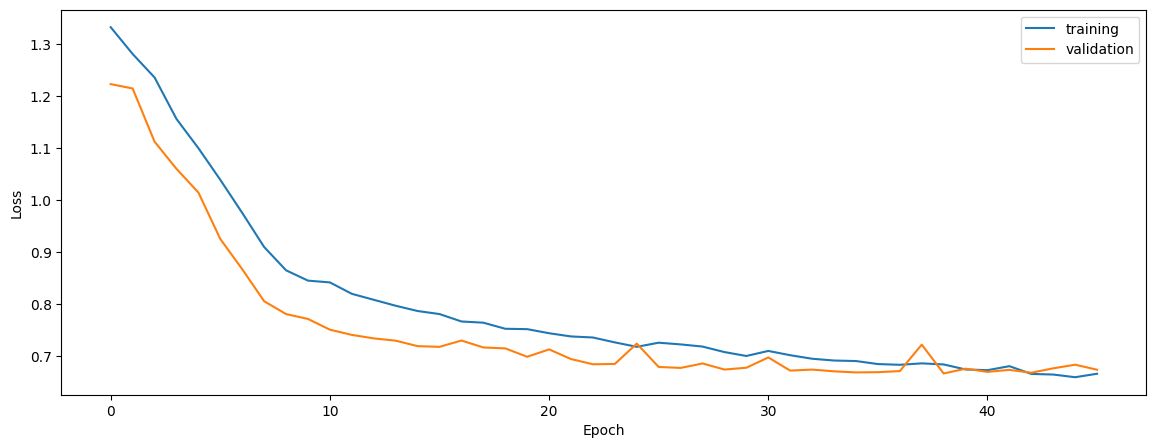

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


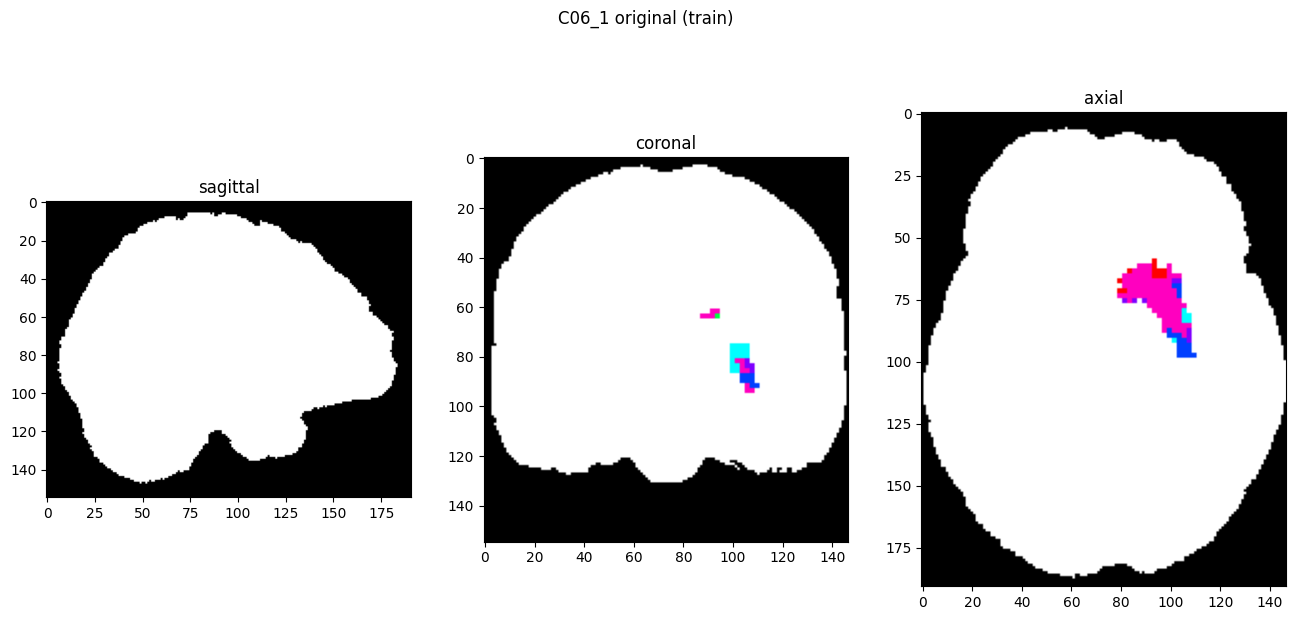

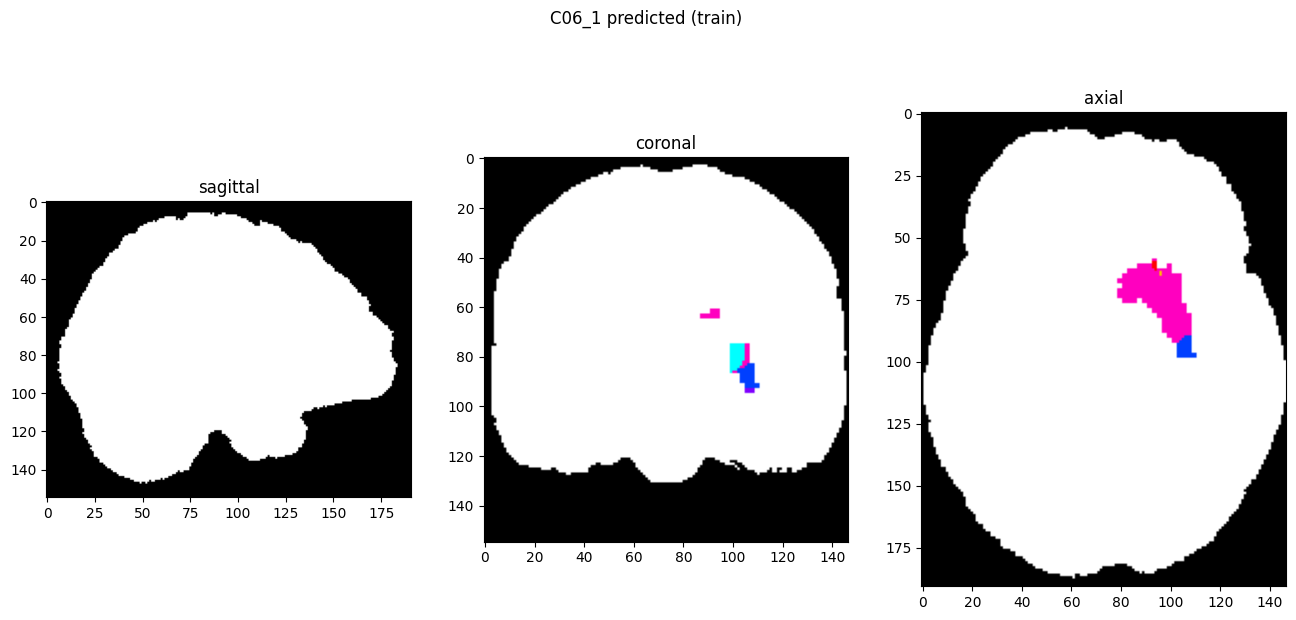

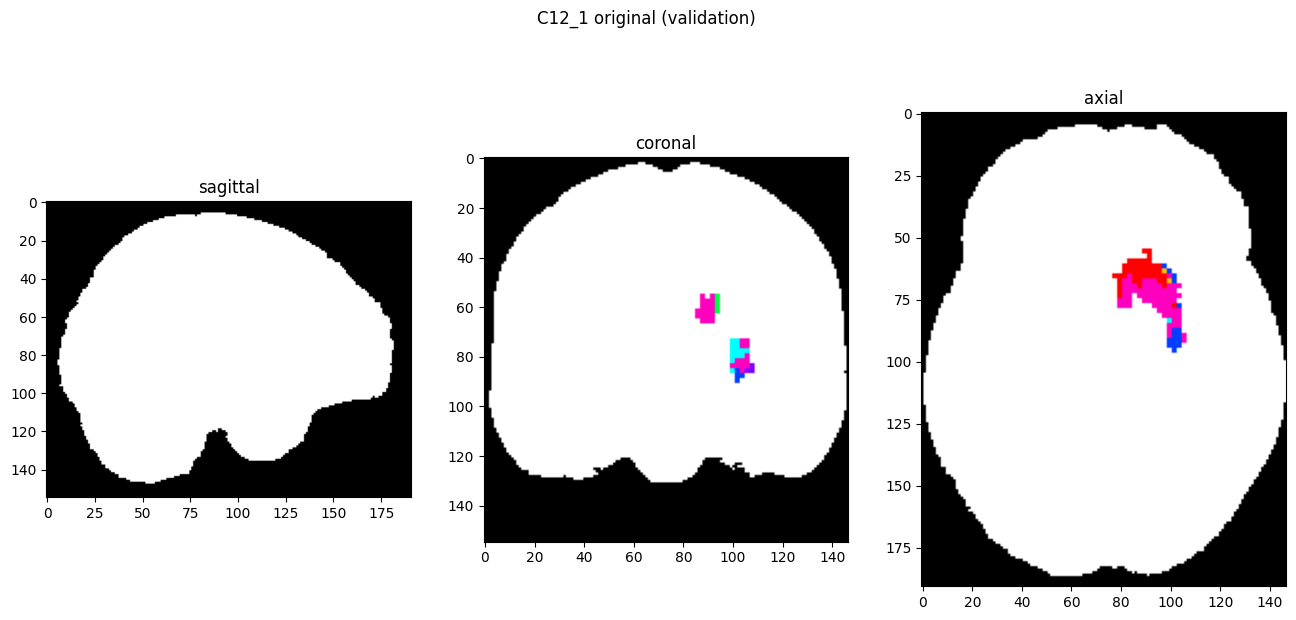

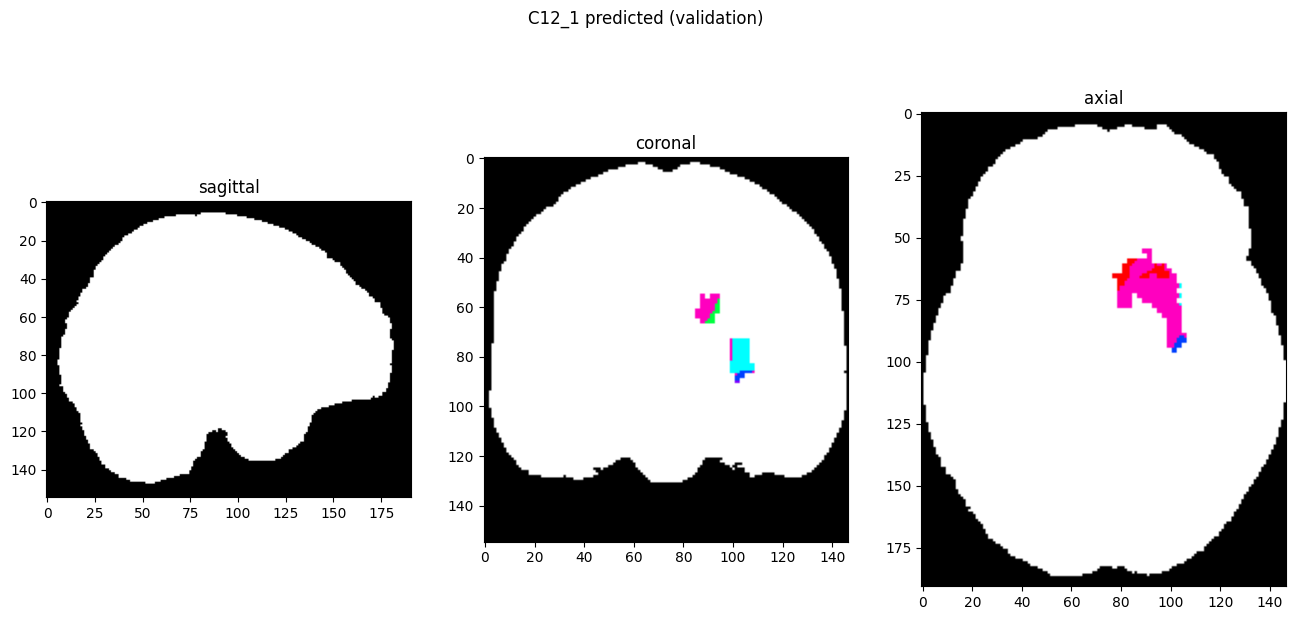

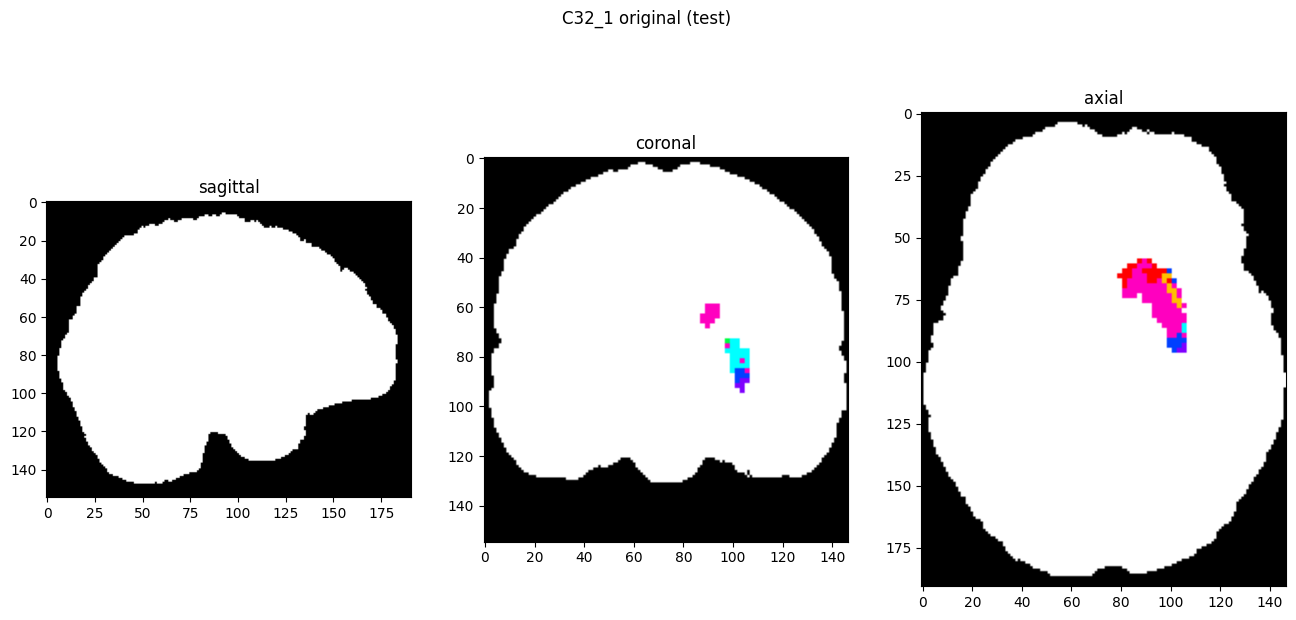

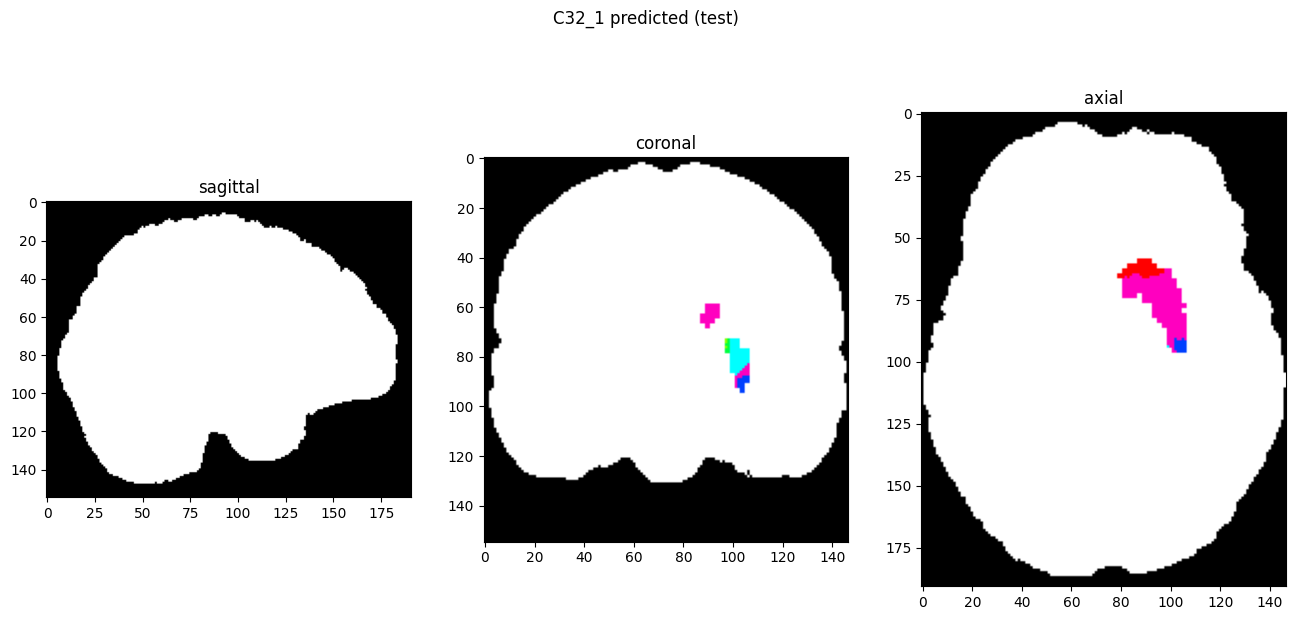

In [10]:
showResults(model, gen, threshold=0)